In [ ]:
import numpy as np
import pandas as pd
import os
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

In [ ]:
%env TORCH_USE_CUDA_DSA=1
%env CUDA_LAUNCH_BLOCKING=1
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline

env: TORCH_USE_CUDA_DSA=1
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [ ]:
# !pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(512, 512),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(p=0.5),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    else:
        transform = A.Compose([
            A.Resize(512, 512),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    return transform

In [ ]:
class DOTADETECTION(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "DOTA_1.5.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]


    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, "images", path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        h, w, _ = image.shape

        normalized_boxes = []
        for box in boxes:
            x_min = box[0] / w
            y_min = box[1] / h
            x_max = (box[0] + box[2]) / w
            y_max = (box[1] + box[3]) / h
            normalized_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min, box[4]])

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=normalized_boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        denormalized_boxes = []
        for box in boxes:
            x_min = box[0] * w
            y_min = box[1] * h
            x_max = (box[0] + box[2]) * w
            y_max = (box[1] + box[3]) * h
            denormalized_boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.tensor(denormalized_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] + 1 for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/drive/MyDrive/dota_dataset"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "DOTA_1.5.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=5.79s)
creating index...
index created!


{1: {'id': 1, 'name': 'plane', 'supercategory': 'plane'},
 2: {'id': 2, 'name': 'baseball-diamond', 'supercategory': 'baseball-diamond'},
 3: {'id': 3, 'name': 'bridge', 'supercategory': 'bridge'},
 4: {'id': 4,
  'name': 'ground-track-field',
  'supercategory': 'ground-track-field'},
 5: {'id': 5, 'name': 'small-vehicle', 'supercategory': 'small-vehicle'},
 6: {'id': 6, 'name': 'large-vehicle', 'supercategory': 'large-vehicle'},
 7: {'id': 7, 'name': 'ship', 'supercategory': 'ship'},
 8: {'id': 8, 'name': 'tennis-court', 'supercategory': 'tennis-court'},
 9: {'id': 9, 'name': 'basketball-court', 'supercategory': 'basketball-court'},
 10: {'id': 10, 'name': 'storage-tank', 'supercategory': 'storage-tank'},
 11: {'id': 11,
  'name': 'soccer-ball-field',
  'supercategory': 'soccer-ball-field'},
 12: {'id': 12, 'name': 'roundabout', 'supercategory': 'roundabout'},
 13: {'id': 13, 'name': 'harbor', 'supercategory': 'harbor'},
 14: {'id': 14, 'name': 'swimming-pool', 'supercategory': 'swimm

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['plane',
 'baseball-diamond',
 'bridge',
 'ground-track-field',
 'small-vehicle',
 'large-vehicle',
 'ship',
 'tennis-court',
 'basketball-court',
 'storage-tank',
 'soccer-ball-field',
 'roundabout',
 'harbor',
 'swimming-pool',
 'helicopter',
 'container-crane']

In [ ]:
train_dataset = DOTADETECTION(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=3.86s)
creating index...
index created!


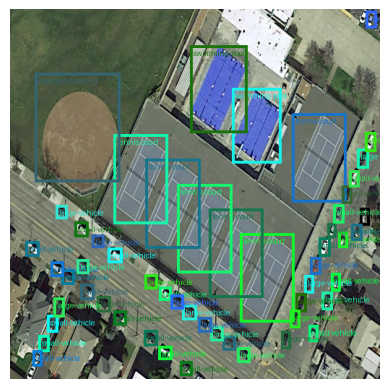

In [ ]:
sample = train_dataset[0]

image_tensor = (sample[0] * 255).to(torch.uint8)

boxes = sample[1]['boxes']
labels = [classes[i.item()-2] for i in sample[1]['labels']]

boxed_image = draw_bounding_boxes(image_tensor, boxes, labels, width=4)

plt.imshow(boxed_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
len(train_dataset)
# print("Labels in dataset:", set([ann['category_id'] for ann in coco.anns.values()]))

1410

In [ ]:
model = models.detection.ssd300_vgg16(weights=None, num_classes=n_classes)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:03<00:00, 149MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
# images,targets = next(iter(train_loader))
# images = list(image for image in images)
# targets = [{k:v for k, v in t.items()} for t in targets]
# output = model(images, targets)

In [ ]:
device = torch.device("cuda")

In [ ]:
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, nesterov=True, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
import gc

def free_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
def train_one_epoch_ssd(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    torch.autograd.set_detect_anomaly(True)

    all_losses = []

    for i, (images, targets) in enumerate(tqdm(loader)):
        try:
            images = [image.to(device) for image in images]
            targets = [{k: torch.as_tensor(v).to(device) for k, v in t.items()} for t in targets]

            for target in targets:
                target["labels"] = torch.as_tensor(target["labels"], dtype=torch.int64).to(device)
                target["labels"] -= 2

                if target["labels"].min() < 0 or target["labels"].max() >= n_classes:
                    print(f"⚠️ Skipping batch {i} due to invalid labels: {target['labels']}")
                    continue  # Skip instead of raising an error

            loss_dict = model(images, targets)  # SSD returns a dictionary of losses
            loss = loss_dict["classification"] + loss_dict["bbox_regression"]  # Sum both losses

            if not torch.isfinite(loss).all():  # Check for NaN or Inf
                print(f"⚠️ Skipping batch {i} due to NaN/Inf loss.")
                continue

            loss_value = loss.item()
            all_losses.append(loss_value)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            del images, targets, loss, loss_dict
            torch.cuda.empty_cache()

        except RuntimeError as e:
            if "CUDA" in str(e):
                print(f"\n⚠️ Skipping batch {i} due to CUDA error: {e}")
                torch.cuda.empty_cache()
                continue
            else:
                print(f"\n⚠️ Unexpected error in batch {i}: {e}")
                raise e

    # Handle case where all batches are skipped
    avg_loss = np.mean(all_losses) if all_losses else float('inf')

    print(f"\nEpoch {epoch}, lr: {optimizer.param_groups[0]['lr']:.6f}, Loss: {avg_loss:.6f}")

    if epoch % 3 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, f"checkpoint_epoch_{epoch}.pth")
        print(f"📌 Model saved at epoch {epoch}")


In [ ]:
num_epochs=25
checkpoint_path = "/content/drive/MyDrive/dota_dataset/models/ssd/"

import time
start_time = time.time()

for epoch in range(num_epochs):
    train_one_epoch_ssd(model, optimizer, train_loader, device, epoch)

end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Training time: {elapsed_time:.2f} seconds")

 73%|███████▎  | 256/353 [08:24<02:44,  1.70s/it]

⚠️ Skipping batch 255 due to NaN/Inf loss.


 73%|███████▎  | 257/353 [08:24<02:01,  1.27s/it]

⚠️ Skipping batch 256 due to NaN/Inf loss.


 73%|███████▎  | 259/353 [08:27<01:45,  1.13s/it]

⚠️ Skipping batch 257 due to NaN/Inf loss.
⚠️ Skipping batch 258 due to NaN/Inf loss.


 74%|███████▍  | 261/353 [08:30<01:50,  1.20s/it]

⚠️ Skipping batch 259 due to NaN/Inf loss.
⚠️ Skipping batch 260 due to NaN/Inf loss.


 74%|███████▍  | 262/353 [08:32<02:28,  1.63s/it]

⚠️ Skipping batch 261 due to NaN/Inf loss.


 75%|███████▍  | 263/353 [08:33<01:49,  1.21s/it]

⚠️ Skipping batch 262 due to NaN/Inf loss.


 75%|███████▍  | 264/353 [08:35<02:20,  1.58s/it]

⚠️ Skipping batch 263 due to NaN/Inf loss.


 75%|███████▌  | 265/353 [08:36<02:01,  1.38s/it]

⚠️ Skipping batch 264 due to NaN/Inf loss.


 75%|███████▌  | 266/353 [08:38<02:09,  1.48s/it]

⚠️ Skipping batch 265 due to NaN/Inf loss.


 76%|███████▌  | 267/353 [08:41<02:49,  1.97s/it]

⚠️ Skipping batch 266 due to NaN/Inf loss.


 76%|███████▌  | 268/353 [08:41<02:04,  1.46s/it]

⚠️ Skipping batch 267 due to NaN/Inf loss.


 76%|███████▌  | 269/353 [08:46<03:22,  2.41s/it]

⚠️ Skipping batch 268 due to NaN/Inf loss.


 76%|███████▋  | 270/353 [08:46<02:30,  1.82s/it]

⚠️ Skipping batch 269 due to NaN/Inf loss.


 77%|███████▋  | 271/353 [08:49<02:46,  2.03s/it]

⚠️ Skipping batch 270 due to NaN/Inf loss.


 77%|███████▋  | 272/353 [08:50<02:21,  1.75s/it]

⚠️ Skipping batch 271 due to NaN/Inf loss.


 77%|███████▋  | 273/353 [08:53<02:49,  2.12s/it]

⚠️ Skipping batch 272 due to NaN/Inf loss.


 78%|███████▊  | 274/353 [08:54<02:34,  1.95s/it]

⚠️ Skipping batch 273 due to NaN/Inf loss.


 78%|███████▊  | 275/353 [08:57<02:41,  2.07s/it]

⚠️ Skipping batch 274 due to NaN/Inf loss.


 78%|███████▊  | 276/353 [08:58<02:15,  1.76s/it]

⚠️ Skipping batch 275 due to NaN/Inf loss.


 78%|███████▊  | 277/353 [08:59<02:13,  1.75s/it]

⚠️ Skipping batch 276 due to NaN/Inf loss.


 79%|███████▉  | 278/353 [09:02<02:29,  1.99s/it]

⚠️ Skipping batch 277 due to NaN/Inf loss.


 79%|███████▉  | 279/353 [09:05<02:40,  2.17s/it]

⚠️ Skipping batch 278 due to NaN/Inf loss.


 79%|███████▉  | 280/353 [09:08<02:57,  2.43s/it]

⚠️ Skipping batch 279 due to NaN/Inf loss.


 80%|███████▉  | 281/353 [09:09<02:31,  2.10s/it]

⚠️ Skipping batch 280 due to NaN/Inf loss.


 80%|███████▉  | 282/353 [09:10<02:10,  1.84s/it]

⚠️ Skipping batch 281 due to NaN/Inf loss.


 80%|████████  | 283/353 [09:12<02:03,  1.76s/it]

⚠️ Skipping batch 282 due to NaN/Inf loss.


 80%|████████  | 284/353 [09:14<02:13,  1.94s/it]

⚠️ Skipping batch 283 due to NaN/Inf loss.


 81%|████████  | 286/353 [09:17<01:47,  1.60s/it]

⚠️ Skipping batch 284 due to NaN/Inf loss.
⚠️ Skipping batch 285 due to NaN/Inf loss.


 81%|████████▏ | 287/353 [09:20<02:11,  1.99s/it]

⚠️ Skipping batch 286 due to NaN/Inf loss.


 82%|████████▏ | 288/353 [09:20<01:34,  1.46s/it]

⚠️ Skipping batch 287 due to NaN/Inf loss.


 82%|████████▏ | 290/353 [09:24<01:33,  1.48s/it]

⚠️ Skipping batch 288 due to NaN/Inf loss.
⚠️ Skipping batch 289 due to NaN/Inf loss.


 83%|████████▎ | 292/353 [09:27<01:22,  1.35s/it]

⚠️ Skipping batch 290 due to NaN/Inf loss.
⚠️ Skipping batch 291 due to NaN/Inf loss.


 83%|████████▎ | 294/353 [09:30<01:26,  1.46s/it]

⚠️ Skipping batch 292 due to NaN/Inf loss.
⚠️ Skipping batch 293 due to NaN/Inf loss.


 84%|████████▎ | 295/353 [09:33<01:46,  1.84s/it]

⚠️ Skipping batch 294 due to NaN/Inf loss.


 84%|████████▍ | 296/353 [09:33<01:17,  1.36s/it]

⚠️ Skipping batch 295 due to NaN/Inf loss.


 84%|████████▍ | 298/353 [09:36<01:11,  1.31s/it]

⚠️ Skipping batch 296 due to NaN/Inf loss.
⚠️ Skipping batch 297 due to NaN/Inf loss.


 85%|████████▍ | 299/353 [09:40<01:41,  1.88s/it]

⚠️ Skipping batch 298 due to NaN/Inf loss.


 85%|████████▍ | 300/353 [09:40<01:14,  1.41s/it]

⚠️ Skipping batch 299 due to NaN/Inf loss.


 86%|████████▌ | 302/353 [09:43<01:06,  1.30s/it]

⚠️ Skipping batch 300 due to NaN/Inf loss.
⚠️ Skipping batch 301 due to NaN/Inf loss.


 86%|████████▌ | 304/353 [09:47<01:13,  1.49s/it]

⚠️ Skipping batch 302 due to NaN/Inf loss.
⚠️ Skipping batch 303 due to NaN/Inf loss.


 86%|████████▋ | 305/353 [09:49<01:29,  1.87s/it]

⚠️ Skipping batch 304 due to NaN/Inf loss.


 87%|████████▋ | 306/353 [09:50<01:04,  1.37s/it]

⚠️ Skipping batch 305 due to NaN/Inf loss.


 87%|████████▋ | 308/353 [09:55<01:20,  1.79s/it]

⚠️ Skipping batch 306 due to NaN/Inf loss.
⚠️ Skipping batch 307 due to NaN/Inf loss.


 88%|████████▊ | 310/353 [09:58<01:07,  1.56s/it]

⚠️ Skipping batch 308 due to NaN/Inf loss.
⚠️ Skipping batch 309 due to NaN/Inf loss.


 88%|████████▊ | 312/353 [10:02<01:06,  1.63s/it]

⚠️ Skipping batch 310 due to NaN/Inf loss.
⚠️ Skipping batch 311 due to NaN/Inf loss.


 89%|████████▉ | 314/353 [10:06<01:06,  1.71s/it]

⚠️ Skipping batch 312 due to NaN/Inf loss.
⚠️ Skipping batch 313 due to NaN/Inf loss.


 90%|████████▉ | 316/353 [10:12<01:15,  2.03s/it]

⚠️ Skipping batch 314 due to NaN/Inf loss.
⚠️ Skipping batch 315 due to NaN/Inf loss.


 90%|█████████ | 318/353 [10:15<00:56,  1.62s/it]

⚠️ Skipping batch 316 due to NaN/Inf loss.
⚠️ Skipping batch 317 due to NaN/Inf loss.


 90%|█████████ | 319/353 [10:20<01:26,  2.55s/it]

⚠️ Skipping batch 318 due to NaN/Inf loss.


 91%|█████████ | 320/353 [10:20<01:02,  1.91s/it]

⚠️ Skipping batch 319 due to NaN/Inf loss.


 91%|█████████ | 321/353 [10:24<01:24,  2.63s/it]

⚠️ Skipping batch 320 due to NaN/Inf loss.


 91%|█████████ | 322/353 [10:25<01:03,  2.06s/it]

⚠️ Skipping batch 321 due to NaN/Inf loss.


 92%|█████████▏| 323/353 [10:28<01:05,  2.17s/it]

⚠️ Skipping batch 322 due to NaN/Inf loss.


 92%|█████████▏| 324/353 [10:28<00:49,  1.72s/it]

⚠️ Skipping batch 323 due to NaN/Inf loss.


 92%|█████████▏| 325/353 [10:33<01:12,  2.58s/it]

⚠️ Skipping batch 324 due to NaN/Inf loss.


 92%|█████████▏| 326/353 [10:34<00:56,  2.10s/it]

⚠️ Skipping batch 325 due to NaN/Inf loss.


 93%|█████████▎| 327/353 [10:36<00:56,  2.19s/it]

⚠️ Skipping batch 326 due to NaN/Inf loss.


 93%|█████████▎| 328/353 [10:38<00:53,  2.15s/it]

⚠️ Skipping batch 327 due to NaN/Inf loss.


 93%|█████████▎| 329/353 [10:40<00:48,  2.01s/it]

⚠️ Skipping batch 328 due to NaN/Inf loss.


 93%|█████████▎| 330/353 [10:41<00:43,  1.88s/it]

⚠️ Skipping batch 329 due to NaN/Inf loss.


 94%|█████████▍| 331/353 [10:43<00:37,  1.73s/it]

⚠️ Skipping batch 330 due to NaN/Inf loss.


 94%|█████████▍| 332/353 [10:45<00:41,  1.99s/it]

⚠️ Skipping batch 331 due to NaN/Inf loss.


 94%|█████████▍| 333/353 [10:46<00:32,  1.61s/it]

⚠️ Skipping batch 332 due to NaN/Inf loss.


 95%|█████████▍| 334/353 [10:48<00:31,  1.66s/it]

⚠️ Skipping batch 333 due to NaN/Inf loss.


 95%|█████████▍| 335/353 [10:49<00:26,  1.46s/it]

⚠️ Skipping batch 334 due to NaN/Inf loss.


 95%|█████████▌| 336/353 [10:51<00:29,  1.73s/it]

⚠️ Skipping batch 335 due to NaN/Inf loss.


 95%|█████████▌| 337/353 [10:53<00:26,  1.64s/it]

⚠️ Skipping batch 336 due to NaN/Inf loss.


 96%|█████████▌| 338/353 [10:55<00:28,  1.87s/it]

⚠️ Skipping batch 337 due to NaN/Inf loss.


 96%|█████████▌| 339/353 [10:56<00:21,  1.53s/it]

⚠️ Skipping batch 338 due to NaN/Inf loss.


 97%|█████████▋| 341/353 [11:02<00:23,  1.97s/it]

⚠️ Skipping batch 339 due to NaN/Inf loss.
⚠️ Skipping batch 340 due to NaN/Inf loss.


 97%|█████████▋| 343/353 [11:05<00:16,  1.68s/it]

⚠️ Skipping batch 341 due to NaN/Inf loss.
⚠️ Skipping batch 342 due to NaN/Inf loss.


 98%|█████████▊| 345/353 [11:10<00:15,  1.93s/it]

⚠️ Skipping batch 343 due to NaN/Inf loss.
⚠️ Skipping batch 344 due to NaN/Inf loss.


 98%|█████████▊| 346/353 [11:13<00:16,  2.31s/it]

⚠️ Skipping batch 345 due to NaN/Inf loss.


 98%|█████████▊| 347/353 [11:14<00:10,  1.68s/it]

⚠️ Skipping batch 346 due to NaN/Inf loss.


 99%|█████████▉| 349/353 [11:17<00:06,  1.60s/it]

⚠️ Skipping batch 347 due to NaN/Inf loss.
⚠️ Skipping batch 348 due to NaN/Inf loss.


 99%|█████████▉| 350/353 [11:20<00:05,  1.93s/it]

⚠️ Skipping batch 349 due to NaN/Inf loss.


 99%|█████████▉| 351/353 [11:20<00:02,  1.41s/it]

⚠️ Skipping batch 350 due to NaN/Inf loss.


100%|██████████| 353/353 [11:25<00:00,  1.94s/it]

⚠️ Skipping batch 351 due to NaN/Inf loss.
⚠️ Skipping batch 352 due to NaN/Inf loss.



Epoch 0, lr: 0.000500, Loss: 58372975.986685
📌 Model saved at epoch 0


  0%|          | 1/353 [00:02<12:24,  2.12s/it]

⚠️ Skipping batch 0 due to NaN/Inf loss.


  1%|          | 2/353 [00:02<06:12,  1.06s/it]

⚠️ Skipping batch 1 due to NaN/Inf loss.


  1%|          | 3/353 [00:04<07:56,  1.36s/it]

⚠️ Skipping batch 2 due to NaN/Inf loss.


  1%|          | 4/353 [00:04<05:18,  1.10it/s]

⚠️ Skipping batch 3 due to NaN/Inf loss.


  1%|▏         | 5/353 [00:05<04:59,  1.16it/s]

⚠️ Skipping batch 4 due to NaN/Inf loss.


  2%|▏         | 6/353 [00:05<03:44,  1.55it/s]

⚠️ Skipping batch 5 due to NaN/Inf loss.


  2%|▏         | 7/353 [00:07<06:01,  1.04s/it]

⚠️ Skipping batch 6 due to NaN/Inf loss.


  2%|▏         | 8/353 [00:07<05:02,  1.14it/s]

⚠️ Skipping batch 7 due to NaN/Inf loss.


  3%|▎         | 9/353 [00:08<04:57,  1.16it/s]

⚠️ Skipping batch 8 due to NaN/Inf loss.


  3%|▎         | 10/353 [00:09<04:12,  1.36it/s]

⚠️ Skipping batch 9 due to NaN/Inf loss.


  3%|▎         | 11/353 [00:10<04:53,  1.17it/s]

⚠️ Skipping batch 10 due to NaN/Inf loss.


  3%|▎         | 12/353 [00:10<03:49,  1.48it/s]

⚠️ Skipping batch 11 due to NaN/Inf loss.


  4%|▎         | 13/353 [00:12<05:29,  1.03it/s]

⚠️ Skipping batch 12 due to NaN/Inf loss.


  4%|▍         | 14/353 [00:12<04:20,  1.30it/s]

⚠️ Skipping batch 13 due to NaN/Inf loss.


  4%|▍         | 15/353 [00:14<07:14,  1.29s/it]

⚠️ Skipping batch 14 due to NaN/Inf loss.


  5%|▍         | 16/353 [00:15<05:32,  1.01it/s]

⚠️ Skipping batch 15 due to NaN/Inf loss.


  5%|▍         | 17/353 [00:15<04:30,  1.24it/s]

⚠️ Skipping batch 16 due to NaN/Inf loss.


  5%|▌         | 18/353 [00:15<03:41,  1.51it/s]

⚠️ Skipping batch 17 due to NaN/Inf loss.


  5%|▌         | 19/353 [00:16<03:33,  1.56it/s]

⚠️ Skipping batch 18 due to NaN/Inf loss.


  6%|▌         | 20/353 [00:16<03:07,  1.78it/s]

⚠️ Skipping batch 19 due to NaN/Inf loss.


  6%|▌         | 21/353 [00:17<03:27,  1.60it/s]

⚠️ Skipping batch 20 due to NaN/Inf loss.


  6%|▌         | 22/353 [00:17<03:00,  1.84it/s]

⚠️ Skipping batch 21 due to NaN/Inf loss.


  7%|▋         | 23/353 [00:18<02:38,  2.08it/s]

⚠️ Skipping batch 22 due to NaN/Inf loss.


  7%|▋         | 24/353 [00:18<02:25,  2.26it/s]

⚠️ Skipping batch 23 due to NaN/Inf loss.


  7%|▋         | 25/353 [00:19<03:20,  1.64it/s]

⚠️ Skipping batch 24 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:20<03:15,  1.67it/s]

⚠️ Skipping batch 25 due to NaN/Inf loss.


  8%|▊         | 27/353 [00:22<05:28,  1.01s/it]

⚠️ Skipping batch 26 due to NaN/Inf loss.


  8%|▊         | 28/353 [00:22<04:35,  1.18it/s]

⚠️ Skipping batch 27 due to NaN/Inf loss.


  8%|▊         | 29/353 [00:23<05:20,  1.01it/s]

⚠️ Skipping batch 28 due to NaN/Inf loss.


  8%|▊         | 30/353 [00:24<04:09,  1.29it/s]

⚠️ Skipping batch 29 due to NaN/Inf loss.


  9%|▉         | 31/353 [00:25<05:31,  1.03s/it]

⚠️ Skipping batch 30 due to NaN/Inf loss.


  9%|▉         | 32/353 [00:26<04:21,  1.23it/s]

⚠️ Skipping batch 31 due to NaN/Inf loss.


  9%|▉         | 33/353 [00:26<03:27,  1.54it/s]

⚠️ Skipping batch 32 due to NaN/Inf loss.


 10%|▉         | 34/353 [00:27<03:31,  1.51it/s]

⚠️ Skipping batch 33 due to NaN/Inf loss.


 10%|▉         | 35/353 [00:27<03:40,  1.44it/s]

⚠️ Skipping batch 34 due to NaN/Inf loss.


 10%|█         | 36/353 [00:28<03:06,  1.70it/s]

⚠️ Skipping batch 35 due to NaN/Inf loss.


 10%|█         | 37/353 [00:30<05:48,  1.10s/it]

⚠️ Skipping batch 36 due to NaN/Inf loss.


 11%|█         | 38/353 [00:30<04:37,  1.14it/s]

⚠️ Skipping batch 37 due to NaN/Inf loss.


 11%|█         | 39/353 [00:31<04:10,  1.25it/s]

⚠️ Skipping batch 38 due to NaN/Inf loss.


 11%|█▏        | 40/353 [00:31<03:23,  1.54it/s]

⚠️ Skipping batch 39 due to NaN/Inf loss.


 12%|█▏        | 41/353 [00:32<02:52,  1.80it/s]

⚠️ Skipping batch 40 due to NaN/Inf loss.


 12%|█▏        | 42/353 [00:32<02:33,  2.02it/s]

⚠️ Skipping batch 41 due to NaN/Inf loss.


 12%|█▏        | 43/353 [00:35<06:06,  1.18s/it]

⚠️ Skipping batch 42 due to NaN/Inf loss.


 12%|█▏        | 44/353 [00:35<05:02,  1.02it/s]

⚠️ Skipping batch 43 due to NaN/Inf loss.


 13%|█▎        | 45/353 [00:37<05:41,  1.11s/it]

⚠️ Skipping batch 44 due to NaN/Inf loss.


 13%|█▎        | 46/353 [00:37<04:26,  1.15it/s]

⚠️ Skipping batch 45 due to NaN/Inf loss.


 13%|█▎        | 47/353 [00:38<04:36,  1.11it/s]

⚠️ Skipping batch 46 due to NaN/Inf loss.


 14%|█▎        | 48/353 [00:38<03:43,  1.37it/s]

⚠️ Skipping batch 47 due to NaN/Inf loss.


 14%|█▍        | 49/353 [00:39<03:24,  1.49it/s]

⚠️ Skipping batch 48 due to NaN/Inf loss.


 14%|█▍        | 50/353 [00:39<02:57,  1.71it/s]

⚠️ Skipping batch 49 due to NaN/Inf loss.


 14%|█▍        | 51/353 [00:40<02:35,  1.95it/s]

⚠️ Skipping batch 50 due to NaN/Inf loss.


 15%|█▍        | 52/353 [00:40<02:10,  2.31it/s]

⚠️ Skipping batch 51 due to NaN/Inf loss.


 15%|█▌        | 53/353 [00:40<01:57,  2.56it/s]

⚠️ Skipping batch 52 due to NaN/Inf loss.


 15%|█▌        | 54/353 [00:41<02:07,  2.34it/s]

⚠️ Skipping batch 53 due to NaN/Inf loss.


 16%|█▌        | 55/353 [00:41<01:51,  2.67it/s]

⚠️ Skipping batch 54 due to NaN/Inf loss.


 16%|█▌        | 56/353 [00:42<02:39,  1.87it/s]

⚠️ Skipping batch 55 due to NaN/Inf loss.


 16%|█▌        | 57/353 [00:42<02:23,  2.07it/s]

⚠️ Skipping batch 56 due to NaN/Inf loss.


 16%|█▋        | 58/353 [00:44<04:00,  1.22it/s]

⚠️ Skipping batch 57 due to NaN/Inf loss.


 17%|█▋        | 59/353 [00:44<03:17,  1.49it/s]

⚠️ Skipping batch 58 due to NaN/Inf loss.


 17%|█▋        | 60/353 [00:44<02:40,  1.83it/s]

⚠️ Skipping batch 59 due to NaN/Inf loss.


 17%|█▋        | 61/353 [00:45<02:11,  2.22it/s]

⚠️ Skipping batch 60 due to NaN/Inf loss.


 18%|█▊        | 62/353 [00:45<02:34,  1.89it/s]

⚠️ Skipping batch 61 due to NaN/Inf loss.


 18%|█▊        | 63/353 [00:47<03:49,  1.26it/s]

⚠️ Skipping batch 62 due to NaN/Inf loss.


 18%|█▊        | 64/353 [00:47<03:46,  1.28it/s]

⚠️ Skipping batch 63 due to NaN/Inf loss.


 18%|█▊        | 65/353 [00:49<04:08,  1.16it/s]

⚠️ Skipping batch 64 due to NaN/Inf loss.


 19%|█▊        | 66/353 [00:49<03:23,  1.41it/s]

⚠️ Skipping batch 65 due to NaN/Inf loss.


 19%|█▉        | 67/353 [00:51<04:49,  1.01s/it]

⚠️ Skipping batch 66 due to NaN/Inf loss.


 19%|█▉        | 68/353 [00:52<05:46,  1.22s/it]

⚠️ Skipping batch 67 due to NaN/Inf loss.


 20%|█▉        | 69/353 [00:53<04:25,  1.07it/s]

⚠️ Skipping batch 68 due to NaN/Inf loss.


 20%|█▉        | 70/353 [00:53<03:48,  1.24it/s]

⚠️ Skipping batch 69 due to NaN/Inf loss.


 20%|██        | 71/353 [00:53<02:58,  1.58it/s]

⚠️ Skipping batch 70 due to NaN/Inf loss.


 20%|██        | 72/353 [00:54<03:05,  1.51it/s]

⚠️ Skipping batch 71 due to NaN/Inf loss.


 21%|██        | 73/353 [00:54<02:36,  1.79it/s]

⚠️ Skipping batch 72 due to NaN/Inf loss.


 21%|██        | 74/353 [00:56<03:30,  1.32it/s]

⚠️ Skipping batch 73 due to NaN/Inf loss.


 21%|██        | 75/353 [00:56<02:49,  1.64it/s]

⚠️ Skipping batch 74 due to NaN/Inf loss.


 22%|██▏       | 76/353 [00:56<02:22,  1.95it/s]

⚠️ Skipping batch 75 due to NaN/Inf loss.


 22%|██▏       | 77/353 [00:56<02:01,  2.27it/s]

⚠️ Skipping batch 76 due to NaN/Inf loss.


 22%|██▏       | 78/353 [00:57<01:48,  2.53it/s]

⚠️ Skipping batch 77 due to NaN/Inf loss.


 22%|██▏       | 79/353 [00:57<01:45,  2.60it/s]

⚠️ Skipping batch 78 due to NaN/Inf loss.


 23%|██▎       | 80/353 [00:58<02:17,  1.99it/s]

⚠️ Skipping batch 79 due to NaN/Inf loss.


 23%|██▎       | 81/353 [00:58<02:04,  2.19it/s]

⚠️ Skipping batch 80 due to NaN/Inf loss.


 23%|██▎       | 82/353 [00:59<03:01,  1.49it/s]

⚠️ Skipping batch 81 due to NaN/Inf loss.


 24%|██▎       | 83/353 [01:00<02:24,  1.87it/s]

⚠️ Skipping batch 82 due to NaN/Inf loss.


 24%|██▍       | 84/353 [01:01<03:09,  1.42it/s]

⚠️ Skipping batch 83 due to NaN/Inf loss.


 24%|██▍       | 85/353 [01:02<03:30,  1.27it/s]

⚠️ Skipping batch 84 due to NaN/Inf loss.


 24%|██▍       | 86/353 [01:02<03:06,  1.43it/s]

⚠️ Skipping batch 85 due to NaN/Inf loss.


 25%|██▍       | 87/353 [01:04<04:03,  1.09it/s]

⚠️ Skipping batch 86 due to NaN/Inf loss.


 25%|██▍       | 88/353 [01:04<03:22,  1.31it/s]

⚠️ Skipping batch 87 due to NaN/Inf loss.


 25%|██▌       | 89/353 [01:05<03:43,  1.18it/s]

⚠️ Skipping batch 88 due to NaN/Inf loss.


 25%|██▌       | 90/353 [01:05<02:59,  1.46it/s]

⚠️ Skipping batch 89 due to NaN/Inf loss.


 26%|██▌       | 91/353 [01:07<04:27,  1.02s/it]

⚠️ Skipping batch 90 due to NaN/Inf loss.


 26%|██▌       | 92/353 [01:07<03:29,  1.25it/s]

⚠️ Skipping batch 91 due to NaN/Inf loss.


 26%|██▋       | 93/353 [01:09<03:53,  1.11it/s]

⚠️ Skipping batch 92 due to NaN/Inf loss.


 27%|██▋       | 94/353 [01:09<03:06,  1.39it/s]

⚠️ Skipping batch 93 due to NaN/Inf loss.


 27%|██▋       | 95/353 [01:09<02:34,  1.67it/s]

⚠️ Skipping batch 94 due to NaN/Inf loss.


 27%|██▋       | 96/353 [01:09<02:08,  2.00it/s]

⚠️ Skipping batch 95 due to NaN/Inf loss.


 27%|██▋       | 97/353 [01:11<03:07,  1.36it/s]

⚠️ Skipping batch 96 due to NaN/Inf loss.


 28%|██▊       | 98/353 [01:11<02:32,  1.67it/s]

⚠️ Skipping batch 97 due to NaN/Inf loss.


 28%|██▊       | 99/353 [01:12<02:32,  1.66it/s]

⚠️ Skipping batch 98 due to NaN/Inf loss.


 28%|██▊       | 100/353 [01:12<02:09,  1.95it/s]

⚠️ Skipping batch 99 due to NaN/Inf loss.


 29%|██▊       | 101/353 [01:12<02:08,  1.96it/s]

⚠️ Skipping batch 100 due to NaN/Inf loss.


 29%|██▉       | 102/353 [01:13<01:46,  2.36it/s]

⚠️ Skipping batch 101 due to NaN/Inf loss.


 29%|██▉       | 103/353 [01:14<02:20,  1.78it/s]

⚠️ Skipping batch 102 due to NaN/Inf loss.


 29%|██▉       | 104/353 [01:14<01:59,  2.08it/s]

⚠️ Skipping batch 103 due to NaN/Inf loss.


 30%|██▉       | 105/353 [01:15<02:28,  1.67it/s]

⚠️ Skipping batch 104 due to NaN/Inf loss.


 30%|███       | 106/353 [01:15<02:10,  1.90it/s]

⚠️ Skipping batch 105 due to NaN/Inf loss.


 30%|███       | 107/353 [01:16<02:30,  1.63it/s]

⚠️ Skipping batch 106 due to NaN/Inf loss.


 31%|███       | 108/353 [01:16<02:23,  1.71it/s]

⚠️ Skipping batch 107 due to NaN/Inf loss.


 31%|███       | 109/353 [01:17<02:14,  1.82it/s]

⚠️ Skipping batch 108 due to NaN/Inf loss.


 31%|███       | 110/353 [01:17<02:10,  1.86it/s]

⚠️ Skipping batch 109 due to NaN/Inf loss.


 31%|███▏      | 111/353 [01:18<02:09,  1.87it/s]

⚠️ Skipping batch 110 due to NaN/Inf loss.


 32%|███▏      | 112/353 [01:18<02:03,  1.95it/s]

⚠️ Skipping batch 111 due to NaN/Inf loss.


 32%|███▏      | 113/353 [01:19<02:11,  1.83it/s]

⚠️ Skipping batch 112 due to NaN/Inf loss.


 32%|███▏      | 114/353 [01:19<01:56,  2.05it/s]

⚠️ Skipping batch 113 due to NaN/Inf loss.


 33%|███▎      | 115/353 [01:21<03:26,  1.15it/s]

⚠️ Skipping batch 114 due to NaN/Inf loss.


 33%|███▎      | 116/353 [01:21<02:43,  1.45it/s]

⚠️ Skipping batch 115 due to NaN/Inf loss.


 33%|███▎      | 117/353 [01:22<02:19,  1.69it/s]

⚠️ Skipping batch 116 due to NaN/Inf loss.


 33%|███▎      | 118/353 [01:23<02:43,  1.43it/s]

⚠️ Skipping batch 117 due to NaN/Inf loss.


 34%|███▎      | 119/353 [01:23<02:18,  1.69it/s]

⚠️ Skipping batch 118 due to NaN/Inf loss.


 34%|███▍      | 120/353 [01:24<02:12,  1.76it/s]

⚠️ Skipping batch 119 due to NaN/Inf loss.


 34%|███▍      | 121/353 [01:24<02:11,  1.76it/s]

⚠️ Skipping batch 120 due to NaN/Inf loss.


 35%|███▍      | 122/353 [01:25<02:01,  1.90it/s]

⚠️ Skipping batch 121 due to NaN/Inf loss.


 35%|███▍      | 123/353 [01:25<01:48,  2.12it/s]

⚠️ Skipping batch 122 due to NaN/Inf loss.


 35%|███▌      | 124/353 [01:25<01:36,  2.37it/s]

⚠️ Skipping batch 123 due to NaN/Inf loss.


 35%|███▌      | 125/353 [01:26<01:44,  2.18it/s]

⚠️ Skipping batch 124 due to NaN/Inf loss.


 36%|███▌      | 126/353 [01:26<01:34,  2.40it/s]

⚠️ Skipping batch 125 due to NaN/Inf loss.


 36%|███▌      | 127/353 [01:27<02:24,  1.56it/s]

⚠️ Skipping batch 126 due to NaN/Inf loss.


 36%|███▋      | 128/353 [01:28<02:17,  1.63it/s]

⚠️ Skipping batch 127 due to NaN/Inf loss.


 37%|███▋      | 129/353 [01:28<01:59,  1.87it/s]

⚠️ Skipping batch 128 due to NaN/Inf loss.


 37%|███▋      | 130/353 [01:30<03:04,  1.21it/s]

⚠️ Skipping batch 129 due to NaN/Inf loss.


 37%|███▋      | 131/353 [01:30<02:38,  1.40it/s]

⚠️ Skipping batch 130 due to NaN/Inf loss.


 37%|███▋      | 132/353 [01:32<03:30,  1.05it/s]

⚠️ Skipping batch 131 due to NaN/Inf loss.


 38%|███▊      | 133/353 [01:32<02:53,  1.27it/s]

⚠️ Skipping batch 132 due to NaN/Inf loss.


 38%|███▊      | 134/353 [01:33<03:22,  1.08it/s]

⚠️ Skipping batch 133 due to NaN/Inf loss.


 38%|███▊      | 135/353 [01:33<02:40,  1.36it/s]

⚠️ Skipping batch 134 due to NaN/Inf loss.


 39%|███▊      | 136/353 [01:34<02:36,  1.39it/s]

⚠️ Skipping batch 135 due to NaN/Inf loss.


 39%|███▉      | 137/353 [01:35<02:10,  1.66it/s]

⚠️ Skipping batch 136 due to NaN/Inf loss.


 39%|███▉      | 138/353 [01:35<02:24,  1.48it/s]

⚠️ Skipping batch 137 due to NaN/Inf loss.


 39%|███▉      | 139/353 [01:36<02:03,  1.73it/s]

⚠️ Skipping batch 138 due to NaN/Inf loss.


 40%|███▉      | 140/353 [01:37<02:48,  1.26it/s]

⚠️ Skipping batch 139 due to NaN/Inf loss.


 40%|███▉      | 141/353 [01:37<02:20,  1.51it/s]

⚠️ Skipping batch 140 due to NaN/Inf loss.


 40%|████      | 142/353 [01:38<02:42,  1.30it/s]

⚠️ Skipping batch 141 due to NaN/Inf loss.


 41%|████      | 143/353 [01:39<02:10,  1.61it/s]

⚠️ Skipping batch 142 due to NaN/Inf loss.


 41%|████      | 144/353 [01:40<02:24,  1.44it/s]

⚠️ Skipping batch 143 due to NaN/Inf loss.


 41%|████      | 145/353 [01:40<02:00,  1.73it/s]

⚠️ Skipping batch 144 due to NaN/Inf loss.


 41%|████▏     | 146/353 [01:40<01:59,  1.73it/s]

⚠️ Skipping batch 145 due to NaN/Inf loss.


 42%|████▏     | 147/353 [01:41<01:41,  2.03it/s]

⚠️ Skipping batch 146 due to NaN/Inf loss.


 42%|████▏     | 148/353 [01:42<02:24,  1.42it/s]

⚠️ Skipping batch 147 due to NaN/Inf loss.


 42%|████▏     | 149/353 [01:42<01:54,  1.78it/s]

⚠️ Skipping batch 148 due to NaN/Inf loss.


 42%|████▏     | 150/353 [01:42<01:38,  2.06it/s]

⚠️ Skipping batch 149 due to NaN/Inf loss.


 43%|████▎     | 151/353 [01:43<01:27,  2.31it/s]

⚠️ Skipping batch 150 due to NaN/Inf loss.


 43%|████▎     | 152/353 [01:44<02:10,  1.54it/s]

⚠️ Skipping batch 151 due to NaN/Inf loss.


 43%|████▎     | 153/353 [01:44<01:58,  1.68it/s]

⚠️ Skipping batch 152 due to NaN/Inf loss.


 44%|████▎     | 154/353 [01:45<02:29,  1.33it/s]

⚠️ Skipping batch 153 due to NaN/Inf loss.


 44%|████▍     | 155/353 [01:47<03:23,  1.03s/it]

⚠️ Skipping batch 154 due to NaN/Inf loss.


 44%|████▍     | 156/353 [01:47<02:38,  1.24it/s]

⚠️ Skipping batch 155 due to NaN/Inf loss.


 44%|████▍     | 157/353 [01:48<02:49,  1.16it/s]

⚠️ Skipping batch 156 due to NaN/Inf loss.


 45%|████▍     | 158/353 [01:49<02:16,  1.43it/s]

⚠️ Skipping batch 157 due to NaN/Inf loss.


 45%|████▌     | 159/353 [01:50<02:27,  1.31it/s]

⚠️ Skipping batch 158 due to NaN/Inf loss.


 45%|████▌     | 160/353 [01:50<02:04,  1.56it/s]

⚠️ Skipping batch 159 due to NaN/Inf loss.


 46%|████▌     | 161/353 [01:51<02:03,  1.56it/s]

⚠️ Skipping batch 160 due to NaN/Inf loss.


 46%|████▌     | 162/353 [01:51<01:41,  1.88it/s]

⚠️ Skipping batch 161 due to NaN/Inf loss.


 46%|████▌     | 163/353 [01:53<02:51,  1.11it/s]

⚠️ Skipping batch 162 due to NaN/Inf loss.


 46%|████▋     | 164/353 [01:53<02:18,  1.36it/s]

⚠️ Skipping batch 163 due to NaN/Inf loss.


 47%|████▋     | 165/353 [01:53<01:54,  1.64it/s]

⚠️ Skipping batch 164 due to NaN/Inf loss.


 47%|████▋     | 166/353 [01:54<01:47,  1.74it/s]

⚠️ Skipping batch 165 due to NaN/Inf loss.


 47%|████▋     | 167/353 [01:54<01:32,  2.00it/s]

⚠️ Skipping batch 166 due to NaN/Inf loss.


 48%|████▊     | 168/353 [01:54<01:19,  2.32it/s]

⚠️ Skipping batch 167 due to NaN/Inf loss.


 48%|████▊     | 169/353 [01:55<01:28,  2.08it/s]

⚠️ Skipping batch 168 due to NaN/Inf loss.


 48%|████▊     | 170/353 [01:56<01:39,  1.85it/s]

⚠️ Skipping batch 169 due to NaN/Inf loss.


 48%|████▊     | 171/353 [01:56<01:49,  1.67it/s]

⚠️ Skipping batch 170 due to NaN/Inf loss.


 49%|████▊     | 172/353 [01:57<01:37,  1.86it/s]

⚠️ Skipping batch 171 due to NaN/Inf loss.


 49%|████▉     | 173/353 [02:00<03:53,  1.30s/it]

⚠️ Skipping batch 172 due to NaN/Inf loss.


 49%|████▉     | 174/353 [02:00<03:03,  1.03s/it]

⚠️ Skipping batch 173 due to NaN/Inf loss.


 50%|████▉     | 175/353 [02:01<02:49,  1.05it/s]

⚠️ Skipping batch 174 due to NaN/Inf loss.


 50%|████▉     | 176/353 [02:01<02:13,  1.33it/s]

⚠️ Skipping batch 175 due to NaN/Inf loss.


 50%|█████     | 177/353 [02:02<02:18,  1.27it/s]

⚠️ Skipping batch 176 due to NaN/Inf loss.


 50%|█████     | 178/353 [02:04<03:19,  1.14s/it]

⚠️ Skipping batch 177 due to NaN/Inf loss.


 51%|█████     | 179/353 [02:05<02:36,  1.11it/s]

⚠️ Skipping batch 178 due to NaN/Inf loss.


 51%|█████     | 180/353 [02:05<02:25,  1.19it/s]

⚠️ Skipping batch 179 due to NaN/Inf loss.


 51%|█████▏    | 181/353 [02:06<01:58,  1.45it/s]

⚠️ Skipping batch 180 due to NaN/Inf loss.


 52%|█████▏    | 182/353 [02:07<02:28,  1.15it/s]

⚠️ Skipping batch 181 due to NaN/Inf loss.


 52%|█████▏    | 183/353 [02:07<02:00,  1.42it/s]

⚠️ Skipping batch 182 due to NaN/Inf loss.


 52%|█████▏    | 184/353 [02:08<02:05,  1.35it/s]

⚠️ Skipping batch 183 due to NaN/Inf loss.


 52%|█████▏    | 185/353 [02:08<01:45,  1.60it/s]

⚠️ Skipping batch 184 due to NaN/Inf loss.


 53%|█████▎    | 186/353 [02:09<01:30,  1.84it/s]

⚠️ Skipping batch 185 due to NaN/Inf loss.


 53%|█████▎    | 187/353 [02:09<01:18,  2.13it/s]

⚠️ Skipping batch 186 due to NaN/Inf loss.


 53%|█████▎    | 188/353 [02:10<01:40,  1.64it/s]

⚠️ Skipping batch 187 due to NaN/Inf loss.


 54%|█████▎    | 189/353 [02:10<01:22,  1.99it/s]

⚠️ Skipping batch 188 due to NaN/Inf loss.


 54%|█████▍    | 190/353 [02:11<01:25,  1.90it/s]

⚠️ Skipping batch 189 due to NaN/Inf loss.


 54%|█████▍    | 191/353 [02:11<01:21,  1.98it/s]

⚠️ Skipping batch 190 due to NaN/Inf loss.


 54%|█████▍    | 192/353 [02:12<01:22,  1.94it/s]

⚠️ Skipping batch 191 due to NaN/Inf loss.


 55%|█████▍    | 193/353 [02:12<01:20,  1.99it/s]

⚠️ Skipping batch 192 due to NaN/Inf loss.


 55%|█████▍    | 194/353 [02:13<01:37,  1.62it/s]

⚠️ Skipping batch 193 due to NaN/Inf loss.


 55%|█████▌    | 195/353 [02:14<01:58,  1.33it/s]

⚠️ Skipping batch 194 due to NaN/Inf loss.


 56%|█████▌    | 196/353 [02:15<01:58,  1.33it/s]

⚠️ Skipping batch 195 due to NaN/Inf loss.


 56%|█████▌    | 197/353 [02:15<01:42,  1.52it/s]

⚠️ Skipping batch 196 due to NaN/Inf loss.


 56%|█████▌    | 198/353 [02:16<01:39,  1.55it/s]

⚠️ Skipping batch 197 due to NaN/Inf loss.


 56%|█████▋    | 199/353 [02:16<01:26,  1.78it/s]

⚠️ Skipping batch 198 due to NaN/Inf loss.


 57%|█████▋    | 200/353 [02:18<02:11,  1.17it/s]

⚠️ Skipping batch 199 due to NaN/Inf loss.


 57%|█████▋    | 201/353 [02:18<01:44,  1.45it/s]

⚠️ Skipping batch 200 due to NaN/Inf loss.


 57%|█████▋    | 202/353 [02:19<01:29,  1.68it/s]

⚠️ Skipping batch 201 due to NaN/Inf loss.


 58%|█████▊    | 203/353 [02:19<01:13,  2.04it/s]

⚠️ Skipping batch 202 due to NaN/Inf loss.


 58%|█████▊    | 204/353 [02:20<01:36,  1.54it/s]

⚠️ Skipping batch 203 due to NaN/Inf loss.


 58%|█████▊    | 205/353 [02:20<01:23,  1.78it/s]

⚠️ Skipping batch 204 due to NaN/Inf loss.


 58%|█████▊    | 206/353 [02:21<01:39,  1.47it/s]

⚠️ Skipping batch 205 due to NaN/Inf loss.


 59%|█████▊    | 207/353 [02:21<01:21,  1.80it/s]

⚠️ Skipping batch 206 due to NaN/Inf loss.


 59%|█████▉    | 208/353 [02:22<01:26,  1.68it/s]

⚠️ Skipping batch 207 due to NaN/Inf loss.


 59%|█████▉    | 209/353 [02:22<01:13,  1.96it/s]

⚠️ Skipping batch 208 due to NaN/Inf loss.


 59%|█████▉    | 210/353 [02:23<01:27,  1.64it/s]

⚠️ Skipping batch 209 due to NaN/Inf loss.


 60%|█████▉    | 211/353 [02:24<01:18,  1.82it/s]

⚠️ Skipping batch 210 due to NaN/Inf loss.


 60%|██████    | 212/353 [02:24<01:07,  2.09it/s]

⚠️ Skipping batch 211 due to NaN/Inf loss.


 60%|██████    | 213/353 [02:24<01:01,  2.29it/s]

⚠️ Skipping batch 212 due to NaN/Inf loss.


 61%|██████    | 214/353 [02:26<01:33,  1.49it/s]

⚠️ Skipping batch 213 due to NaN/Inf loss.


 61%|██████    | 215/353 [02:26<01:25,  1.61it/s]

⚠️ Skipping batch 214 due to NaN/Inf loss.


 61%|██████    | 216/353 [02:28<02:03,  1.11it/s]

⚠️ Skipping batch 215 due to NaN/Inf loss.


 61%|██████▏   | 217/353 [02:28<01:43,  1.32it/s]

⚠️ Skipping batch 216 due to NaN/Inf loss.


 62%|██████▏   | 218/353 [02:29<02:08,  1.05it/s]

⚠️ Skipping batch 217 due to NaN/Inf loss.


 62%|██████▏   | 219/353 [02:30<01:42,  1.31it/s]

⚠️ Skipping batch 218 due to NaN/Inf loss.


 62%|██████▏   | 220/353 [02:30<01:24,  1.57it/s]

⚠️ Skipping batch 219 due to NaN/Inf loss.


 63%|██████▎   | 221/353 [02:30<01:10,  1.87it/s]

⚠️ Skipping batch 220 due to NaN/Inf loss.


 63%|██████▎   | 222/353 [02:31<01:22,  1.59it/s]

⚠️ Skipping batch 221 due to NaN/Inf loss.


 63%|██████▎   | 223/353 [02:32<01:22,  1.58it/s]

⚠️ Skipping batch 222 due to NaN/Inf loss.


 63%|██████▎   | 224/353 [02:33<01:20,  1.61it/s]

⚠️ Skipping batch 223 due to NaN/Inf loss.


 64%|██████▎   | 225/353 [02:34<01:49,  1.17it/s]

⚠️ Skipping batch 224 due to NaN/Inf loss.


 64%|██████▍   | 226/353 [02:34<01:28,  1.43it/s]

⚠️ Skipping batch 225 due to NaN/Inf loss.


 64%|██████▍   | 227/353 [02:37<02:31,  1.20s/it]

⚠️ Skipping batch 226 due to NaN/Inf loss.


 65%|██████▍   | 228/353 [02:37<01:54,  1.09it/s]

⚠️ Skipping batch 227 due to NaN/Inf loss.


 65%|██████▍   | 229/353 [02:37<01:31,  1.35it/s]

⚠️ Skipping batch 228 due to NaN/Inf loss.


 65%|██████▌   | 230/353 [02:38<01:14,  1.65it/s]

⚠️ Skipping batch 229 due to NaN/Inf loss.


 65%|██████▌   | 231/353 [02:39<01:45,  1.16it/s]

⚠️ Skipping batch 230 due to NaN/Inf loss.


 66%|██████▌   | 232/353 [02:39<01:31,  1.33it/s]

⚠️ Skipping batch 231 due to NaN/Inf loss.


 66%|██████▌   | 233/353 [02:40<01:26,  1.39it/s]

⚠️ Skipping batch 232 due to NaN/Inf loss.


 66%|██████▋   | 234/353 [02:41<01:19,  1.50it/s]

⚠️ Skipping batch 233 due to NaN/Inf loss.


 67%|██████▋   | 235/353 [02:41<01:16,  1.54it/s]

⚠️ Skipping batch 234 due to NaN/Inf loss.


 67%|██████▋   | 236/353 [02:42<01:21,  1.44it/s]

⚠️ Skipping batch 235 due to NaN/Inf loss.


 67%|██████▋   | 237/353 [02:43<01:13,  1.58it/s]

⚠️ Skipping batch 236 due to NaN/Inf loss.


 67%|██████▋   | 238/353 [02:44<01:26,  1.33it/s]

⚠️ Skipping batch 237 due to NaN/Inf loss.


 68%|██████▊   | 239/353 [02:45<01:51,  1.02it/s]

⚠️ Skipping batch 238 due to NaN/Inf loss.


 68%|██████▊   | 240/353 [02:45<01:26,  1.31it/s]

⚠️ Skipping batch 239 due to NaN/Inf loss.


 68%|██████▊   | 241/353 [02:46<01:21,  1.38it/s]

⚠️ Skipping batch 240 due to NaN/Inf loss.


 69%|██████▊   | 242/353 [02:46<01:07,  1.64it/s]

⚠️ Skipping batch 241 due to NaN/Inf loss.


 69%|██████▉   | 243/353 [02:47<01:16,  1.44it/s]

⚠️ Skipping batch 242 due to NaN/Inf loss.


 69%|██████▉   | 244/353 [02:48<01:03,  1.71it/s]

⚠️ Skipping batch 243 due to NaN/Inf loss.


 69%|██████▉   | 245/353 [02:48<00:58,  1.85it/s]

⚠️ Skipping batch 244 due to NaN/Inf loss.


 70%|██████▉   | 246/353 [02:48<00:55,  1.92it/s]

⚠️ Skipping batch 245 due to NaN/Inf loss.


 70%|██████▉   | 247/353 [02:49<00:50,  2.09it/s]

⚠️ Skipping batch 246 due to NaN/Inf loss.


 70%|███████   | 248/353 [02:50<00:59,  1.77it/s]

⚠️ Skipping batch 247 due to NaN/Inf loss.


 71%|███████   | 249/353 [02:50<00:52,  1.99it/s]

⚠️ Skipping batch 248 due to NaN/Inf loss.


 71%|███████   | 250/353 [02:53<01:57,  1.14s/it]

⚠️ Skipping batch 249 due to NaN/Inf loss.


 71%|███████   | 251/353 [02:53<01:28,  1.16it/s]

⚠️ Skipping batch 250 due to NaN/Inf loss.


 71%|███████▏  | 252/353 [02:53<01:20,  1.26it/s]

⚠️ Skipping batch 251 due to NaN/Inf loss.


 72%|███████▏  | 253/353 [02:54<01:06,  1.50it/s]

⚠️ Skipping batch 252 due to NaN/Inf loss.


 72%|███████▏  | 254/353 [02:57<02:15,  1.37s/it]

⚠️ Skipping batch 253 due to NaN/Inf loss.


 72%|███████▏  | 255/353 [02:57<01:41,  1.03s/it]

⚠️ Skipping batch 254 due to NaN/Inf loss.


 73%|███████▎  | 256/353 [02:58<01:44,  1.08s/it]

⚠️ Skipping batch 255 due to NaN/Inf loss.


 73%|███████▎  | 257/353 [02:59<01:23,  1.15it/s]

⚠️ Skipping batch 256 due to NaN/Inf loss.


 73%|███████▎  | 258/353 [02:59<01:10,  1.36it/s]

⚠️ Skipping batch 257 due to NaN/Inf loss.


 73%|███████▎  | 259/353 [02:59<00:54,  1.72it/s]

⚠️ Skipping batch 258 due to NaN/Inf loss.


 74%|███████▎  | 260/353 [03:01<01:25,  1.09it/s]

⚠️ Skipping batch 259 due to NaN/Inf loss.


 74%|███████▍  | 261/353 [03:01<01:05,  1.41it/s]

⚠️ Skipping batch 260 due to NaN/Inf loss.


 74%|███████▍  | 262/353 [03:02<01:13,  1.24it/s]

⚠️ Skipping batch 261 due to NaN/Inf loss.


 75%|███████▍  | 263/353 [03:02<00:57,  1.56it/s]

⚠️ Skipping batch 262 due to NaN/Inf loss.


 75%|███████▍  | 264/353 [03:04<01:10,  1.26it/s]

⚠️ Skipping batch 263 due to NaN/Inf loss.


 75%|███████▌  | 265/353 [03:04<00:57,  1.53it/s]

⚠️ Skipping batch 264 due to NaN/Inf loss.


 75%|███████▌  | 266/353 [03:05<01:00,  1.43it/s]

⚠️ Skipping batch 265 due to NaN/Inf loss.


 76%|███████▌  | 267/353 [03:05<00:50,  1.71it/s]

⚠️ Skipping batch 266 due to NaN/Inf loss.


 76%|███████▌  | 268/353 [03:06<00:49,  1.73it/s]

⚠️ Skipping batch 267 due to NaN/Inf loss.


 76%|███████▌  | 269/353 [03:06<00:40,  2.09it/s]

⚠️ Skipping batch 268 due to NaN/Inf loss.


 76%|███████▋  | 270/353 [03:06<00:36,  2.27it/s]

⚠️ Skipping batch 269 due to NaN/Inf loss.


 77%|███████▋  | 271/353 [03:07<00:34,  2.39it/s]

⚠️ Skipping batch 270 due to NaN/Inf loss.


 77%|███████▋  | 272/353 [03:09<01:29,  1.10s/it]

⚠️ Skipping batch 271 due to NaN/Inf loss.


 77%|███████▋  | 273/353 [03:10<01:12,  1.10it/s]

⚠️ Skipping batch 272 due to NaN/Inf loss.


 78%|███████▊  | 274/353 [03:11<01:20,  1.02s/it]

⚠️ Skipping batch 273 due to NaN/Inf loss.


 78%|███████▊  | 275/353 [03:11<01:05,  1.19it/s]

⚠️ Skipping batch 274 due to NaN/Inf loss.


 78%|███████▊  | 276/353 [03:12<01:02,  1.24it/s]

⚠️ Skipping batch 275 due to NaN/Inf loss.


 78%|███████▊  | 277/353 [03:13<00:50,  1.50it/s]

⚠️ Skipping batch 276 due to NaN/Inf loss.


 79%|███████▉  | 278/353 [03:13<00:42,  1.77it/s]

⚠️ Skipping batch 277 due to NaN/Inf loss.


 79%|███████▉  | 279/353 [03:14<00:55,  1.32it/s]

⚠️ Skipping batch 278 due to NaN/Inf loss.


 79%|███████▉  | 280/353 [03:14<00:46,  1.58it/s]

⚠️ Skipping batch 279 due to NaN/Inf loss.


 80%|███████▉  | 281/353 [03:15<00:47,  1.53it/s]

⚠️ Skipping batch 280 due to NaN/Inf loss.


 80%|███████▉  | 282/353 [03:16<00:41,  1.72it/s]

⚠️ Skipping batch 281 due to NaN/Inf loss.


 80%|████████  | 283/353 [03:16<00:38,  1.80it/s]

⚠️ Skipping batch 282 due to NaN/Inf loss.


 80%|████████  | 284/353 [03:18<01:01,  1.12it/s]

⚠️ Skipping batch 283 due to NaN/Inf loss.


 81%|████████  | 285/353 [03:18<00:49,  1.37it/s]

⚠️ Skipping batch 284 due to NaN/Inf loss.


 81%|████████  | 286/353 [03:18<00:41,  1.60it/s]

⚠️ Skipping batch 285 due to NaN/Inf loss.


 81%|████████▏ | 287/353 [03:19<00:33,  1.94it/s]

⚠️ Skipping batch 286 due to NaN/Inf loss.


 82%|████████▏ | 288/353 [03:19<00:35,  1.81it/s]

⚠️ Skipping batch 287 due to NaN/Inf loss.


 82%|████████▏ | 289/353 [03:20<00:29,  2.14it/s]

⚠️ Skipping batch 288 due to NaN/Inf loss.


 82%|████████▏ | 290/353 [03:21<00:42,  1.50it/s]

⚠️ Skipping batch 289 due to NaN/Inf loss.


 82%|████████▏ | 291/353 [03:21<00:37,  1.64it/s]

⚠️ Skipping batch 290 due to NaN/Inf loss.


 83%|████████▎ | 292/353 [03:25<01:26,  1.42s/it]

⚠️ Skipping batch 291 due to NaN/Inf loss.


 83%|████████▎ | 293/353 [03:25<01:04,  1.07s/it]

⚠️ Skipping batch 292 due to NaN/Inf loss.


 83%|████████▎ | 294/353 [03:25<00:52,  1.12it/s]

⚠️ Skipping batch 293 due to NaN/Inf loss.


 84%|████████▎ | 295/353 [03:26<00:41,  1.40it/s]

⚠️ Skipping batch 294 due to NaN/Inf loss.


 84%|████████▍ | 296/353 [03:27<00:45,  1.25it/s]

⚠️ Skipping batch 295 due to NaN/Inf loss.


 84%|████████▍ | 297/353 [03:27<00:36,  1.55it/s]

⚠️ Skipping batch 296 due to NaN/Inf loss.


 84%|████████▍ | 298/353 [03:27<00:30,  1.81it/s]

⚠️ Skipping batch 297 due to NaN/Inf loss.


 85%|████████▍ | 299/353 [03:27<00:25,  2.14it/s]

⚠️ Skipping batch 298 due to NaN/Inf loss.


 85%|████████▍ | 300/353 [03:28<00:24,  2.12it/s]

⚠️ Skipping batch 299 due to NaN/Inf loss.


 85%|████████▌ | 301/353 [03:30<00:41,  1.25it/s]

⚠️ Skipping batch 300 due to NaN/Inf loss.


 86%|████████▌ | 302/353 [03:30<00:32,  1.57it/s]

⚠️ Skipping batch 301 due to NaN/Inf loss.


 86%|████████▌ | 303/353 [03:31<00:36,  1.38it/s]

⚠️ Skipping batch 302 due to NaN/Inf loss.


 86%|████████▌ | 304/353 [03:31<00:30,  1.62it/s]

⚠️ Skipping batch 303 due to NaN/Inf loss.


 86%|████████▋ | 305/353 [03:32<00:34,  1.39it/s]

⚠️ Skipping batch 304 due to NaN/Inf loss.


 87%|████████▋ | 306/353 [03:32<00:29,  1.59it/s]

⚠️ Skipping batch 305 due to NaN/Inf loss.


 87%|████████▋ | 307/353 [03:33<00:29,  1.58it/s]

⚠️ Skipping batch 306 due to NaN/Inf loss.


 87%|████████▋ | 308/353 [03:33<00:24,  1.82it/s]

⚠️ Skipping batch 307 due to NaN/Inf loss.


 88%|████████▊ | 309/353 [03:34<00:21,  2.03it/s]

⚠️ Skipping batch 308 due to NaN/Inf loss.


 88%|████████▊ | 310/353 [03:34<00:18,  2.34it/s]

⚠️ Skipping batch 309 due to NaN/Inf loss.


 88%|████████▊ | 311/353 [03:35<00:29,  1.43it/s]

⚠️ Skipping batch 310 due to NaN/Inf loss.


 88%|████████▊ | 312/353 [03:36<00:27,  1.51it/s]

⚠️ Skipping batch 311 due to NaN/Inf loss.


 89%|████████▊ | 313/353 [03:38<00:39,  1.01it/s]

⚠️ Skipping batch 312 due to NaN/Inf loss.


 89%|████████▉ | 314/353 [03:38<00:32,  1.20it/s]

⚠️ Skipping batch 313 due to NaN/Inf loss.


 89%|████████▉ | 315/353 [03:39<00:27,  1.39it/s]

⚠️ Skipping batch 314 due to NaN/Inf loss.


 90%|████████▉ | 316/353 [03:40<00:37,  1.02s/it]

⚠️ Skipping batch 315 due to NaN/Inf loss.


 90%|████████▉ | 317/353 [03:41<00:28,  1.25it/s]

⚠️ Skipping batch 316 due to NaN/Inf loss.


 90%|█████████ | 318/353 [03:41<00:23,  1.51it/s]

⚠️ Skipping batch 317 due to NaN/Inf loss.


 90%|█████████ | 319/353 [03:41<00:19,  1.71it/s]

⚠️ Skipping batch 318 due to NaN/Inf loss.


 91%|█████████ | 320/353 [03:42<00:17,  1.93it/s]

⚠️ Skipping batch 319 due to NaN/Inf loss.


 91%|█████████ | 321/353 [03:43<00:23,  1.38it/s]

⚠️ Skipping batch 320 due to NaN/Inf loss.


 91%|█████████ | 322/353 [03:43<00:18,  1.67it/s]

⚠️ Skipping batch 321 due to NaN/Inf loss.


 92%|█████████▏| 323/353 [03:44<00:20,  1.45it/s]

⚠️ Skipping batch 322 due to NaN/Inf loss.


 92%|█████████▏| 324/353 [03:45<00:17,  1.68it/s]

⚠️ Skipping batch 323 due to NaN/Inf loss.


 92%|█████████▏| 325/353 [03:45<00:14,  1.87it/s]

⚠️ Skipping batch 324 due to NaN/Inf loss.


 92%|█████████▏| 326/353 [03:45<00:13,  2.02it/s]

⚠️ Skipping batch 325 due to NaN/Inf loss.


 93%|█████████▎| 327/353 [03:46<00:11,  2.19it/s]

⚠️ Skipping batch 326 due to NaN/Inf loss.


 93%|█████████▎| 328/353 [03:46<00:13,  1.88it/s]

⚠️ Skipping batch 327 due to NaN/Inf loss.


 93%|█████████▎| 329/353 [03:47<00:13,  1.75it/s]

⚠️ Skipping batch 328 due to NaN/Inf loss.


 93%|█████████▎| 330/353 [03:48<00:18,  1.23it/s]

⚠️ Skipping batch 329 due to NaN/Inf loss.


 94%|█████████▍| 331/353 [03:49<00:15,  1.41it/s]

⚠️ Skipping batch 330 due to NaN/Inf loss.


 94%|█████████▍| 332/353 [03:50<00:14,  1.43it/s]

⚠️ Skipping batch 331 due to NaN/Inf loss.


 94%|█████████▍| 333/353 [03:52<00:22,  1.13s/it]

⚠️ Skipping batch 332 due to NaN/Inf loss.


 95%|█████████▍| 334/353 [03:52<00:17,  1.09it/s]

⚠️ Skipping batch 333 due to NaN/Inf loss.


 95%|█████████▍| 335/353 [03:53<00:15,  1.17it/s]

⚠️ Skipping batch 334 due to NaN/Inf loss.


 95%|█████████▌| 336/353 [03:55<00:18,  1.11s/it]

⚠️ Skipping batch 335 due to NaN/Inf loss.


 95%|█████████▌| 337/353 [03:56<00:17,  1.11s/it]

⚠️ Skipping batch 336 due to NaN/Inf loss.


 96%|█████████▌| 338/353 [03:56<00:13,  1.15it/s]

⚠️ Skipping batch 337 due to NaN/Inf loss.


 96%|█████████▌| 339/353 [03:57<00:13,  1.05it/s]

⚠️ Skipping batch 338 due to NaN/Inf loss.


 96%|█████████▋| 340/353 [03:57<00:09,  1.37it/s]

⚠️ Skipping batch 339 due to NaN/Inf loss.


 97%|█████████▋| 341/353 [03:59<00:11,  1.08it/s]

⚠️ Skipping batch 340 due to NaN/Inf loss.


 97%|█████████▋| 342/353 [03:59<00:08,  1.37it/s]

⚠️ Skipping batch 341 due to NaN/Inf loss.


 97%|█████████▋| 343/353 [04:00<00:07,  1.42it/s]

⚠️ Skipping batch 342 due to NaN/Inf loss.


 97%|█████████▋| 344/353 [04:01<00:07,  1.13it/s]

⚠️ Skipping batch 343 due to NaN/Inf loss.


 98%|█████████▊| 345/353 [04:01<00:05,  1.42it/s]

⚠️ Skipping batch 344 due to NaN/Inf loss.


 98%|█████████▊| 346/353 [04:02<00:04,  1.45it/s]

⚠️ Skipping batch 345 due to NaN/Inf loss.


 98%|█████████▊| 347/353 [04:03<00:04,  1.23it/s]

⚠️ Skipping batch 346 due to NaN/Inf loss.


 99%|█████████▊| 348/353 [04:04<00:03,  1.36it/s]

⚠️ Skipping batch 347 due to NaN/Inf loss.


 99%|█████████▉| 349/353 [04:05<00:03,  1.22it/s]

⚠️ Skipping batch 348 due to NaN/Inf loss.


 99%|█████████▉| 350/353 [04:07<00:03,  1.27s/it]

⚠️ Skipping batch 349 due to NaN/Inf loss.


 99%|█████████▉| 351/353 [04:07<00:01,  1.04it/s]

⚠️ Skipping batch 350 due to NaN/Inf loss.


100%|██████████| 353/353 [04:09<00:00,  1.41it/s]


⚠️ Skipping batch 351 due to NaN/Inf loss.
⚠️ Skipping batch 352 due to NaN/Inf loss.

Epoch 1, lr: 0.000500, Loss: inf


  0%|          | 1/353 [00:01<10:23,  1.77s/it]

⚠️ Skipping batch 0 due to NaN/Inf loss.


  1%|          | 2/353 [00:03<11:44,  2.01s/it]

⚠️ Skipping batch 1 due to NaN/Inf loss.


  1%|          | 3/353 [00:04<07:08,  1.22s/it]

⚠️ Skipping batch 2 due to NaN/Inf loss.


  1%|          | 4/353 [00:04<04:55,  1.18it/s]

⚠️ Skipping batch 3 due to NaN/Inf loss.


  1%|▏         | 5/353 [00:04<03:54,  1.49it/s]

⚠️ Skipping batch 4 due to NaN/Inf loss.


  2%|▏         | 6/353 [00:05<03:26,  1.68it/s]

⚠️ Skipping batch 5 due to NaN/Inf loss.


  2%|▏         | 7/353 [00:05<02:57,  1.94it/s]

⚠️ Skipping batch 6 due to NaN/Inf loss.


  2%|▏         | 8/353 [00:07<05:14,  1.10it/s]

⚠️ Skipping batch 7 due to NaN/Inf loss.


  3%|▎         | 9/353 [00:07<04:17,  1.34it/s]

⚠️ Skipping batch 8 due to NaN/Inf loss.


  3%|▎         | 10/353 [00:09<05:11,  1.10it/s]

⚠️ Skipping batch 9 due to NaN/Inf loss.


  3%|▎         | 11/353 [00:09<04:28,  1.27it/s]

⚠️ Skipping batch 10 due to NaN/Inf loss.


  3%|▎         | 12/353 [00:11<06:05,  1.07s/it]

⚠️ Skipping batch 11 due to NaN/Inf loss.


  4%|▎         | 13/353 [00:11<05:00,  1.13it/s]

⚠️ Skipping batch 12 due to NaN/Inf loss.


  4%|▍         | 14/353 [00:12<04:58,  1.14it/s]

⚠️ Skipping batch 13 due to NaN/Inf loss.


  4%|▍         | 15/353 [00:12<04:03,  1.39it/s]

⚠️ Skipping batch 14 due to NaN/Inf loss.


  5%|▍         | 16/353 [00:13<04:26,  1.26it/s]

⚠️ Skipping batch 15 due to NaN/Inf loss.


  5%|▍         | 17/353 [00:14<03:39,  1.53it/s]

⚠️ Skipping batch 16 due to NaN/Inf loss.


  5%|▌         | 18/353 [00:16<06:28,  1.16s/it]

⚠️ Skipping batch 17 due to NaN/Inf loss.


  5%|▌         | 19/353 [00:16<05:06,  1.09it/s]

⚠️ Skipping batch 18 due to NaN/Inf loss.


  6%|▌         | 20/353 [00:18<05:24,  1.02it/s]

⚠️ Skipping batch 19 due to NaN/Inf loss.


  6%|▌         | 21/353 [00:18<04:19,  1.28it/s]

⚠️ Skipping batch 20 due to NaN/Inf loss.


  6%|▌         | 22/353 [00:19<05:28,  1.01it/s]

⚠️ Skipping batch 21 due to NaN/Inf loss.


  7%|▋         | 23/353 [00:20<04:14,  1.30it/s]

⚠️ Skipping batch 22 due to NaN/Inf loss.


  7%|▋         | 24/353 [00:21<05:15,  1.04it/s]

⚠️ Skipping batch 23 due to NaN/Inf loss.


  7%|▋         | 25/353 [00:21<04:11,  1.30it/s]

⚠️ Skipping batch 24 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:22<03:28,  1.57it/s]

⚠️ Skipping batch 25 due to NaN/Inf loss.


  8%|▊         | 27/353 [00:22<03:17,  1.65it/s]

⚠️ Skipping batch 26 due to NaN/Inf loss.


  8%|▊         | 28/353 [00:23<03:25,  1.58it/s]

⚠️ Skipping batch 27 due to NaN/Inf loss.


  8%|▊         | 29/353 [00:25<06:11,  1.15s/it]

⚠️ Skipping batch 28 due to NaN/Inf loss.


  8%|▊         | 30/353 [00:26<05:12,  1.03it/s]

⚠️ Skipping batch 29 due to NaN/Inf loss.


  9%|▉         | 31/353 [00:27<05:06,  1.05it/s]

⚠️ Skipping batch 30 due to NaN/Inf loss.


  9%|▉         | 32/353 [00:27<04:04,  1.32it/s]

⚠️ Skipping batch 31 due to NaN/Inf loss.


  9%|▉         | 33/353 [00:27<03:32,  1.50it/s]

⚠️ Skipping batch 32 due to NaN/Inf loss.


 10%|▉         | 34/353 [00:28<03:18,  1.60it/s]

⚠️ Skipping batch 33 due to NaN/Inf loss.


 10%|▉         | 35/353 [00:29<04:06,  1.29it/s]

⚠️ Skipping batch 34 due to NaN/Inf loss.


 10%|█         | 36/353 [00:29<03:25,  1.54it/s]

⚠️ Skipping batch 35 due to NaN/Inf loss.


 10%|█         | 37/353 [00:30<03:33,  1.48it/s]

⚠️ Skipping batch 36 due to NaN/Inf loss.


 11%|█         | 38/353 [00:31<03:38,  1.44it/s]

⚠️ Skipping batch 37 due to NaN/Inf loss.


 11%|█         | 39/353 [00:32<04:29,  1.16it/s]

⚠️ Skipping batch 38 due to NaN/Inf loss.


 11%|█▏        | 40/353 [00:33<03:43,  1.40it/s]

⚠️ Skipping batch 39 due to NaN/Inf loss.


 12%|█▏        | 41/353 [00:33<03:14,  1.60it/s]

⚠️ Skipping batch 40 due to NaN/Inf loss.


 12%|█▏        | 42/353 [00:34<03:33,  1.46it/s]

⚠️ Skipping batch 41 due to NaN/Inf loss.


 12%|█▏        | 43/353 [00:34<02:52,  1.79it/s]

⚠️ Skipping batch 42 due to NaN/Inf loss.


 12%|█▏        | 44/353 [00:36<04:18,  1.20it/s]

⚠️ Skipping batch 43 due to NaN/Inf loss.


 13%|█▎        | 45/353 [00:36<03:25,  1.50it/s]

⚠️ Skipping batch 44 due to NaN/Inf loss.


 13%|█▎        | 46/353 [00:38<05:22,  1.05s/it]

⚠️ Skipping batch 45 due to NaN/Inf loss.


 13%|█▎        | 47/353 [00:38<04:37,  1.10it/s]

⚠️ Skipping batch 46 due to NaN/Inf loss.


 14%|█▎        | 48/353 [00:40<05:29,  1.08s/it]

⚠️ Skipping batch 47 due to NaN/Inf loss.


 14%|█▍        | 49/353 [00:40<04:35,  1.10it/s]

⚠️ Skipping batch 48 due to NaN/Inf loss.


 14%|█▍        | 50/353 [00:41<03:57,  1.27it/s]

⚠️ Skipping batch 49 due to NaN/Inf loss.


 14%|█▍        | 51/353 [00:41<03:22,  1.49it/s]

⚠️ Skipping batch 50 due to NaN/Inf loss.


 15%|█▍        | 52/353 [00:42<04:02,  1.24it/s]

⚠️ Skipping batch 51 due to NaN/Inf loss.


 15%|█▌        | 53/353 [00:43<03:15,  1.53it/s]

⚠️ Skipping batch 52 due to NaN/Inf loss.


 15%|█▌        | 54/353 [00:44<03:55,  1.27it/s]

⚠️ Skipping batch 53 due to NaN/Inf loss.


 16%|█▌        | 55/353 [00:45<03:58,  1.25it/s]

⚠️ Skipping batch 54 due to NaN/Inf loss.


 16%|█▌        | 56/353 [00:45<03:23,  1.46it/s]

⚠️ Skipping batch 55 due to NaN/Inf loss.


 16%|█▌        | 57/353 [00:46<03:58,  1.24it/s]

⚠️ Skipping batch 56 due to NaN/Inf loss.


 16%|█▋        | 58/353 [00:46<03:12,  1.53it/s]

⚠️ Skipping batch 57 due to NaN/Inf loss.


 17%|█▋        | 59/353 [00:47<03:46,  1.30it/s]

⚠️ Skipping batch 58 due to NaN/Inf loss.


 17%|█▋        | 60/353 [00:48<03:09,  1.54it/s]

⚠️ Skipping batch 59 due to NaN/Inf loss.


 17%|█▋        | 61/353 [00:48<02:40,  1.82it/s]

⚠️ Skipping batch 60 due to NaN/Inf loss.


 18%|█▊        | 62/353 [00:48<02:15,  2.14it/s]

⚠️ Skipping batch 61 due to NaN/Inf loss.


 18%|█▊        | 63/353 [00:51<05:24,  1.12s/it]

⚠️ Skipping batch 62 due to NaN/Inf loss.


 18%|█▊        | 64/353 [00:52<04:25,  1.09it/s]

⚠️ Skipping batch 63 due to NaN/Inf loss.


 18%|█▊        | 65/353 [00:53<05:24,  1.13s/it]

⚠️ Skipping batch 64 due to NaN/Inf loss.


 19%|█▊        | 66/353 [00:54<04:34,  1.05it/s]

⚠️ Skipping batch 65 due to NaN/Inf loss.


 19%|█▉        | 67/353 [00:56<06:10,  1.30s/it]

⚠️ Skipping batch 66 due to NaN/Inf loss.


 19%|█▉        | 68/353 [00:56<04:47,  1.01s/it]

⚠️ Skipping batch 67 due to NaN/Inf loss.


 20%|█▉        | 69/353 [00:57<04:11,  1.13it/s]

⚠️ Skipping batch 68 due to NaN/Inf loss.


 20%|█▉        | 70/353 [00:57<03:28,  1.36it/s]

⚠️ Skipping batch 69 due to NaN/Inf loss.


 20%|██        | 71/353 [00:57<02:48,  1.67it/s]

⚠️ Skipping batch 70 due to NaN/Inf loss.


 20%|██        | 72/353 [00:59<03:33,  1.31it/s]

⚠️ Skipping batch 71 due to NaN/Inf loss.


 21%|██        | 73/353 [00:59<03:06,  1.50it/s]

⚠️ Skipping batch 72 due to NaN/Inf loss.


 21%|██        | 74/353 [01:00<03:46,  1.23it/s]

⚠️ Skipping batch 73 due to NaN/Inf loss.


 21%|██        | 75/353 [01:01<03:48,  1.22it/s]

⚠️ Skipping batch 74 due to NaN/Inf loss.


 22%|██▏       | 76/353 [01:01<03:05,  1.49it/s]

⚠️ Skipping batch 75 due to NaN/Inf loss.


 22%|██▏       | 77/353 [01:02<03:13,  1.43it/s]

⚠️ Skipping batch 76 due to NaN/Inf loss.


 22%|██▏       | 78/353 [01:03<03:14,  1.41it/s]

⚠️ Skipping batch 77 due to NaN/Inf loss.


 22%|██▏       | 79/353 [01:05<04:51,  1.06s/it]

⚠️ Skipping batch 78 due to NaN/Inf loss.


 23%|██▎       | 80/353 [01:05<03:50,  1.19it/s]

⚠️ Skipping batch 79 due to NaN/Inf loss.


 23%|██▎       | 81/353 [01:06<03:35,  1.26it/s]

⚠️ Skipping batch 80 due to NaN/Inf loss.


 23%|██▎       | 82/353 [01:06<03:17,  1.38it/s]

⚠️ Skipping batch 81 due to NaN/Inf loss.


 24%|██▎       | 83/353 [01:08<04:36,  1.03s/it]

⚠️ Skipping batch 82 due to NaN/Inf loss.


 24%|██▍       | 84/353 [01:08<03:54,  1.15it/s]

⚠️ Skipping batch 83 due to NaN/Inf loss.


 24%|██▍       | 85/353 [01:09<03:45,  1.19it/s]

⚠️ Skipping batch 84 due to NaN/Inf loss.


 24%|██▍       | 86/353 [01:10<03:08,  1.42it/s]

⚠️ Skipping batch 85 due to NaN/Inf loss.


 25%|██▍       | 87/353 [01:10<03:18,  1.34it/s]

⚠️ Skipping batch 86 due to NaN/Inf loss.


 25%|██▍       | 88/353 [01:11<02:50,  1.55it/s]

⚠️ Skipping batch 87 due to NaN/Inf loss.


 25%|██▌       | 89/353 [01:12<03:18,  1.33it/s]

⚠️ Skipping batch 88 due to NaN/Inf loss.


 25%|██▌       | 90/353 [01:12<02:49,  1.56it/s]

⚠️ Skipping batch 89 due to NaN/Inf loss.


 26%|██▌       | 91/353 [01:13<03:34,  1.22it/s]

⚠️ Skipping batch 90 due to NaN/Inf loss.


 26%|██▌       | 92/353 [01:14<03:43,  1.17it/s]

⚠️ Skipping batch 91 due to NaN/Inf loss.


 26%|██▋       | 93/353 [01:15<03:05,  1.40it/s]

⚠️ Skipping batch 92 due to NaN/Inf loss.


 27%|██▋       | 94/353 [01:15<02:40,  1.62it/s]

⚠️ Skipping batch 93 due to NaN/Inf loss.


 27%|██▋       | 95/353 [01:16<03:06,  1.39it/s]

⚠️ Skipping batch 94 due to NaN/Inf loss.


 27%|██▋       | 96/353 [01:16<02:34,  1.66it/s]

⚠️ Skipping batch 95 due to NaN/Inf loss.


 27%|██▋       | 97/353 [01:17<02:23,  1.78it/s]

⚠️ Skipping batch 96 due to NaN/Inf loss.


 28%|██▊       | 98/353 [01:17<02:10,  1.95it/s]

⚠️ Skipping batch 97 due to NaN/Inf loss.


 28%|██▊       | 99/353 [01:18<02:13,  1.90it/s]

⚠️ Skipping batch 98 due to NaN/Inf loss.


 28%|██▊       | 100/353 [01:18<02:03,  2.06it/s]

⚠️ Skipping batch 99 due to NaN/Inf loss.


 29%|██▊       | 101/353 [01:20<03:08,  1.34it/s]

⚠️ Skipping batch 100 due to NaN/Inf loss.


 29%|██▉       | 102/353 [01:20<02:43,  1.54it/s]

⚠️ Skipping batch 101 due to NaN/Inf loss.


 29%|██▉       | 103/353 [01:24<06:47,  1.63s/it]

⚠️ Skipping batch 102 due to NaN/Inf loss.


 29%|██▉       | 104/353 [01:24<05:07,  1.23s/it]

⚠️ Skipping batch 103 due to NaN/Inf loss.


 30%|██▉       | 105/353 [01:25<04:33,  1.10s/it]

⚠️ Skipping batch 104 due to NaN/Inf loss.


 30%|███       | 106/353 [01:25<03:34,  1.15it/s]

⚠️ Skipping batch 105 due to NaN/Inf loss.


 30%|███       | 107/353 [01:26<03:29,  1.17it/s]

⚠️ Skipping batch 106 due to NaN/Inf loss.


 31%|███       | 108/353 [01:27<02:51,  1.43it/s]

⚠️ Skipping batch 107 due to NaN/Inf loss.


 31%|███       | 109/353 [01:27<02:39,  1.53it/s]

⚠️ Skipping batch 108 due to NaN/Inf loss.


 31%|███       | 110/353 [01:27<02:08,  1.89it/s]

⚠️ Skipping batch 109 due to NaN/Inf loss.


 31%|███▏      | 111/353 [01:28<02:06,  1.92it/s]

⚠️ Skipping batch 110 due to NaN/Inf loss.


 32%|███▏      | 112/353 [01:28<01:55,  2.08it/s]

⚠️ Skipping batch 111 due to NaN/Inf loss.


 32%|███▏      | 113/353 [01:30<02:57,  1.35it/s]

⚠️ Skipping batch 112 due to NaN/Inf loss.


 32%|███▏      | 114/353 [01:30<02:26,  1.63it/s]

⚠️ Skipping batch 113 due to NaN/Inf loss.


 33%|███▎      | 115/353 [01:30<02:17,  1.73it/s]

⚠️ Skipping batch 114 due to NaN/Inf loss.


 33%|███▎      | 116/353 [01:33<04:11,  1.06s/it]

⚠️ Skipping batch 115 due to NaN/Inf loss.


 33%|███▎      | 117/353 [01:34<04:08,  1.05s/it]

⚠️ Skipping batch 116 due to NaN/Inf loss.


 33%|███▎      | 118/353 [01:34<03:20,  1.17it/s]

⚠️ Skipping batch 117 due to NaN/Inf loss.


 34%|███▎      | 119/353 [01:35<03:37,  1.07it/s]

⚠️ Skipping batch 118 due to NaN/Inf loss.


 34%|███▍      | 120/353 [01:36<03:25,  1.13it/s]

⚠️ Skipping batch 119 due to NaN/Inf loss.


 34%|███▍      | 121/353 [01:37<03:40,  1.05it/s]

⚠️ Skipping batch 120 due to NaN/Inf loss.


 35%|███▍      | 122/353 [01:38<03:14,  1.19it/s]

⚠️ Skipping batch 121 due to NaN/Inf loss.


 35%|███▍      | 123/353 [01:39<03:53,  1.01s/it]

⚠️ Skipping batch 122 due to NaN/Inf loss.


 35%|███▌      | 124/353 [01:40<03:16,  1.17it/s]

⚠️ Skipping batch 123 due to NaN/Inf loss.


 35%|███▌      | 125/353 [01:40<03:20,  1.14it/s]

⚠️ Skipping batch 124 due to NaN/Inf loss.


 36%|███▌      | 126/353 [01:41<02:43,  1.39it/s]

⚠️ Skipping batch 125 due to NaN/Inf loss.


 36%|███▌      | 127/353 [01:42<03:22,  1.11it/s]

⚠️ Skipping batch 126 due to NaN/Inf loss.


 36%|███▋      | 128/353 [01:42<02:43,  1.38it/s]

⚠️ Skipping batch 127 due to NaN/Inf loss.


 37%|███▋      | 129/353 [01:43<02:24,  1.55it/s]

⚠️ Skipping batch 128 due to NaN/Inf loss.


 37%|███▋      | 130/353 [01:43<02:04,  1.79it/s]

⚠️ Skipping batch 129 due to NaN/Inf loss.


 37%|███▋      | 131/353 [01:47<05:19,  1.44s/it]

⚠️ Skipping batch 130 due to NaN/Inf loss.


 37%|███▋      | 132/353 [01:47<04:09,  1.13s/it]

⚠️ Skipping batch 131 due to NaN/Inf loss.


 38%|███▊      | 133/353 [01:48<03:53,  1.06s/it]

⚠️ Skipping batch 132 due to NaN/Inf loss.


 38%|███▊      | 134/353 [01:48<03:06,  1.17it/s]

⚠️ Skipping batch 133 due to NaN/Inf loss.


 38%|███▊      | 135/353 [01:49<02:53,  1.26it/s]

⚠️ Skipping batch 134 due to NaN/Inf loss.


 39%|███▊      | 136/353 [01:51<04:37,  1.28s/it]

⚠️ Skipping batch 135 due to NaN/Inf loss.


 39%|███▉      | 137/353 [01:55<06:50,  1.90s/it]

⚠️ Skipping batch 136 due to NaN/Inf loss.


 39%|███▉      | 138/353 [01:55<05:06,  1.43s/it]

⚠️ Skipping batch 137 due to NaN/Inf loss.


 39%|███▉      | 139/353 [01:56<04:03,  1.14s/it]

⚠️ Skipping batch 138 due to NaN/Inf loss.


 40%|███▉      | 140/353 [01:56<03:08,  1.13it/s]

⚠️ Skipping batch 139 due to NaN/Inf loss.


 40%|███▉      | 141/353 [01:57<03:25,  1.03it/s]

⚠️ Skipping batch 140 due to NaN/Inf loss.


 40%|████      | 142/353 [01:57<02:44,  1.28it/s]

⚠️ Skipping batch 141 due to NaN/Inf loss.


 41%|████      | 143/353 [01:59<03:22,  1.04it/s]

⚠️ Skipping batch 142 due to NaN/Inf loss.


 41%|████      | 144/353 [01:59<02:40,  1.30it/s]

⚠️ Skipping batch 143 due to NaN/Inf loss.


 41%|████      | 145/353 [02:00<02:44,  1.26it/s]

⚠️ Skipping batch 144 due to NaN/Inf loss.


 41%|████▏     | 146/353 [02:00<02:15,  1.53it/s]

⚠️ Skipping batch 145 due to NaN/Inf loss.


 42%|████▏     | 147/353 [02:01<02:33,  1.34it/s]

⚠️ Skipping batch 146 due to NaN/Inf loss.


 42%|████▏     | 148/353 [02:02<02:09,  1.58it/s]

⚠️ Skipping batch 147 due to NaN/Inf loss.


 42%|████▏     | 149/353 [02:03<02:26,  1.39it/s]

⚠️ Skipping batch 148 due to NaN/Inf loss.


 42%|████▏     | 150/353 [02:03<02:00,  1.69it/s]

⚠️ Skipping batch 149 due to NaN/Inf loss.


 43%|████▎     | 151/353 [02:04<02:04,  1.63it/s]

⚠️ Skipping batch 150 due to NaN/Inf loss.


 43%|████▎     | 152/353 [02:05<02:50,  1.18it/s]

⚠️ Skipping batch 151 due to NaN/Inf loss.


 43%|████▎     | 153/353 [02:06<02:44,  1.21it/s]

⚠️ Skipping batch 152 due to NaN/Inf loss.


 44%|████▎     | 154/353 [02:07<02:49,  1.17it/s]

⚠️ Skipping batch 153 due to NaN/Inf loss.


 44%|████▍     | 155/353 [02:08<03:13,  1.03it/s]

⚠️ Skipping batch 154 due to NaN/Inf loss.


 44%|████▍     | 156/353 [02:09<02:56,  1.12it/s]

⚠️ Skipping batch 155 due to NaN/Inf loss.


 44%|████▍     | 157/353 [02:09<02:24,  1.35it/s]

⚠️ Skipping batch 156 due to NaN/Inf loss.


 45%|████▍     | 158/353 [02:11<03:30,  1.08s/it]

⚠️ Skipping batch 157 due to NaN/Inf loss.


 45%|████▌     | 159/353 [02:11<02:43,  1.19it/s]

⚠️ Skipping batch 158 due to NaN/Inf loss.


 45%|████▌     | 160/353 [02:12<03:02,  1.06it/s]

⚠️ Skipping batch 159 due to NaN/Inf loss.


 46%|████▌     | 161/353 [02:13<02:31,  1.27it/s]

⚠️ Skipping batch 160 due to NaN/Inf loss.


 46%|████▌     | 162/353 [02:13<02:09,  1.48it/s]

⚠️ Skipping batch 161 due to NaN/Inf loss.


 46%|████▌     | 163/353 [02:13<01:49,  1.74it/s]

⚠️ Skipping batch 162 due to NaN/Inf loss.


 46%|████▋     | 164/353 [02:15<02:35,  1.22it/s]

⚠️ Skipping batch 163 due to NaN/Inf loss.


 47%|████▋     | 165/353 [02:15<02:05,  1.50it/s]

⚠️ Skipping batch 164 due to NaN/Inf loss.


 47%|████▋     | 166/353 [02:16<01:52,  1.66it/s]

⚠️ Skipping batch 165 due to NaN/Inf loss.


 47%|████▋     | 167/353 [02:16<01:36,  1.93it/s]

⚠️ Skipping batch 166 due to NaN/Inf loss.


 48%|████▊     | 168/353 [02:17<01:37,  1.90it/s]

⚠️ Skipping batch 167 due to NaN/Inf loss.


 48%|████▊     | 169/353 [02:18<02:42,  1.13it/s]

⚠️ Skipping batch 168 due to NaN/Inf loss.


 48%|████▊     | 170/353 [02:19<02:20,  1.30it/s]

⚠️ Skipping batch 169 due to NaN/Inf loss.


 48%|████▊     | 171/353 [02:22<04:13,  1.39s/it]

⚠️ Skipping batch 170 due to NaN/Inf loss.


 49%|████▊     | 172/353 [02:22<03:23,  1.12s/it]

⚠️ Skipping batch 171 due to NaN/Inf loss.


 49%|████▉     | 173/353 [02:24<03:56,  1.31s/it]

⚠️ Skipping batch 172 due to NaN/Inf loss.


 49%|████▉     | 174/353 [02:24<03:06,  1.04s/it]

⚠️ Skipping batch 173 due to NaN/Inf loss.


 50%|████▉     | 175/353 [02:25<03:00,  1.01s/it]

⚠️ Skipping batch 174 due to NaN/Inf loss.


 50%|████▉     | 176/353 [02:26<02:23,  1.23it/s]

⚠️ Skipping batch 175 due to NaN/Inf loss.


 50%|█████     | 177/353 [02:26<02:08,  1.37it/s]

⚠️ Skipping batch 176 due to NaN/Inf loss.


 50%|█████     | 178/353 [02:26<01:47,  1.63it/s]

⚠️ Skipping batch 177 due to NaN/Inf loss.


 51%|█████     | 179/353 [02:27<01:36,  1.80it/s]

⚠️ Skipping batch 178 due to NaN/Inf loss.


 51%|█████     | 180/353 [02:27<01:30,  1.91it/s]

⚠️ Skipping batch 179 due to NaN/Inf loss.


 51%|█████▏    | 181/353 [02:28<01:53,  1.52it/s]

⚠️ Skipping batch 180 due to NaN/Inf loss.


 52%|█████▏    | 182/353 [02:29<01:34,  1.81it/s]

⚠️ Skipping batch 181 due to NaN/Inf loss.


 52%|█████▏    | 183/353 [02:30<01:55,  1.48it/s]

⚠️ Skipping batch 182 due to NaN/Inf loss.


 52%|█████▏    | 184/353 [02:30<01:39,  1.69it/s]

⚠️ Skipping batch 183 due to NaN/Inf loss.


 52%|█████▏    | 185/353 [02:30<01:31,  1.83it/s]

⚠️ Skipping batch 184 due to NaN/Inf loss.


 53%|█████▎    | 186/353 [02:31<01:21,  2.06it/s]

⚠️ Skipping batch 185 due to NaN/Inf loss.


 53%|█████▎    | 187/353 [02:31<01:17,  2.13it/s]

⚠️ Skipping batch 186 due to NaN/Inf loss.


 53%|█████▎    | 188/353 [02:32<01:28,  1.87it/s]

⚠️ Skipping batch 187 due to NaN/Inf loss.


 54%|█████▎    | 189/353 [02:32<01:27,  1.87it/s]

⚠️ Skipping batch 188 due to NaN/Inf loss.


 54%|█████▍    | 190/353 [02:34<02:21,  1.15it/s]

⚠️ Skipping batch 189 due to NaN/Inf loss.


 54%|█████▍    | 191/353 [02:36<03:24,  1.27s/it]

⚠️ Skipping batch 190 due to NaN/Inf loss.


 54%|█████▍    | 192/353 [02:37<02:44,  1.02s/it]

⚠️ Skipping batch 191 due to NaN/Inf loss.


 55%|█████▍    | 193/353 [02:37<02:11,  1.22it/s]

⚠️ Skipping batch 192 due to NaN/Inf loss.


 55%|█████▍    | 194/353 [02:38<02:01,  1.31it/s]

⚠️ Skipping batch 193 due to NaN/Inf loss.


 55%|█████▌    | 195/353 [02:39<02:25,  1.09it/s]

⚠️ Skipping batch 194 due to NaN/Inf loss.


 56%|█████▌    | 196/353 [02:39<02:01,  1.29it/s]

⚠️ Skipping batch 195 due to NaN/Inf loss.


 56%|█████▌    | 197/353 [02:41<02:25,  1.07it/s]

⚠️ Skipping batch 196 due to NaN/Inf loss.


 56%|█████▌    | 198/353 [02:41<02:00,  1.29it/s]

⚠️ Skipping batch 197 due to NaN/Inf loss.


 56%|█████▋    | 199/353 [02:42<02:20,  1.09it/s]

⚠️ Skipping batch 198 due to NaN/Inf loss.


 57%|█████▋    | 200/353 [02:43<01:51,  1.38it/s]

⚠️ Skipping batch 199 due to NaN/Inf loss.


 57%|█████▋    | 201/353 [02:43<01:54,  1.33it/s]

⚠️ Skipping batch 200 due to NaN/Inf loss.


 57%|█████▋    | 202/353 [02:44<01:35,  1.58it/s]

⚠️ Skipping batch 201 due to NaN/Inf loss.


 58%|█████▊    | 203/353 [02:46<02:26,  1.02it/s]

⚠️ Skipping batch 202 due to NaN/Inf loss.


 58%|█████▊    | 204/353 [02:46<01:59,  1.25it/s]

⚠️ Skipping batch 203 due to NaN/Inf loss.


 58%|█████▊    | 205/353 [02:46<01:44,  1.41it/s]

⚠️ Skipping batch 204 due to NaN/Inf loss.


 58%|█████▊    | 206/353 [02:47<01:27,  1.68it/s]

⚠️ Skipping batch 205 due to NaN/Inf loss.


 59%|█████▊    | 207/353 [02:47<01:21,  1.80it/s]

⚠️ Skipping batch 206 due to NaN/Inf loss.


 59%|█████▉    | 208/353 [02:48<01:20,  1.80it/s]

⚠️ Skipping batch 207 due to NaN/Inf loss.


 59%|█████▉    | 209/353 [02:48<01:28,  1.62it/s]

⚠️ Skipping batch 208 due to NaN/Inf loss.


 59%|█████▉    | 210/353 [02:49<01:39,  1.44it/s]

⚠️ Skipping batch 209 due to NaN/Inf loss.


 60%|█████▉    | 211/353 [02:51<02:06,  1.12it/s]

⚠️ Skipping batch 210 due to NaN/Inf loss.


 60%|██████    | 212/353 [02:52<02:39,  1.13s/it]

⚠️ Skipping batch 211 due to NaN/Inf loss.


 60%|██████    | 213/353 [02:53<02:08,  1.09it/s]

⚠️ Skipping batch 212 due to NaN/Inf loss.


 61%|██████    | 214/353 [02:54<02:33,  1.11s/it]

⚠️ Skipping batch 213 due to NaN/Inf loss.


 61%|██████    | 215/353 [02:55<02:02,  1.12it/s]

⚠️ Skipping batch 214 due to NaN/Inf loss.


 61%|██████    | 216/353 [02:56<02:00,  1.14it/s]

⚠️ Skipping batch 215 due to NaN/Inf loss.


 61%|██████▏   | 217/353 [02:56<01:36,  1.41it/s]

⚠️ Skipping batch 216 due to NaN/Inf loss.


 62%|██████▏   | 218/353 [02:57<01:37,  1.39it/s]

⚠️ Skipping batch 217 due to NaN/Inf loss.


 62%|██████▏   | 219/353 [02:57<01:30,  1.49it/s]

⚠️ Skipping batch 218 due to NaN/Inf loss.


 62%|██████▏   | 220/353 [02:58<01:18,  1.69it/s]

⚠️ Skipping batch 219 due to NaN/Inf loss.


 63%|██████▎   | 221/353 [02:59<01:30,  1.45it/s]

⚠️ Skipping batch 220 due to NaN/Inf loss.


 63%|██████▎   | 222/353 [02:59<01:19,  1.66it/s]

⚠️ Skipping batch 221 due to NaN/Inf loss.


 63%|██████▎   | 223/353 [03:00<01:27,  1.48it/s]

⚠️ Skipping batch 222 due to NaN/Inf loss.


 63%|██████▎   | 224/353 [03:00<01:11,  1.81it/s]

⚠️ Skipping batch 223 due to NaN/Inf loss.


 64%|██████▎   | 225/353 [03:01<01:07,  1.88it/s]

⚠️ Skipping batch 224 due to NaN/Inf loss.


 64%|██████▍   | 226/353 [03:01<01:12,  1.74it/s]

⚠️ Skipping batch 225 due to NaN/Inf loss.


 64%|██████▍   | 227/353 [03:02<01:05,  1.93it/s]

⚠️ Skipping batch 226 due to NaN/Inf loss.


 65%|██████▍   | 228/353 [03:06<03:32,  1.70s/it]

⚠️ Skipping batch 227 due to NaN/Inf loss.


 65%|██████▍   | 229/353 [03:06<02:39,  1.29s/it]

⚠️ Skipping batch 228 due to NaN/Inf loss.


 65%|██████▌   | 230/353 [03:07<02:18,  1.13s/it]

⚠️ Skipping batch 229 due to NaN/Inf loss.


 65%|██████▌   | 231/353 [03:07<01:48,  1.12it/s]

⚠️ Skipping batch 230 due to NaN/Inf loss.


 66%|██████▌   | 232/353 [03:08<01:41,  1.20it/s]

⚠️ Skipping batch 231 due to NaN/Inf loss.


 66%|██████▌   | 233/353 [03:09<01:23,  1.44it/s]

⚠️ Skipping batch 232 due to NaN/Inf loss.


 66%|██████▋   | 234/353 [03:11<02:14,  1.13s/it]

⚠️ Skipping batch 233 due to NaN/Inf loss.


 67%|██████▋   | 235/353 [03:11<01:44,  1.13it/s]

⚠️ Skipping batch 234 due to NaN/Inf loss.


 67%|██████▋   | 236/353 [03:12<01:31,  1.28it/s]

⚠️ Skipping batch 235 due to NaN/Inf loss.


 67%|██████▋   | 237/353 [03:12<01:15,  1.54it/s]

⚠️ Skipping batch 236 due to NaN/Inf loss.


 67%|██████▋   | 238/353 [03:12<01:01,  1.86it/s]

⚠️ Skipping batch 237 due to NaN/Inf loss.


 68%|██████▊   | 239/353 [03:13<00:55,  2.07it/s]

⚠️ Skipping batch 238 due to NaN/Inf loss.


 68%|██████▊   | 240/353 [03:13<00:53,  2.11it/s]

⚠️ Skipping batch 239 due to NaN/Inf loss.


 68%|██████▊   | 241/353 [03:13<00:50,  2.20it/s]

⚠️ Skipping batch 240 due to NaN/Inf loss.


 69%|██████▊   | 242/353 [03:15<01:16,  1.46it/s]

⚠️ Skipping batch 241 due to NaN/Inf loss.


 69%|██████▉   | 243/353 [03:15<01:04,  1.70it/s]

⚠️ Skipping batch 242 due to NaN/Inf loss.


 69%|██████▉   | 244/353 [03:15<00:57,  1.90it/s]

⚠️ Skipping batch 243 due to NaN/Inf loss.


 69%|██████▉   | 245/353 [03:16<00:55,  1.94it/s]

⚠️ Skipping batch 244 due to NaN/Inf loss.


 70%|██████▉   | 246/353 [03:16<00:52,  2.03it/s]

⚠️ Skipping batch 245 due to NaN/Inf loss.


 70%|██████▉   | 247/353 [03:17<00:54,  1.94it/s]

⚠️ Skipping batch 246 due to NaN/Inf loss.


 70%|███████   | 248/353 [03:18<01:02,  1.67it/s]

⚠️ Skipping batch 247 due to NaN/Inf loss.


 71%|███████   | 249/353 [03:18<00:57,  1.81it/s]

⚠️ Skipping batch 248 due to NaN/Inf loss.


 71%|███████   | 250/353 [03:19<01:10,  1.47it/s]

⚠️ Skipping batch 249 due to NaN/Inf loss.


 71%|███████   | 251/353 [03:21<01:34,  1.08it/s]

⚠️ Skipping batch 250 due to NaN/Inf loss.


 71%|███████▏  | 252/353 [03:23<02:11,  1.30s/it]

⚠️ Skipping batch 251 due to NaN/Inf loss.


 72%|███████▏  | 253/353 [03:23<01:39,  1.00it/s]

⚠️ Skipping batch 252 due to NaN/Inf loss.


 72%|███████▏  | 254/353 [03:23<01:21,  1.22it/s]

⚠️ Skipping batch 253 due to NaN/Inf loss.


 72%|███████▏  | 255/353 [03:24<01:05,  1.51it/s]

⚠️ Skipping batch 254 due to NaN/Inf loss.


 73%|███████▎  | 256/353 [03:26<01:44,  1.08s/it]

⚠️ Skipping batch 255 due to NaN/Inf loss.


 73%|███████▎  | 257/353 [03:26<01:20,  1.19it/s]

⚠️ Skipping batch 256 due to NaN/Inf loss.


 73%|███████▎  | 258/353 [03:27<01:17,  1.23it/s]

⚠️ Skipping batch 257 due to NaN/Inf loss.


 73%|███████▎  | 259/353 [03:27<01:03,  1.47it/s]

⚠️ Skipping batch 258 due to NaN/Inf loss.


 74%|███████▎  | 260/353 [03:28<01:11,  1.29it/s]

⚠️ Skipping batch 259 due to NaN/Inf loss.


 74%|███████▍  | 261/353 [03:29<00:58,  1.57it/s]

⚠️ Skipping batch 260 due to NaN/Inf loss.


 74%|███████▍  | 262/353 [03:29<01:04,  1.41it/s]

⚠️ Skipping batch 261 due to NaN/Inf loss.


 75%|███████▍  | 263/353 [03:30<00:54,  1.64it/s]

⚠️ Skipping batch 262 due to NaN/Inf loss.


 75%|███████▍  | 264/353 [03:30<00:50,  1.77it/s]

⚠️ Skipping batch 263 due to NaN/Inf loss.


 75%|███████▌  | 265/353 [03:31<00:47,  1.84it/s]

⚠️ Skipping batch 264 due to NaN/Inf loss.


 75%|███████▌  | 266/353 [03:32<00:59,  1.47it/s]

⚠️ Skipping batch 265 due to NaN/Inf loss.


 76%|███████▌  | 267/353 [03:32<00:52,  1.63it/s]

⚠️ Skipping batch 266 due to NaN/Inf loss.


 76%|███████▌  | 268/353 [03:33<00:57,  1.49it/s]

⚠️ Skipping batch 267 due to NaN/Inf loss.


 76%|███████▌  | 269/353 [03:34<00:53,  1.56it/s]

⚠️ Skipping batch 268 due to NaN/Inf loss.


 76%|███████▋  | 270/353 [03:35<01:16,  1.09it/s]

⚠️ Skipping batch 269 due to NaN/Inf loss.


 77%|███████▋  | 271/353 [03:36<01:20,  1.02it/s]

⚠️ Skipping batch 270 due to NaN/Inf loss.


 77%|███████▋  | 272/353 [03:37<01:04,  1.25it/s]

⚠️ Skipping batch 271 due to NaN/Inf loss.


 77%|███████▋  | 273/353 [03:38<01:10,  1.13it/s]

⚠️ Skipping batch 272 due to NaN/Inf loss.


 78%|███████▊  | 274/353 [03:38<00:57,  1.38it/s]

⚠️ Skipping batch 273 due to NaN/Inf loss.


 78%|███████▊  | 275/353 [03:39<01:09,  1.12it/s]

⚠️ Skipping batch 274 due to NaN/Inf loss.


 78%|███████▊  | 276/353 [03:40<00:55,  1.40it/s]

⚠️ Skipping batch 275 due to NaN/Inf loss.


 78%|███████▊  | 277/353 [03:40<00:50,  1.49it/s]

⚠️ Skipping batch 276 due to NaN/Inf loss.


 79%|███████▉  | 278/353 [03:41<00:43,  1.72it/s]

⚠️ Skipping batch 277 due to NaN/Inf loss.


 79%|███████▉  | 279/353 [03:42<00:51,  1.44it/s]

⚠️ Skipping batch 278 due to NaN/Inf loss.


 79%|███████▉  | 280/353 [03:42<00:43,  1.66it/s]

⚠️ Skipping batch 279 due to NaN/Inf loss.


 80%|███████▉  | 281/353 [03:42<00:41,  1.73it/s]

⚠️ Skipping batch 280 due to NaN/Inf loss.


 80%|███████▉  | 282/353 [03:44<00:58,  1.22it/s]

⚠️ Skipping batch 281 due to NaN/Inf loss.


 80%|████████  | 283/353 [03:44<00:46,  1.52it/s]

⚠️ Skipping batch 282 due to NaN/Inf loss.


 80%|████████  | 284/353 [03:44<00:38,  1.78it/s]

⚠️ Skipping batch 283 due to NaN/Inf loss.


 81%|████████  | 285/353 [03:45<00:34,  1.94it/s]

⚠️ Skipping batch 284 due to NaN/Inf loss.


 81%|████████  | 286/353 [03:46<00:47,  1.41it/s]

⚠️ Skipping batch 285 due to NaN/Inf loss.


 81%|████████▏ | 287/353 [03:47<00:59,  1.12it/s]

⚠️ Skipping batch 286 due to NaN/Inf loss.


 82%|████████▏ | 288/353 [03:50<01:28,  1.37s/it]

⚠️ Skipping batch 287 due to NaN/Inf loss.


 82%|████████▏ | 289/353 [03:50<01:07,  1.05s/it]

⚠️ Skipping batch 288 due to NaN/Inf loss.


 82%|████████▏ | 290/353 [03:51<01:09,  1.11s/it]

⚠️ Skipping batch 289 due to NaN/Inf loss.


 82%|████████▏ | 291/353 [03:52<00:54,  1.14it/s]

⚠️ Skipping batch 290 due to NaN/Inf loss.


 83%|████████▎ | 292/353 [03:53<00:57,  1.06it/s]

⚠️ Skipping batch 291 due to NaN/Inf loss.


 83%|████████▎ | 293/353 [03:53<00:45,  1.33it/s]

⚠️ Skipping batch 292 due to NaN/Inf loss.


 83%|████████▎ | 294/353 [03:53<00:35,  1.65it/s]

⚠️ Skipping batch 293 due to NaN/Inf loss.


 84%|████████▎ | 295/353 [03:54<00:30,  1.89it/s]

⚠️ Skipping batch 294 due to NaN/Inf loss.


 84%|████████▍ | 296/353 [03:55<00:39,  1.45it/s]

⚠️ Skipping batch 295 due to NaN/Inf loss.


 84%|████████▍ | 297/353 [03:55<00:31,  1.76it/s]

⚠️ Skipping batch 296 due to NaN/Inf loss.


 84%|████████▍ | 298/353 [03:55<00:27,  2.00it/s]

⚠️ Skipping batch 297 due to NaN/Inf loss.


 85%|████████▍ | 299/353 [03:56<00:29,  1.81it/s]

⚠️ Skipping batch 298 due to NaN/Inf loss.


 85%|████████▍ | 300/353 [03:57<00:35,  1.48it/s]

⚠️ Skipping batch 299 due to NaN/Inf loss.


 85%|████████▌ | 301/353 [03:57<00:28,  1.82it/s]

⚠️ Skipping batch 300 due to NaN/Inf loss.


 86%|████████▌ | 302/353 [03:58<00:33,  1.51it/s]

⚠️ Skipping batch 301 due to NaN/Inf loss.


 86%|████████▌ | 303/353 [03:59<00:28,  1.77it/s]

⚠️ Skipping batch 302 due to NaN/Inf loss.


 86%|████████▌ | 304/353 [03:59<00:25,  1.90it/s]

⚠️ Skipping batch 303 due to NaN/Inf loss.


 86%|████████▋ | 305/353 [03:59<00:23,  2.00it/s]

⚠️ Skipping batch 304 due to NaN/Inf loss.


 87%|████████▋ | 306/353 [04:01<00:44,  1.05it/s]

⚠️ Skipping batch 305 due to NaN/Inf loss.


 87%|████████▋ | 307/353 [04:02<00:37,  1.24it/s]

⚠️ Skipping batch 306 due to NaN/Inf loss.


 87%|████████▋ | 308/353 [04:03<00:46,  1.03s/it]

⚠️ Skipping batch 307 due to NaN/Inf loss.


 88%|████████▊ | 309/353 [04:04<00:36,  1.21it/s]

⚠️ Skipping batch 308 due to NaN/Inf loss.


 88%|████████▊ | 310/353 [04:07<01:03,  1.47s/it]

⚠️ Skipping batch 309 due to NaN/Inf loss.


 88%|████████▊ | 311/353 [04:07<00:47,  1.13s/it]

⚠️ Skipping batch 310 due to NaN/Inf loss.


 88%|████████▊ | 312/353 [04:08<00:38,  1.07it/s]

⚠️ Skipping batch 311 due to NaN/Inf loss.


 89%|████████▊ | 313/353 [04:08<00:29,  1.34it/s]

⚠️ Skipping batch 312 due to NaN/Inf loss.


 89%|████████▉ | 314/353 [04:09<00:36,  1.08it/s]

⚠️ Skipping batch 313 due to NaN/Inf loss.


 89%|████████▉ | 315/353 [04:10<00:28,  1.32it/s]

⚠️ Skipping batch 314 due to NaN/Inf loss.


 90%|████████▉ | 316/353 [04:10<00:24,  1.54it/s]

⚠️ Skipping batch 315 due to NaN/Inf loss.


 90%|████████▉ | 317/353 [04:11<00:30,  1.20it/s]

⚠️ Skipping batch 316 due to NaN/Inf loss.


 90%|█████████ | 318/353 [04:12<00:24,  1.45it/s]

⚠️ Skipping batch 317 due to NaN/Inf loss.


 90%|█████████ | 319/353 [04:12<00:21,  1.57it/s]

⚠️ Skipping batch 318 due to NaN/Inf loss.


 91%|█████████ | 320/353 [04:12<00:17,  1.86it/s]

⚠️ Skipping batch 319 due to NaN/Inf loss.


 91%|█████████ | 321/353 [04:13<00:15,  2.10it/s]

⚠️ Skipping batch 320 due to NaN/Inf loss.


 91%|█████████ | 322/353 [04:13<00:13,  2.25it/s]

⚠️ Skipping batch 321 due to NaN/Inf loss.


 92%|█████████▏| 323/353 [04:14<00:20,  1.47it/s]

⚠️ Skipping batch 322 due to NaN/Inf loss.


 92%|█████████▏| 324/353 [04:15<00:18,  1.60it/s]

⚠️ Skipping batch 323 due to NaN/Inf loss.


 92%|█████████▏| 325/353 [04:16<00:19,  1.45it/s]

⚠️ Skipping batch 324 due to NaN/Inf loss.


 92%|█████████▏| 326/353 [04:16<00:16,  1.66it/s]

⚠️ Skipping batch 325 due to NaN/Inf loss.


 93%|█████████▎| 327/353 [04:19<00:29,  1.14s/it]

⚠️ Skipping batch 326 due to NaN/Inf loss.


 93%|█████████▎| 328/353 [04:19<00:22,  1.12it/s]

⚠️ Skipping batch 327 due to NaN/Inf loss.


 93%|█████████▎| 329/353 [04:20<00:26,  1.10s/it]

⚠️ Skipping batch 328 due to NaN/Inf loss.


 93%|█████████▎| 330/353 [04:21<00:20,  1.13it/s]

⚠️ Skipping batch 329 due to NaN/Inf loss.


 94%|█████████▍| 331/353 [04:21<00:17,  1.23it/s]

⚠️ Skipping batch 330 due to NaN/Inf loss.


 94%|█████████▍| 332/353 [04:22<00:14,  1.49it/s]

⚠️ Skipping batch 331 due to NaN/Inf loss.


 94%|█████████▍| 333/353 [04:23<00:14,  1.35it/s]

⚠️ Skipping batch 332 due to NaN/Inf loss.


 95%|█████████▍| 334/353 [04:23<00:12,  1.56it/s]

⚠️ Skipping batch 333 due to NaN/Inf loss.


 95%|█████████▍| 335/353 [04:24<00:10,  1.75it/s]

⚠️ Skipping batch 334 due to NaN/Inf loss.


 95%|█████████▌| 336/353 [04:24<00:08,  2.02it/s]

⚠️ Skipping batch 335 due to NaN/Inf loss.


 95%|█████████▌| 337/353 [04:25<00:10,  1.55it/s]

⚠️ Skipping batch 336 due to NaN/Inf loss.


 96%|█████████▌| 338/353 [04:25<00:08,  1.83it/s]

⚠️ Skipping batch 337 due to NaN/Inf loss.


 96%|█████████▌| 339/353 [04:26<00:08,  1.62it/s]

⚠️ Skipping batch 338 due to NaN/Inf loss.


 96%|█████████▋| 340/353 [04:26<00:06,  1.89it/s]

⚠️ Skipping batch 339 due to NaN/Inf loss.


 97%|█████████▋| 341/353 [04:27<00:06,  1.96it/s]

⚠️ Skipping batch 340 due to NaN/Inf loss.


 97%|█████████▋| 342/353 [04:29<00:10,  1.06it/s]

⚠️ Skipping batch 341 due to NaN/Inf loss.


 97%|█████████▋| 343/353 [04:29<00:08,  1.21it/s]

⚠️ Skipping batch 342 due to NaN/Inf loss.


 97%|█████████▋| 344/353 [04:31<00:09,  1.01s/it]

⚠️ Skipping batch 343 due to NaN/Inf loss.


 98%|█████████▊| 345/353 [04:32<00:08,  1.05s/it]

⚠️ Skipping batch 344 due to NaN/Inf loss.


 98%|█████████▊| 346/353 [04:32<00:05,  1.19it/s]

⚠️ Skipping batch 345 due to NaN/Inf loss.


 98%|█████████▊| 347/353 [04:33<00:04,  1.32it/s]

⚠️ Skipping batch 346 due to NaN/Inf loss.


 99%|█████████▊| 348/353 [04:33<00:03,  1.59it/s]

⚠️ Skipping batch 347 due to NaN/Inf loss.


 99%|█████████▉| 349/353 [04:34<00:02,  1.61it/s]

⚠️ Skipping batch 348 due to NaN/Inf loss.


 99%|█████████▉| 350/353 [04:34<00:01,  1.84it/s]

⚠️ Skipping batch 349 due to NaN/Inf loss.


100%|█████████▉| 352/353 [04:35<00:00,  1.84it/s]

⚠️ Skipping batch 350 due to NaN/Inf loss.
⚠️ Skipping batch 351 due to NaN/Inf loss.


100%|██████████| 353/353 [04:35<00:00,  1.28it/s]


⚠️ Skipping batch 352 due to NaN/Inf loss.

Epoch 2, lr: 0.000500, Loss: inf


  0%|          | 1/353 [00:00<05:33,  1.06it/s]

⚠️ Skipping batch 0 due to NaN/Inf loss.


  1%|          | 2/353 [00:02<09:06,  1.56s/it]

⚠️ Skipping batch 1 due to NaN/Inf loss.


  1%|          | 3/353 [00:03<05:41,  1.03it/s]

⚠️ Skipping batch 2 due to NaN/Inf loss.


  1%|          | 4/353 [00:04<06:27,  1.11s/it]

⚠️ Skipping batch 3 due to NaN/Inf loss.


  1%|▏         | 5/353 [00:04<04:39,  1.25it/s]

⚠️ Skipping batch 4 due to NaN/Inf loss.


  2%|▏         | 6/353 [00:06<07:21,  1.27s/it]

⚠️ Skipping batch 5 due to NaN/Inf loss.


  2%|▏         | 7/353 [00:07<06:00,  1.04s/it]

⚠️ Skipping batch 6 due to NaN/Inf loss.


  2%|▏         | 8/353 [00:08<05:10,  1.11it/s]

⚠️ Skipping batch 7 due to NaN/Inf loss.


  3%|▎         | 9/353 [00:08<04:46,  1.20it/s]

⚠️ Skipping batch 8 due to NaN/Inf loss.


  3%|▎         | 10/353 [00:09<04:02,  1.41it/s]

⚠️ Skipping batch 9 due to NaN/Inf loss.


  3%|▎         | 11/353 [00:10<05:30,  1.03it/s]

⚠️ Skipping batch 10 due to NaN/Inf loss.


  3%|▎         | 12/353 [00:11<04:30,  1.26it/s]

⚠️ Skipping batch 11 due to NaN/Inf loss.


  4%|▎         | 13/353 [00:12<04:48,  1.18it/s]

⚠️ Skipping batch 12 due to NaN/Inf loss.


  4%|▍         | 14/353 [00:12<03:48,  1.49it/s]

⚠️ Skipping batch 13 due to NaN/Inf loss.


  4%|▍         | 15/353 [00:13<04:24,  1.28it/s]

⚠️ Skipping batch 14 due to NaN/Inf loss.


  5%|▍         | 16/353 [00:13<03:29,  1.61it/s]

⚠️ Skipping batch 15 due to NaN/Inf loss.


  5%|▍         | 17/353 [00:14<03:32,  1.58it/s]

⚠️ Skipping batch 16 due to NaN/Inf loss.


  5%|▌         | 18/353 [00:14<02:58,  1.87it/s]

⚠️ Skipping batch 17 due to NaN/Inf loss.


  5%|▌         | 19/353 [00:14<02:33,  2.18it/s]

⚠️ Skipping batch 18 due to NaN/Inf loss.


  6%|▌         | 20/353 [00:15<02:11,  2.54it/s]

⚠️ Skipping batch 19 due to NaN/Inf loss.


  6%|▌         | 21/353 [00:16<03:27,  1.60it/s]

⚠️ Skipping batch 20 due to NaN/Inf loss.


  6%|▌         | 22/353 [00:16<02:55,  1.88it/s]

⚠️ Skipping batch 21 due to NaN/Inf loss.


  7%|▋         | 23/353 [00:17<03:45,  1.46it/s]

⚠️ Skipping batch 22 due to NaN/Inf loss.


  7%|▋         | 24/353 [00:18<03:11,  1.72it/s]

⚠️ Skipping batch 23 due to NaN/Inf loss.


  7%|▋         | 25/353 [00:19<04:07,  1.32it/s]

⚠️ Skipping batch 24 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:19<03:22,  1.62it/s]

⚠️ Skipping batch 25 due to NaN/Inf loss.


  8%|▊         | 27/353 [00:20<04:04,  1.33it/s]

⚠️ Skipping batch 26 due to NaN/Inf loss.


  8%|▊         | 28/353 [00:21<03:39,  1.48it/s]

⚠️ Skipping batch 27 due to NaN/Inf loss.


  8%|▊         | 29/353 [00:23<06:53,  1.28s/it]

⚠️ Skipping batch 28 due to NaN/Inf loss.


  8%|▊         | 30/353 [00:24<05:28,  1.02s/it]

⚠️ Skipping batch 29 due to NaN/Inf loss.


  9%|▉         | 31/353 [00:24<04:25,  1.21it/s]

⚠️ Skipping batch 30 due to NaN/Inf loss.


  9%|▉         | 32/353 [00:24<03:32,  1.51it/s]

⚠️ Skipping batch 31 due to NaN/Inf loss.


  9%|▉         | 33/353 [00:26<04:25,  1.21it/s]

⚠️ Skipping batch 32 due to NaN/Inf loss.


 10%|▉         | 34/353 [00:26<03:36,  1.47it/s]

⚠️ Skipping batch 33 due to NaN/Inf loss.


 10%|▉         | 35/353 [00:27<04:16,  1.24it/s]

⚠️ Skipping batch 34 due to NaN/Inf loss.


 10%|█         | 36/353 [00:27<03:25,  1.55it/s]

⚠️ Skipping batch 35 due to NaN/Inf loss.


 10%|█         | 37/353 [00:28<03:16,  1.61it/s]

⚠️ Skipping batch 36 due to NaN/Inf loss.


 11%|█         | 38/353 [00:28<02:52,  1.83it/s]

⚠️ Skipping batch 37 due to NaN/Inf loss.


 11%|█         | 39/353 [00:28<02:26,  2.14it/s]

⚠️ Skipping batch 38 due to NaN/Inf loss.


 11%|█▏        | 40/353 [00:29<02:19,  2.25it/s]

⚠️ Skipping batch 39 due to NaN/Inf loss.


 12%|█▏        | 41/353 [00:29<02:08,  2.43it/s]

⚠️ Skipping batch 40 due to NaN/Inf loss.


 12%|█▏        | 42/353 [00:30<02:19,  2.22it/s]

⚠️ Skipping batch 41 due to NaN/Inf loss.


 12%|█▏        | 43/353 [00:31<02:55,  1.77it/s]

⚠️ Skipping batch 42 due to NaN/Inf loss.


 12%|█▏        | 44/353 [00:31<02:39,  1.94it/s]

⚠️ Skipping batch 43 due to NaN/Inf loss.


 13%|█▎        | 45/353 [00:31<02:21,  2.17it/s]

⚠️ Skipping batch 44 due to NaN/Inf loss.


 13%|█▎        | 46/353 [00:32<03:13,  1.58it/s]

⚠️ Skipping batch 45 due to NaN/Inf loss.


 13%|█▎        | 47/353 [00:34<04:41,  1.09it/s]

⚠️ Skipping batch 46 due to NaN/Inf loss.


 14%|█▎        | 48/353 [00:34<03:55,  1.30it/s]

⚠️ Skipping batch 47 due to NaN/Inf loss.


 14%|█▍        | 49/353 [00:36<04:46,  1.06it/s]

⚠️ Skipping batch 48 due to NaN/Inf loss.


 14%|█▍        | 50/353 [00:36<04:02,  1.25it/s]

⚠️ Skipping batch 49 due to NaN/Inf loss.


 14%|█▍        | 51/353 [00:38<05:05,  1.01s/it]

⚠️ Skipping batch 50 due to NaN/Inf loss.


 15%|█▍        | 52/353 [00:38<03:57,  1.27it/s]

⚠️ Skipping batch 51 due to NaN/Inf loss.


 15%|█▌        | 53/353 [00:39<04:18,  1.16it/s]

⚠️ Skipping batch 52 due to NaN/Inf loss.


 15%|█▌        | 54/353 [00:39<03:31,  1.41it/s]

⚠️ Skipping batch 53 due to NaN/Inf loss.


 16%|█▌        | 55/353 [00:41<04:15,  1.16it/s]

⚠️ Skipping batch 54 due to NaN/Inf loss.


 16%|█▌        | 56/353 [00:41<03:21,  1.48it/s]

⚠️ Skipping batch 55 due to NaN/Inf loss.


 16%|█▌        | 57/353 [00:41<02:49,  1.75it/s]

⚠️ Skipping batch 56 due to NaN/Inf loss.


 16%|█▋        | 58/353 [00:41<02:23,  2.06it/s]

⚠️ Skipping batch 57 due to NaN/Inf loss.


 17%|█▋        | 59/353 [00:42<02:34,  1.90it/s]

⚠️ Skipping batch 58 due to NaN/Inf loss.


 17%|█▋        | 60/353 [00:42<02:13,  2.20it/s]

⚠️ Skipping batch 59 due to NaN/Inf loss.


 17%|█▋        | 61/353 [00:44<03:45,  1.29it/s]

⚠️ Skipping batch 60 due to NaN/Inf loss.


 18%|█▊        | 62/353 [00:44<03:05,  1.57it/s]

⚠️ Skipping batch 61 due to NaN/Inf loss.


 18%|█▊        | 63/353 [00:45<03:14,  1.49it/s]

⚠️ Skipping batch 62 due to NaN/Inf loss.


 18%|█▊        | 64/353 [00:45<02:43,  1.77it/s]

⚠️ Skipping batch 63 due to NaN/Inf loss.


 18%|█▊        | 65/353 [00:46<03:16,  1.46it/s]

⚠️ Skipping batch 64 due to NaN/Inf loss.


 19%|█▊        | 66/353 [00:47<04:09,  1.15it/s]

⚠️ Skipping batch 65 due to NaN/Inf loss.


 19%|█▉        | 67/353 [00:48<03:25,  1.39it/s]

⚠️ Skipping batch 66 due to NaN/Inf loss.


 19%|█▉        | 68/353 [00:50<05:18,  1.12s/it]

⚠️ Skipping batch 67 due to NaN/Inf loss.


 20%|█▉        | 69/353 [00:50<04:22,  1.08it/s]

⚠️ Skipping batch 68 due to NaN/Inf loss.


 20%|█▉        | 70/353 [00:51<04:32,  1.04it/s]

⚠️ Skipping batch 69 due to NaN/Inf loss.


 20%|██        | 71/353 [00:52<03:41,  1.27it/s]

⚠️ Skipping batch 70 due to NaN/Inf loss.


 20%|██        | 72/353 [00:54<05:00,  1.07s/it]

⚠️ Skipping batch 71 due to NaN/Inf loss.


 21%|██        | 73/353 [00:54<04:02,  1.15it/s]

⚠️ Skipping batch 72 due to NaN/Inf loss.


 21%|██        | 74/353 [00:54<03:20,  1.39it/s]

⚠️ Skipping batch 73 due to NaN/Inf loss.


 21%|██        | 75/353 [00:55<02:40,  1.73it/s]

⚠️ Skipping batch 74 due to NaN/Inf loss.


 22%|██▏       | 76/353 [00:56<03:34,  1.29it/s]

⚠️ Skipping batch 75 due to NaN/Inf loss.


 22%|██▏       | 77/353 [00:56<02:51,  1.61it/s]

⚠️ Skipping batch 76 due to NaN/Inf loss.


 22%|██▏       | 78/353 [00:57<03:09,  1.45it/s]

⚠️ Skipping batch 77 due to NaN/Inf loss.


 22%|██▏       | 79/353 [00:57<02:33,  1.78it/s]

⚠️ Skipping batch 78 due to NaN/Inf loss.


 23%|██▎       | 80/353 [00:58<02:57,  1.54it/s]

⚠️ Skipping batch 79 due to NaN/Inf loss.


 23%|██▎       | 81/353 [00:58<02:27,  1.85it/s]

⚠️ Skipping batch 80 due to NaN/Inf loss.


 23%|██▎       | 82/353 [00:59<03:14,  1.39it/s]

⚠️ Skipping batch 81 due to NaN/Inf loss.


 24%|██▎       | 83/353 [01:00<02:40,  1.68it/s]

⚠️ Skipping batch 82 due to NaN/Inf loss.


 24%|██▍       | 84/353 [01:00<02:24,  1.86it/s]

⚠️ Skipping batch 83 due to NaN/Inf loss.


 24%|██▍       | 85/353 [01:02<03:36,  1.24it/s]

⚠️ Skipping batch 84 due to NaN/Inf loss.


 24%|██▍       | 86/353 [01:02<03:05,  1.44it/s]

⚠️ Skipping batch 85 due to NaN/Inf loss.


 25%|██▍       | 87/353 [01:03<02:59,  1.48it/s]

⚠️ Skipping batch 86 due to NaN/Inf loss.


 25%|██▍       | 88/353 [01:06<07:05,  1.60s/it]

⚠️ Skipping batch 87 due to NaN/Inf loss.


 25%|██▌       | 89/353 [01:07<05:20,  1.21s/it]

⚠️ Skipping batch 88 due to NaN/Inf loss.


 25%|██▌       | 90/353 [01:08<05:15,  1.20s/it]

⚠️ Skipping batch 89 due to NaN/Inf loss.


 26%|██▌       | 91/353 [01:08<04:04,  1.07it/s]

⚠️ Skipping batch 90 due to NaN/Inf loss.


 26%|██▌       | 92/353 [01:09<03:23,  1.28it/s]

⚠️ Skipping batch 91 due to NaN/Inf loss.


 26%|██▋       | 93/353 [01:10<03:38,  1.19it/s]

⚠️ Skipping batch 92 due to NaN/Inf loss.


 27%|██▋       | 94/353 [01:10<03:06,  1.39it/s]

⚠️ Skipping batch 93 due to NaN/Inf loss.


 27%|██▋       | 95/353 [01:12<04:13,  1.02it/s]

⚠️ Skipping batch 94 due to NaN/Inf loss.


 27%|██▋       | 96/353 [01:13<04:06,  1.04it/s]

⚠️ Skipping batch 95 due to NaN/Inf loss.


 27%|██▋       | 97/353 [01:13<03:11,  1.34it/s]

⚠️ Skipping batch 96 due to NaN/Inf loss.


 28%|██▊       | 98/353 [01:14<03:34,  1.19it/s]

⚠️ Skipping batch 97 due to NaN/Inf loss.


 28%|██▊       | 99/353 [01:14<02:50,  1.49it/s]

⚠️ Skipping batch 98 due to NaN/Inf loss.


 28%|██▊       | 100/353 [01:15<02:51,  1.47it/s]

⚠️ Skipping batch 99 due to NaN/Inf loss.


 29%|██▊       | 101/353 [01:15<02:22,  1.77it/s]

⚠️ Skipping batch 100 due to NaN/Inf loss.


 29%|██▉       | 102/353 [01:17<04:13,  1.01s/it]

⚠️ Skipping batch 101 due to NaN/Inf loss.


 29%|██▉       | 103/353 [01:18<03:30,  1.19it/s]

⚠️ Skipping batch 102 due to NaN/Inf loss.


 29%|██▉       | 104/353 [01:19<04:47,  1.15s/it]

⚠️ Skipping batch 103 due to NaN/Inf loss.


 30%|██▉       | 105/353 [01:20<04:00,  1.03it/s]

⚠️ Skipping batch 104 due to NaN/Inf loss.


 30%|███       | 106/353 [01:21<03:35,  1.15it/s]

⚠️ Skipping batch 105 due to NaN/Inf loss.


 30%|███       | 107/353 [01:21<02:56,  1.39it/s]

⚠️ Skipping batch 106 due to NaN/Inf loss.


 31%|███       | 108/353 [01:22<02:55,  1.40it/s]

⚠️ Skipping batch 107 due to NaN/Inf loss.


 31%|███       | 109/353 [01:22<02:25,  1.67it/s]

⚠️ Skipping batch 108 due to NaN/Inf loss.


 31%|███       | 110/353 [01:24<04:15,  1.05s/it]

⚠️ Skipping batch 109 due to NaN/Inf loss.


 31%|███▏      | 111/353 [01:24<03:20,  1.21it/s]

⚠️ Skipping batch 110 due to NaN/Inf loss.


 32%|███▏      | 112/353 [01:25<03:16,  1.23it/s]

⚠️ Skipping batch 111 due to NaN/Inf loss.


 32%|███▏      | 113/353 [01:26<03:30,  1.14it/s]

⚠️ Skipping batch 112 due to NaN/Inf loss.


 32%|███▏      | 114/353 [01:27<02:52,  1.39it/s]

⚠️ Skipping batch 113 due to NaN/Inf loss.


 33%|███▎      | 115/353 [01:28<03:43,  1.06it/s]

⚠️ Skipping batch 114 due to NaN/Inf loss.


 33%|███▎      | 116/353 [01:28<03:02,  1.30it/s]

⚠️ Skipping batch 115 due to NaN/Inf loss.


 33%|███▎      | 117/353 [01:29<03:13,  1.22it/s]

⚠️ Skipping batch 116 due to NaN/Inf loss.


 33%|███▎      | 118/353 [01:30<02:47,  1.40it/s]

⚠️ Skipping batch 117 due to NaN/Inf loss.


 34%|███▎      | 119/353 [01:30<02:24,  1.62it/s]

⚠️ Skipping batch 118 due to NaN/Inf loss.


 34%|███▍      | 120/353 [01:33<05:02,  1.30s/it]

⚠️ Skipping batch 119 due to NaN/Inf loss.


 34%|███▍      | 121/353 [01:34<04:22,  1.13s/it]

⚠️ Skipping batch 120 due to NaN/Inf loss.


 35%|███▍      | 122/353 [01:35<04:41,  1.22s/it]

⚠️ Skipping batch 121 due to NaN/Inf loss.


 35%|███▍      | 123/353 [01:36<03:37,  1.06it/s]

⚠️ Skipping batch 122 due to NaN/Inf loss.


 35%|███▌      | 124/353 [01:37<04:34,  1.20s/it]

⚠️ Skipping batch 123 due to NaN/Inf loss.


 35%|███▌      | 125/353 [01:38<03:38,  1.04it/s]

⚠️ Skipping batch 124 due to NaN/Inf loss.


 36%|███▌      | 126/353 [01:39<03:36,  1.05it/s]

⚠️ Skipping batch 125 due to NaN/Inf loss.


 36%|███▌      | 127/353 [01:39<02:55,  1.29it/s]

⚠️ Skipping batch 126 due to NaN/Inf loss.


 36%|███▋      | 128/353 [01:40<03:30,  1.07it/s]

⚠️ Skipping batch 127 due to NaN/Inf loss.


 37%|███▋      | 129/353 [01:41<02:44,  1.37it/s]

⚠️ Skipping batch 128 due to NaN/Inf loss.


 37%|███▋      | 130/353 [01:42<03:12,  1.16it/s]

⚠️ Skipping batch 129 due to NaN/Inf loss.


 37%|███▋      | 131/353 [01:42<02:39,  1.39it/s]

⚠️ Skipping batch 130 due to NaN/Inf loss.


 37%|███▋      | 132/353 [01:43<02:12,  1.67it/s]

⚠️ Skipping batch 131 due to NaN/Inf loss.


 38%|███▊      | 133/353 [01:43<01:54,  1.93it/s]

⚠️ Skipping batch 132 due to NaN/Inf loss.


 38%|███▊      | 134/353 [01:43<01:49,  2.01it/s]

⚠️ Skipping batch 133 due to NaN/Inf loss.


 38%|███▊      | 135/353 [01:44<01:56,  1.87it/s]

⚠️ Skipping batch 134 due to NaN/Inf loss.


 39%|███▊      | 136/353 [01:45<02:05,  1.73it/s]

⚠️ Skipping batch 135 due to NaN/Inf loss.


 39%|███▉      | 137/353 [01:45<02:04,  1.74it/s]

⚠️ Skipping batch 136 due to NaN/Inf loss.


 39%|███▉      | 138/353 [01:46<02:49,  1.27it/s]

⚠️ Skipping batch 137 due to NaN/Inf loss.


 39%|███▉      | 139/353 [01:47<02:36,  1.37it/s]

⚠️ Skipping batch 138 due to NaN/Inf loss.


 40%|███▉      | 140/353 [01:49<03:30,  1.01it/s]

⚠️ Skipping batch 139 due to NaN/Inf loss.


 40%|███▉      | 141/353 [01:49<03:03,  1.16it/s]

⚠️ Skipping batch 140 due to NaN/Inf loss.


 40%|████      | 142/353 [01:52<04:47,  1.36s/it]

⚠️ Skipping batch 141 due to NaN/Inf loss.


 41%|████      | 143/353 [01:52<03:39,  1.04s/it]

⚠️ Skipping batch 142 due to NaN/Inf loss.


 41%|████      | 144/353 [01:53<03:54,  1.12s/it]

⚠️ Skipping batch 143 due to NaN/Inf loss.


 41%|████      | 145/353 [01:54<03:06,  1.12it/s]

⚠️ Skipping batch 144 due to NaN/Inf loss.


 41%|████▏     | 146/353 [01:56<04:40,  1.36s/it]

⚠️ Skipping batch 145 due to NaN/Inf loss.


 42%|████▏     | 147/353 [01:57<03:35,  1.05s/it]

⚠️ Skipping batch 146 due to NaN/Inf loss.


 42%|████▏     | 148/353 [01:57<03:01,  1.13it/s]

⚠️ Skipping batch 147 due to NaN/Inf loss.


 42%|████▏     | 149/353 [01:57<02:20,  1.46it/s]

⚠️ Skipping batch 148 due to NaN/Inf loss.


 42%|████▏     | 150/353 [01:58<02:23,  1.42it/s]

⚠️ Skipping batch 149 due to NaN/Inf loss.


 43%|████▎     | 151/353 [01:58<02:02,  1.64it/s]

⚠️ Skipping batch 150 due to NaN/Inf loss.


 43%|████▎     | 152/353 [01:59<01:58,  1.69it/s]

⚠️ Skipping batch 151 due to NaN/Inf loss.


 43%|████▎     | 153/353 [01:59<01:40,  1.98it/s]

⚠️ Skipping batch 152 due to NaN/Inf loss.


 44%|████▎     | 154/353 [02:00<02:07,  1.56it/s]

⚠️ Skipping batch 153 due to NaN/Inf loss.


 44%|████▍     | 155/353 [02:01<01:59,  1.65it/s]

⚠️ Skipping batch 154 due to NaN/Inf loss.


 44%|████▍     | 156/353 [02:01<02:02,  1.60it/s]

⚠️ Skipping batch 155 due to NaN/Inf loss.


 44%|████▍     | 157/353 [02:02<02:18,  1.42it/s]

⚠️ Skipping batch 156 due to NaN/Inf loss.


 45%|████▍     | 158/353 [02:04<02:55,  1.11it/s]

⚠️ Skipping batch 157 due to NaN/Inf loss.


 45%|████▌     | 159/353 [02:05<03:11,  1.02it/s]

⚠️ Skipping batch 158 due to NaN/Inf loss.


 45%|████▌     | 160/353 [02:06<03:01,  1.06it/s]

⚠️ Skipping batch 159 due to NaN/Inf loss.


 46%|████▌     | 161/353 [02:06<02:33,  1.25it/s]

⚠️ Skipping batch 160 due to NaN/Inf loss.


 46%|████▌     | 162/353 [02:07<02:19,  1.37it/s]

⚠️ Skipping batch 161 due to NaN/Inf loss.


 46%|████▌     | 163/353 [02:07<01:55,  1.64it/s]

⚠️ Skipping batch 162 due to NaN/Inf loss.


 46%|████▋     | 164/353 [02:09<02:47,  1.13it/s]

⚠️ Skipping batch 163 due to NaN/Inf loss.


 47%|████▋     | 165/353 [02:09<02:12,  1.42it/s]

⚠️ Skipping batch 164 due to NaN/Inf loss.


 47%|████▋     | 166/353 [02:11<03:06,  1.00it/s]

⚠️ Skipping batch 165 due to NaN/Inf loss.


 47%|████▋     | 167/353 [02:11<02:32,  1.22it/s]

⚠️ Skipping batch 166 due to NaN/Inf loss.


 48%|████▊     | 168/353 [02:12<02:36,  1.19it/s]

⚠️ Skipping batch 167 due to NaN/Inf loss.


 48%|████▊     | 169/353 [02:12<02:08,  1.44it/s]

⚠️ Skipping batch 168 due to NaN/Inf loss.


 48%|████▊     | 170/353 [02:13<02:07,  1.44it/s]

⚠️ Skipping batch 169 due to NaN/Inf loss.


 48%|████▊     | 171/353 [02:13<01:53,  1.61it/s]

⚠️ Skipping batch 170 due to NaN/Inf loss.


 49%|████▊     | 172/353 [02:14<01:50,  1.63it/s]

⚠️ Skipping batch 171 due to NaN/Inf loss.


 49%|████▉     | 173/353 [02:16<03:09,  1.05s/it]

⚠️ Skipping batch 172 due to NaN/Inf loss.


 49%|████▉     | 174/353 [02:17<02:46,  1.07it/s]

⚠️ Skipping batch 173 due to NaN/Inf loss.


 50%|████▉     | 175/353 [02:18<02:57,  1.00it/s]

⚠️ Skipping batch 174 due to NaN/Inf loss.


 50%|████▉     | 176/353 [02:20<03:44,  1.27s/it]

⚠️ Skipping batch 175 due to NaN/Inf loss.


 50%|█████     | 177/353 [02:20<02:53,  1.01it/s]

⚠️ Skipping batch 176 due to NaN/Inf loss.


 50%|█████     | 178/353 [02:22<03:59,  1.37s/it]

⚠️ Skipping batch 177 due to NaN/Inf loss.


 51%|█████     | 179/353 [02:23<03:04,  1.06s/it]

⚠️ Skipping batch 178 due to NaN/Inf loss.


 51%|█████     | 180/353 [02:23<02:35,  1.11it/s]

⚠️ Skipping batch 179 due to NaN/Inf loss.


 51%|█████▏    | 181/353 [02:23<02:02,  1.40it/s]

⚠️ Skipping batch 180 due to NaN/Inf loss.


 52%|█████▏    | 182/353 [02:24<02:02,  1.39it/s]

⚠️ Skipping batch 181 due to NaN/Inf loss.


 52%|█████▏    | 183/353 [02:25<01:46,  1.60it/s]

⚠️ Skipping batch 182 due to NaN/Inf loss.


 52%|█████▏    | 184/353 [02:25<01:27,  1.93it/s]

⚠️ Skipping batch 183 due to NaN/Inf loss.


 52%|█████▏    | 185/353 [02:25<01:20,  2.10it/s]

⚠️ Skipping batch 184 due to NaN/Inf loss.


 53%|█████▎    | 186/353 [02:26<01:53,  1.48it/s]

⚠️ Skipping batch 185 due to NaN/Inf loss.


 53%|█████▎    | 187/353 [02:27<01:38,  1.69it/s]

⚠️ Skipping batch 186 due to NaN/Inf loss.


 53%|█████▎    | 188/353 [02:27<01:28,  1.87it/s]

⚠️ Skipping batch 187 due to NaN/Inf loss.


 54%|█████▎    | 189/353 [02:28<01:24,  1.95it/s]

⚠️ Skipping batch 188 due to NaN/Inf loss.


 54%|█████▍    | 190/353 [02:28<01:15,  2.16it/s]

⚠️ Skipping batch 189 due to NaN/Inf loss.


 54%|█████▍    | 191/353 [02:28<01:13,  2.21it/s]

⚠️ Skipping batch 190 due to NaN/Inf loss.


 54%|█████▍    | 192/353 [02:30<02:04,  1.29it/s]

⚠️ Skipping batch 191 due to NaN/Inf loss.


 55%|█████▍    | 193/353 [02:30<01:53,  1.41it/s]

⚠️ Skipping batch 192 due to NaN/Inf loss.


 55%|█████▍    | 194/353 [02:31<01:42,  1.55it/s]

⚠️ Skipping batch 193 due to NaN/Inf loss.


 55%|█████▌    | 195/353 [02:31<01:30,  1.74it/s]

⚠️ Skipping batch 194 due to NaN/Inf loss.


 56%|█████▌    | 196/353 [02:33<02:05,  1.25it/s]

⚠️ Skipping batch 195 due to NaN/Inf loss.


 56%|█████▌    | 197/353 [02:34<02:12,  1.18it/s]

⚠️ Skipping batch 196 due to NaN/Inf loss.


 56%|█████▌    | 198/353 [02:34<01:48,  1.42it/s]

⚠️ Skipping batch 197 due to NaN/Inf loss.


 56%|█████▋    | 199/353 [02:34<01:32,  1.66it/s]

⚠️ Skipping batch 198 due to NaN/Inf loss.


 57%|█████▋    | 200/353 [02:35<01:21,  1.88it/s]

⚠️ Skipping batch 199 due to NaN/Inf loss.


 57%|█████▋    | 201/353 [02:36<01:34,  1.60it/s]

⚠️ Skipping batch 200 due to NaN/Inf loss.


 57%|█████▋    | 202/353 [02:36<01:21,  1.85it/s]

⚠️ Skipping batch 201 due to NaN/Inf loss.


 58%|█████▊    | 203/353 [02:36<01:09,  2.15it/s]

⚠️ Skipping batch 202 due to NaN/Inf loss.


 58%|█████▊    | 204/353 [02:37<01:29,  1.67it/s]

⚠️ Skipping batch 203 due to NaN/Inf loss.


 58%|█████▊    | 205/353 [02:38<01:20,  1.84it/s]

⚠️ Skipping batch 204 due to NaN/Inf loss.


 58%|█████▊    | 206/353 [02:38<01:27,  1.68it/s]

⚠️ Skipping batch 205 due to NaN/Inf loss.


 59%|█████▊    | 207/353 [02:39<01:21,  1.80it/s]

⚠️ Skipping batch 206 due to NaN/Inf loss.


 59%|█████▉    | 208/353 [02:39<01:23,  1.75it/s]

⚠️ Skipping batch 207 due to NaN/Inf loss.


 59%|█████▉    | 209/353 [02:40<01:15,  1.91it/s]

⚠️ Skipping batch 208 due to NaN/Inf loss.


 59%|█████▉    | 210/353 [02:41<01:30,  1.58it/s]

⚠️ Skipping batch 209 due to NaN/Inf loss.


 60%|█████▉    | 211/353 [02:42<02:11,  1.08it/s]

⚠️ Skipping batch 210 due to NaN/Inf loss.


 60%|██████    | 212/353 [02:43<01:47,  1.31it/s]

⚠️ Skipping batch 211 due to NaN/Inf loss.


 60%|██████    | 213/353 [02:43<01:35,  1.47it/s]

⚠️ Skipping batch 212 due to NaN/Inf loss.


 61%|██████    | 214/353 [02:43<01:17,  1.79it/s]

⚠️ Skipping batch 213 due to NaN/Inf loss.


 61%|██████    | 215/353 [02:44<01:11,  1.92it/s]

⚠️ Skipping batch 214 due to NaN/Inf loss.


 61%|██████    | 216/353 [02:44<01:14,  1.84it/s]

⚠️ Skipping batch 215 due to NaN/Inf loss.


 61%|██████▏   | 217/353 [02:46<01:58,  1.15it/s]

⚠️ Skipping batch 216 due to NaN/Inf loss.


 62%|██████▏   | 218/353 [02:47<02:08,  1.05it/s]

⚠️ Skipping batch 217 due to NaN/Inf loss.


 62%|██████▏   | 219/353 [02:48<02:09,  1.03it/s]

⚠️ Skipping batch 218 due to NaN/Inf loss.


 62%|██████▏   | 220/353 [02:49<01:44,  1.27it/s]

⚠️ Skipping batch 219 due to NaN/Inf loss.


 63%|██████▎   | 221/353 [02:50<02:04,  1.06it/s]

⚠️ Skipping batch 220 due to NaN/Inf loss.


 63%|██████▎   | 222/353 [02:50<01:41,  1.29it/s]

⚠️ Skipping batch 221 due to NaN/Inf loss.


 63%|██████▎   | 223/353 [02:51<01:29,  1.45it/s]

⚠️ Skipping batch 222 due to NaN/Inf loss.


 63%|██████▎   | 224/353 [02:51<01:11,  1.80it/s]

⚠️ Skipping batch 223 due to NaN/Inf loss.


 64%|██████▎   | 225/353 [02:52<01:10,  1.80it/s]

⚠️ Skipping batch 224 due to NaN/Inf loss.


 64%|██████▍   | 226/353 [02:52<01:02,  2.04it/s]

⚠️ Skipping batch 225 due to NaN/Inf loss.


 64%|██████▍   | 227/353 [02:52<00:57,  2.18it/s]

⚠️ Skipping batch 226 due to NaN/Inf loss.


 65%|██████▍   | 228/353 [02:53<00:52,  2.39it/s]

⚠️ Skipping batch 227 due to NaN/Inf loss.


 65%|██████▍   | 229/353 [02:55<02:18,  1.12s/it]

⚠️ Skipping batch 228 due to NaN/Inf loss.


 65%|██████▌   | 230/353 [02:56<01:47,  1.14it/s]

⚠️ Skipping batch 229 due to NaN/Inf loss.


 65%|██████▌   | 231/353 [02:56<01:37,  1.25it/s]

⚠️ Skipping batch 230 due to NaN/Inf loss.


 66%|██████▌   | 232/353 [02:57<01:21,  1.48it/s]

⚠️ Skipping batch 231 due to NaN/Inf loss.


 66%|██████▌   | 233/353 [02:58<01:40,  1.19it/s]

⚠️ Skipping batch 232 due to NaN/Inf loss.


 66%|██████▋   | 234/353 [02:58<01:20,  1.47it/s]

⚠️ Skipping batch 233 due to NaN/Inf loss.


 67%|██████▋   | 235/353 [02:59<01:22,  1.43it/s]

⚠️ Skipping batch 234 due to NaN/Inf loss.


 67%|██████▋   | 236/353 [02:59<01:15,  1.54it/s]

⚠️ Skipping batch 235 due to NaN/Inf loss.


 67%|██████▋   | 237/353 [03:02<02:34,  1.33s/it]

⚠️ Skipping batch 236 due to NaN/Inf loss.


 67%|██████▋   | 238/353 [03:03<02:00,  1.05s/it]

⚠️ Skipping batch 237 due to NaN/Inf loss.


 68%|██████▊   | 239/353 [03:05<02:25,  1.28s/it]

⚠️ Skipping batch 238 due to NaN/Inf loss.


 68%|██████▊   | 240/353 [03:05<01:54,  1.02s/it]

⚠️ Skipping batch 239 due to NaN/Inf loss.


 68%|██████▊   | 241/353 [03:06<01:54,  1.03s/it]

⚠️ Skipping batch 240 due to NaN/Inf loss.


 69%|██████▊   | 242/353 [03:06<01:30,  1.22it/s]

⚠️ Skipping batch 241 due to NaN/Inf loss.


 69%|██████▉   | 243/353 [03:07<01:34,  1.17it/s]

⚠️ Skipping batch 242 due to NaN/Inf loss.


 69%|██████▉   | 244/353 [03:08<01:16,  1.42it/s]

⚠️ Skipping batch 243 due to NaN/Inf loss.


 69%|██████▉   | 245/353 [03:08<01:03,  1.69it/s]

⚠️ Skipping batch 244 due to NaN/Inf loss.


 70%|██████▉   | 246/353 [03:08<00:53,  1.98it/s]

⚠️ Skipping batch 245 due to NaN/Inf loss.


 70%|██████▉   | 247/353 [03:09<01:03,  1.66it/s]

⚠️ Skipping batch 246 due to NaN/Inf loss.


 70%|███████   | 248/353 [03:09<00:53,  1.96it/s]

⚠️ Skipping batch 247 due to NaN/Inf loss.


 71%|███████   | 249/353 [03:11<01:26,  1.20it/s]

⚠️ Skipping batch 248 due to NaN/Inf loss.


 71%|███████   | 250/353 [03:11<01:10,  1.46it/s]

⚠️ Skipping batch 249 due to NaN/Inf loss.


 71%|███████   | 251/353 [03:15<02:28,  1.45s/it]

⚠️ Skipping batch 250 due to NaN/Inf loss.


 71%|███████▏  | 252/353 [03:15<01:57,  1.17s/it]

⚠️ Skipping batch 251 due to NaN/Inf loss.


 72%|███████▏  | 253/353 [03:15<01:33,  1.07it/s]

⚠️ Skipping batch 252 due to NaN/Inf loss.


 72%|███████▏  | 254/353 [03:16<01:18,  1.27it/s]

⚠️ Skipping batch 253 due to NaN/Inf loss.


 72%|███████▏  | 255/353 [03:16<01:07,  1.45it/s]

⚠️ Skipping batch 254 due to NaN/Inf loss.


 73%|███████▎  | 256/353 [03:17<00:57,  1.68it/s]

⚠️ Skipping batch 255 due to NaN/Inf loss.


 73%|███████▎  | 257/353 [03:18<01:08,  1.40it/s]

⚠️ Skipping batch 256 due to NaN/Inf loss.


 73%|███████▎  | 258/353 [03:18<00:54,  1.74it/s]

⚠️ Skipping batch 257 due to NaN/Inf loss.


 73%|███████▎  | 259/353 [03:19<00:54,  1.74it/s]

⚠️ Skipping batch 258 due to NaN/Inf loss.


 74%|███████▎  | 260/353 [03:21<01:45,  1.13s/it]

⚠️ Skipping batch 259 due to NaN/Inf loss.


 74%|███████▍  | 261/353 [03:21<01:21,  1.12it/s]

⚠️ Skipping batch 260 due to NaN/Inf loss.


 74%|███████▍  | 262/353 [03:22<01:17,  1.17it/s]

⚠️ Skipping batch 261 due to NaN/Inf loss.


 75%|███████▍  | 263/353 [03:22<01:01,  1.47it/s]

⚠️ Skipping batch 262 due to NaN/Inf loss.


 75%|███████▍  | 264/353 [03:23<01:01,  1.46it/s]

⚠️ Skipping batch 263 due to NaN/Inf loss.


 75%|███████▌  | 265/353 [03:23<00:51,  1.71it/s]

⚠️ Skipping batch 264 due to NaN/Inf loss.


 75%|███████▌  | 266/353 [03:25<01:24,  1.03it/s]

⚠️ Skipping batch 265 due to NaN/Inf loss.


 76%|███████▌  | 267/353 [03:26<01:05,  1.31it/s]

⚠️ Skipping batch 266 due to NaN/Inf loss.


 76%|███████▌  | 268/353 [03:26<00:59,  1.43it/s]

⚠️ Skipping batch 267 due to NaN/Inf loss.


 76%|███████▌  | 269/353 [03:26<00:49,  1.71it/s]

⚠️ Skipping batch 268 due to NaN/Inf loss.


 76%|███████▋  | 270/353 [03:27<00:46,  1.78it/s]

⚠️ Skipping batch 269 due to NaN/Inf loss.


 77%|███████▋  | 271/353 [03:27<00:43,  1.87it/s]

⚠️ Skipping batch 270 due to NaN/Inf loss.


 77%|███████▋  | 272/353 [03:28<00:42,  1.91it/s]

⚠️ Skipping batch 271 due to NaN/Inf loss.


 77%|███████▋  | 273/353 [03:30<01:22,  1.03s/it]

⚠️ Skipping batch 272 due to NaN/Inf loss.


 78%|███████▊  | 274/353 [03:31<01:08,  1.16it/s]

⚠️ Skipping batch 273 due to NaN/Inf loss.


 78%|███████▊  | 275/353 [03:31<01:06,  1.17it/s]

⚠️ Skipping batch 274 due to NaN/Inf loss.


 78%|███████▊  | 276/353 [03:32<00:53,  1.43it/s]

⚠️ Skipping batch 275 due to NaN/Inf loss.


 78%|███████▊  | 277/353 [03:34<01:24,  1.12s/it]

⚠️ Skipping batch 276 due to NaN/Inf loss.


 79%|███████▉  | 278/353 [03:34<01:05,  1.14it/s]

⚠️ Skipping batch 277 due to NaN/Inf loss.


 79%|███████▉  | 279/353 [03:35<00:53,  1.39it/s]

⚠️ Skipping batch 278 due to NaN/Inf loss.


 79%|███████▉  | 280/353 [03:35<00:43,  1.68it/s]

⚠️ Skipping batch 279 due to NaN/Inf loss.


 80%|███████▉  | 281/353 [03:36<00:57,  1.25it/s]

⚠️ Skipping batch 280 due to NaN/Inf loss.


 80%|███████▉  | 282/353 [03:36<00:46,  1.52it/s]

⚠️ Skipping batch 281 due to NaN/Inf loss.


 80%|████████  | 283/353 [03:38<00:59,  1.18it/s]

⚠️ Skipping batch 282 due to NaN/Inf loss.


 80%|████████  | 284/353 [03:38<00:48,  1.42it/s]

⚠️ Skipping batch 283 due to NaN/Inf loss.


 81%|████████  | 285/353 [03:39<00:49,  1.38it/s]

⚠️ Skipping batch 284 due to NaN/Inf loss.


 81%|████████  | 286/353 [03:39<00:41,  1.63it/s]

⚠️ Skipping batch 285 due to NaN/Inf loss.


 81%|████████▏ | 287/353 [03:40<00:46,  1.41it/s]

⚠️ Skipping batch 286 due to NaN/Inf loss.


 82%|████████▏ | 288/353 [03:40<00:37,  1.75it/s]

⚠️ Skipping batch 287 due to NaN/Inf loss.


 82%|████████▏ | 289/353 [03:42<00:47,  1.36it/s]

⚠️ Skipping batch 288 due to NaN/Inf loss.


 82%|████████▏ | 290/353 [03:42<00:42,  1.47it/s]

⚠️ Skipping batch 289 due to NaN/Inf loss.


 82%|████████▏ | 291/353 [03:43<00:39,  1.57it/s]

⚠️ Skipping batch 290 due to NaN/Inf loss.


 83%|████████▎ | 292/353 [03:43<00:35,  1.70it/s]

⚠️ Skipping batch 291 due to NaN/Inf loss.


 83%|████████▎ | 293/353 [03:44<00:34,  1.74it/s]

⚠️ Skipping batch 292 due to NaN/Inf loss.


 83%|████████▎ | 294/353 [03:46<01:07,  1.15s/it]

⚠️ Skipping batch 293 due to NaN/Inf loss.


 84%|████████▎ | 295/353 [03:47<00:57,  1.01it/s]

⚠️ Skipping batch 294 due to NaN/Inf loss.


 84%|████████▍ | 296/353 [03:47<00:51,  1.10it/s]

⚠️ Skipping batch 295 due to NaN/Inf loss.


 84%|████████▍ | 297/353 [03:49<01:01,  1.10s/it]

⚠️ Skipping batch 296 due to NaN/Inf loss.


 84%|████████▍ | 298/353 [03:49<00:47,  1.15it/s]

⚠️ Skipping batch 297 due to NaN/Inf loss.


 85%|████████▍ | 299/353 [03:50<00:48,  1.12it/s]

⚠️ Skipping batch 298 due to NaN/Inf loss.


 85%|████████▍ | 300/353 [03:51<00:38,  1.37it/s]

⚠️ Skipping batch 299 due to NaN/Inf loss.


 85%|████████▌ | 301/353 [03:51<00:36,  1.43it/s]

⚠️ Skipping batch 300 due to NaN/Inf loss.


 86%|████████▌ | 302/353 [03:52<00:29,  1.74it/s]

⚠️ Skipping batch 301 due to NaN/Inf loss.


 86%|████████▌ | 303/353 [03:52<00:25,  1.96it/s]

⚠️ Skipping batch 302 due to NaN/Inf loss.


 86%|████████▌ | 304/353 [03:52<00:21,  2.26it/s]

⚠️ Skipping batch 303 due to NaN/Inf loss.


 86%|████████▋ | 305/353 [03:53<00:29,  1.64it/s]

⚠️ Skipping batch 304 due to NaN/Inf loss.


 87%|████████▋ | 306/353 [03:53<00:23,  1.97it/s]

⚠️ Skipping batch 305 due to NaN/Inf loss.


 87%|████████▋ | 307/353 [03:55<00:32,  1.42it/s]

⚠️ Skipping batch 306 due to NaN/Inf loss.


 87%|████████▋ | 308/353 [03:55<00:26,  1.67it/s]

⚠️ Skipping batch 307 due to NaN/Inf loss.


 88%|████████▊ | 309/353 [03:56<00:35,  1.26it/s]

⚠️ Skipping batch 308 due to NaN/Inf loss.


 88%|████████▊ | 310/353 [03:57<00:29,  1.45it/s]

⚠️ Skipping batch 309 due to NaN/Inf loss.


 88%|████████▊ | 311/353 [03:58<00:32,  1.30it/s]

⚠️ Skipping batch 310 due to NaN/Inf loss.


 88%|████████▊ | 312/353 [03:58<00:28,  1.46it/s]

⚠️ Skipping batch 311 due to NaN/Inf loss.


 89%|████████▊ | 313/353 [03:59<00:32,  1.22it/s]

⚠️ Skipping batch 312 due to NaN/Inf loss.


 89%|████████▉ | 314/353 [04:00<00:26,  1.45it/s]

⚠️ Skipping batch 313 due to NaN/Inf loss.


 89%|████████▉ | 315/353 [04:01<00:29,  1.27it/s]

⚠️ Skipping batch 314 due to NaN/Inf loss.


 90%|████████▉ | 316/353 [04:02<00:32,  1.14it/s]

⚠️ Skipping batch 315 due to NaN/Inf loss.


 90%|████████▉ | 317/353 [04:02<00:24,  1.45it/s]

⚠️ Skipping batch 316 due to NaN/Inf loss.


 90%|█████████ | 318/353 [04:03<00:26,  1.30it/s]

⚠️ Skipping batch 317 due to NaN/Inf loss.


 90%|█████████ | 319/353 [04:03<00:21,  1.56it/s]

⚠️ Skipping batch 318 due to NaN/Inf loss.


 91%|█████████ | 320/353 [04:06<00:40,  1.24s/it]

⚠️ Skipping batch 319 due to NaN/Inf loss.


 91%|█████████ | 321/353 [04:06<00:31,  1.03it/s]

⚠️ Skipping batch 320 due to NaN/Inf loss.


 91%|█████████ | 322/353 [04:07<00:26,  1.18it/s]

⚠️ Skipping batch 321 due to NaN/Inf loss.


 92%|█████████▏| 323/353 [04:07<00:21,  1.41it/s]

⚠️ Skipping batch 322 due to NaN/Inf loss.


 92%|█████████▏| 324/353 [04:08<00:25,  1.14it/s]

⚠️ Skipping batch 323 due to NaN/Inf loss.


 92%|█████████▏| 325/353 [04:09<00:20,  1.34it/s]

⚠️ Skipping batch 324 due to NaN/Inf loss.


 92%|█████████▏| 326/353 [04:09<00:17,  1.52it/s]

⚠️ Skipping batch 325 due to NaN/Inf loss.


 93%|█████████▎| 327/353 [04:10<00:16,  1.56it/s]

⚠️ Skipping batch 326 due to NaN/Inf loss.


 93%|█████████▎| 328/353 [04:10<00:14,  1.75it/s]

⚠️ Skipping batch 327 due to NaN/Inf loss.


 93%|█████████▎| 329/353 [04:11<00:15,  1.57it/s]

⚠️ Skipping batch 328 due to NaN/Inf loss.


 93%|█████████▎| 330/353 [04:12<00:18,  1.24it/s]

⚠️ Skipping batch 329 due to NaN/Inf loss.


 94%|█████████▍| 331/353 [04:15<00:29,  1.35s/it]

⚠️ Skipping batch 330 due to NaN/Inf loss.


 94%|█████████▍| 332/353 [04:15<00:22,  1.07s/it]

⚠️ Skipping batch 331 due to NaN/Inf loss.


 94%|█████████▍| 333/353 [04:17<00:25,  1.29s/it]

⚠️ Skipping batch 332 due to NaN/Inf loss.


 95%|█████████▍| 334/353 [04:18<00:19,  1.02s/it]

⚠️ Skipping batch 333 due to NaN/Inf loss.


 95%|█████████▍| 335/353 [04:18<00:15,  1.16it/s]

⚠️ Skipping batch 334 due to NaN/Inf loss.


 95%|█████████▌| 336/353 [04:18<00:11,  1.44it/s]

⚠️ Skipping batch 335 due to NaN/Inf loss.


 95%|█████████▌| 337/353 [04:19<00:10,  1.58it/s]

⚠️ Skipping batch 336 due to NaN/Inf loss.


 96%|█████████▌| 338/353 [04:19<00:08,  1.71it/s]

⚠️ Skipping batch 337 due to NaN/Inf loss.


 96%|█████████▌| 339/353 [04:21<00:11,  1.17it/s]

⚠️ Skipping batch 338 due to NaN/Inf loss.


 96%|█████████▋| 340/353 [04:21<00:09,  1.41it/s]

⚠️ Skipping batch 339 due to NaN/Inf loss.


 97%|█████████▋| 341/353 [04:22<00:10,  1.18it/s]

⚠️ Skipping batch 340 due to NaN/Inf loss.


 97%|█████████▋| 342/353 [04:23<00:07,  1.47it/s]

⚠️ Skipping batch 341 due to NaN/Inf loss.


 97%|█████████▋| 343/353 [04:23<00:05,  1.72it/s]

⚠️ Skipping batch 342 due to NaN/Inf loss.


 97%|█████████▋| 344/353 [04:23<00:04,  2.07it/s]

⚠️ Skipping batch 343 due to NaN/Inf loss.


 98%|█████████▊| 345/353 [04:24<00:05,  1.42it/s]

⚠️ Skipping batch 344 due to NaN/Inf loss.


 98%|█████████▊| 346/353 [04:25<00:04,  1.54it/s]

⚠️ Skipping batch 345 due to NaN/Inf loss.


 98%|█████████▊| 347/353 [04:26<00:03,  1.52it/s]

⚠️ Skipping batch 346 due to NaN/Inf loss.


 99%|█████████▊| 348/353 [04:26<00:03,  1.63it/s]

⚠️ Skipping batch 347 due to NaN/Inf loss.


 99%|█████████▉| 349/353 [04:29<00:04,  1.15s/it]

⚠️ Skipping batch 348 due to NaN/Inf loss.


 99%|█████████▉| 350/353 [04:29<00:02,  1.08it/s]

⚠️ Skipping batch 349 due to NaN/Inf loss.


 99%|█████████▉| 351/353 [04:29<00:01,  1.32it/s]

⚠️ Skipping batch 350 due to NaN/Inf loss.


100%|██████████| 353/353 [04:31<00:00,  1.30it/s]

⚠️ Skipping batch 351 due to NaN/Inf loss.
⚠️ Skipping batch 352 due to NaN/Inf loss.

Epoch 3, lr: 0.000500, Loss: inf


📌 Model saved at epoch 3


  0%|          | 1/353 [00:01<10:21,  1.77s/it]

⚠️ Skipping batch 0 due to NaN/Inf loss.


  1%|          | 2/353 [00:02<05:29,  1.07it/s]

⚠️ Skipping batch 1 due to NaN/Inf loss.


  1%|          | 3/353 [00:02<03:47,  1.54it/s]

⚠️ Skipping batch 2 due to NaN/Inf loss.


  1%|          | 4/353 [00:02<02:52,  2.02it/s]

⚠️ Skipping batch 3 due to NaN/Inf loss.


  1%|▏         | 5/353 [00:03<03:24,  1.70it/s]

⚠️ Skipping batch 4 due to NaN/Inf loss.


  2%|▏         | 6/353 [00:05<05:42,  1.01it/s]

⚠️ Skipping batch 5 due to NaN/Inf loss.


  2%|▏         | 7/353 [00:05<04:30,  1.28it/s]

⚠️ Skipping batch 6 due to NaN/Inf loss.


  2%|▏         | 8/353 [00:05<03:43,  1.54it/s]

⚠️ Skipping batch 7 due to NaN/Inf loss.


  3%|▎         | 9/353 [00:06<04:25,  1.30it/s]

⚠️ Skipping batch 8 due to NaN/Inf loss.


  3%|▎         | 10/353 [00:07<03:35,  1.59it/s]

⚠️ Skipping batch 9 due to NaN/Inf loss.


  3%|▎         | 11/353 [00:07<03:34,  1.59it/s]

⚠️ Skipping batch 10 due to NaN/Inf loss.


  3%|▎         | 12/353 [00:08<03:25,  1.66it/s]

⚠️ Skipping batch 11 due to NaN/Inf loss.


  4%|▎         | 13/353 [00:09<03:47,  1.49it/s]

⚠️ Skipping batch 12 due to NaN/Inf loss.


  4%|▍         | 14/353 [00:10<04:44,  1.19it/s]

⚠️ Skipping batch 13 due to NaN/Inf loss.


  4%|▍         | 15/353 [00:11<04:16,  1.32it/s]

⚠️ Skipping batch 14 due to NaN/Inf loss.


  5%|▍         | 16/353 [00:12<04:32,  1.24it/s]

⚠️ Skipping batch 15 due to NaN/Inf loss.


  5%|▍         | 17/353 [00:12<03:50,  1.46it/s]

⚠️ Skipping batch 16 due to NaN/Inf loss.


  5%|▌         | 18/353 [00:13<04:26,  1.26it/s]

⚠️ Skipping batch 17 due to NaN/Inf loss.


  5%|▌         | 19/353 [00:14<04:30,  1.24it/s]

⚠️ Skipping batch 18 due to NaN/Inf loss.


  6%|▌         | 20/353 [00:15<05:04,  1.10it/s]

⚠️ Skipping batch 19 due to NaN/Inf loss.


  6%|▌         | 21/353 [00:16<04:48,  1.15it/s]

⚠️ Skipping batch 20 due to NaN/Inf loss.


  6%|▌         | 22/353 [00:16<03:58,  1.39it/s]

⚠️ Skipping batch 21 due to NaN/Inf loss.


  7%|▋         | 23/353 [00:17<03:29,  1.58it/s]

⚠️ Skipping batch 22 due to NaN/Inf loss.


  7%|▋         | 24/353 [00:17<03:08,  1.75it/s]

⚠️ Skipping batch 23 due to NaN/Inf loss.


  7%|▋         | 25/353 [00:18<03:19,  1.64it/s]

⚠️ Skipping batch 24 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:18<03:27,  1.58it/s]

⚠️ Skipping batch 25 due to NaN/Inf loss.


  8%|▊         | 27/353 [00:19<03:34,  1.52it/s]

⚠️ Skipping batch 26 due to NaN/Inf loss.


  8%|▊         | 28/353 [00:20<03:54,  1.39it/s]

⚠️ Skipping batch 27 due to NaN/Inf loss.


  8%|▊         | 29/353 [00:20<03:33,  1.52it/s]

⚠️ Skipping batch 28 due to NaN/Inf loss.


  8%|▊         | 30/353 [00:21<03:58,  1.35it/s]

⚠️ Skipping batch 29 due to NaN/Inf loss.


  9%|▉         | 31/353 [00:22<03:25,  1.57it/s]

⚠️ Skipping batch 30 due to NaN/Inf loss.


  9%|▉         | 32/353 [00:23<04:06,  1.30it/s]

⚠️ Skipping batch 31 due to NaN/Inf loss.


  9%|▉         | 33/353 [00:23<03:35,  1.48it/s]

⚠️ Skipping batch 32 due to NaN/Inf loss.


 10%|▉         | 34/353 [00:26<06:40,  1.26s/it]

⚠️ Skipping batch 33 due to NaN/Inf loss.


 10%|▉         | 35/353 [00:26<05:11,  1.02it/s]

⚠️ Skipping batch 34 due to NaN/Inf loss.


 10%|█         | 36/353 [00:27<04:53,  1.08it/s]

⚠️ Skipping batch 35 due to NaN/Inf loss.


 10%|█         | 37/353 [00:27<03:50,  1.37it/s]

⚠️ Skipping batch 36 due to NaN/Inf loss.


 11%|█         | 38/353 [00:28<03:34,  1.47it/s]

⚠️ Skipping batch 37 due to NaN/Inf loss.


 11%|█         | 39/353 [00:28<02:57,  1.77it/s]

⚠️ Skipping batch 38 due to NaN/Inf loss.


 11%|█▏        | 40/353 [00:29<03:51,  1.35it/s]

⚠️ Skipping batch 39 due to NaN/Inf loss.


 12%|█▏        | 41/353 [00:30<03:16,  1.58it/s]

⚠️ Skipping batch 40 due to NaN/Inf loss.


 12%|█▏        | 42/353 [00:30<03:12,  1.61it/s]

⚠️ Skipping batch 41 due to NaN/Inf loss.


 12%|█▏        | 43/353 [00:31<03:19,  1.55it/s]

⚠️ Skipping batch 42 due to NaN/Inf loss.


 12%|█▏        | 44/353 [00:31<02:48,  1.84it/s]

⚠️ Skipping batch 43 due to NaN/Inf loss.


 13%|█▎        | 45/353 [00:32<03:06,  1.65it/s]

⚠️ Skipping batch 44 due to NaN/Inf loss.


 13%|█▎        | 46/353 [00:32<02:38,  1.93it/s]

⚠️ Skipping batch 45 due to NaN/Inf loss.


 13%|█▎        | 47/353 [00:34<04:24,  1.16it/s]

⚠️ Skipping batch 46 due to NaN/Inf loss.


 14%|█▎        | 48/353 [00:34<03:35,  1.41it/s]

⚠️ Skipping batch 47 due to NaN/Inf loss.


 14%|█▍        | 49/353 [00:36<04:44,  1.07it/s]

⚠️ Skipping batch 48 due to NaN/Inf loss.


 14%|█▍        | 50/353 [00:36<03:51,  1.31it/s]

⚠️ Skipping batch 49 due to NaN/Inf loss.


 14%|█▍        | 51/353 [00:39<07:39,  1.52s/it]

⚠️ Skipping batch 50 due to NaN/Inf loss.


 15%|█▍        | 52/353 [00:40<05:54,  1.18s/it]

⚠️ Skipping batch 51 due to NaN/Inf loss.


 15%|█▌        | 53/353 [00:41<06:15,  1.25s/it]

⚠️ Skipping batch 52 due to NaN/Inf loss.


 15%|█▌        | 54/353 [00:42<04:56,  1.01it/s]

⚠️ Skipping batch 53 due to NaN/Inf loss.


 16%|█▌        | 55/353 [00:42<04:02,  1.23it/s]

⚠️ Skipping batch 54 due to NaN/Inf loss.


 16%|█▌        | 56/353 [00:42<03:26,  1.44it/s]

⚠️ Skipping batch 55 due to NaN/Inf loss.


 16%|█▌        | 57/353 [00:44<03:55,  1.26it/s]

⚠️ Skipping batch 56 due to NaN/Inf loss.


 16%|█▋        | 58/353 [00:44<03:06,  1.58it/s]

⚠️ Skipping batch 57 due to NaN/Inf loss.


 17%|█▋        | 59/353 [00:45<04:13,  1.16it/s]

⚠️ Skipping batch 58 due to NaN/Inf loss.


 17%|█▋        | 60/353 [00:46<03:26,  1.42it/s]

⚠️ Skipping batch 59 due to NaN/Inf loss.


 17%|█▋        | 61/353 [00:47<04:02,  1.20it/s]

⚠️ Skipping batch 60 due to NaN/Inf loss.


 18%|█▊        | 62/353 [00:47<03:11,  1.52it/s]

⚠️ Skipping batch 61 due to NaN/Inf loss.


 18%|█▊        | 63/353 [00:48<03:58,  1.22it/s]

⚠️ Skipping batch 62 due to NaN/Inf loss.


 18%|█▊        | 64/353 [00:48<03:12,  1.51it/s]

⚠️ Skipping batch 63 due to NaN/Inf loss.


 18%|█▊        | 65/353 [00:51<05:24,  1.13s/it]

⚠️ Skipping batch 64 due to NaN/Inf loss.


 19%|█▊        | 66/353 [00:51<04:30,  1.06it/s]

⚠️ Skipping batch 65 due to NaN/Inf loss.


 19%|█▉        | 67/353 [00:52<04:40,  1.02it/s]

⚠️ Skipping batch 66 due to NaN/Inf loss.


 19%|█▉        | 68/353 [00:53<03:57,  1.20it/s]

⚠️ Skipping batch 67 due to NaN/Inf loss.


 20%|█▉        | 69/353 [00:55<06:22,  1.35s/it]

⚠️ Skipping batch 68 due to NaN/Inf loss.


 20%|█▉        | 70/353 [00:56<04:54,  1.04s/it]

⚠️ Skipping batch 69 due to NaN/Inf loss.


 20%|██        | 71/353 [00:57<05:30,  1.17s/it]

⚠️ Skipping batch 70 due to NaN/Inf loss.


 20%|██        | 72/353 [00:57<04:15,  1.10it/s]

⚠️ Skipping batch 71 due to NaN/Inf loss.


 21%|██        | 73/353 [00:58<03:43,  1.25it/s]

⚠️ Skipping batch 72 due to NaN/Inf loss.


 21%|██        | 74/353 [00:58<03:06,  1.50it/s]

⚠️ Skipping batch 73 due to NaN/Inf loss.


 21%|██        | 75/353 [00:59<02:44,  1.69it/s]

⚠️ Skipping batch 74 due to NaN/Inf loss.


 22%|██▏       | 76/353 [00:59<02:24,  1.92it/s]

⚠️ Skipping batch 75 due to NaN/Inf loss.


 22%|██▏       | 77/353 [01:00<02:24,  1.90it/s]

⚠️ Skipping batch 76 due to NaN/Inf loss.


 22%|██▏       | 78/353 [01:00<02:07,  2.16it/s]

⚠️ Skipping batch 77 due to NaN/Inf loss.


 22%|██▏       | 79/353 [01:01<02:27,  1.86it/s]

⚠️ Skipping batch 78 due to NaN/Inf loss.


 23%|██▎       | 80/353 [01:01<02:09,  2.10it/s]

⚠️ Skipping batch 79 due to NaN/Inf loss.


 23%|██▎       | 81/353 [01:02<02:29,  1.82it/s]

⚠️ Skipping batch 80 due to NaN/Inf loss.


 23%|██▎       | 82/353 [01:02<02:14,  2.01it/s]

⚠️ Skipping batch 81 due to NaN/Inf loss.


 24%|██▎       | 83/353 [01:03<02:23,  1.88it/s]

⚠️ Skipping batch 82 due to NaN/Inf loss.


 24%|██▍       | 84/353 [01:04<03:14,  1.38it/s]

⚠️ Skipping batch 83 due to NaN/Inf loss.


 24%|██▍       | 85/353 [01:04<02:40,  1.67it/s]

⚠️ Skipping batch 84 due to NaN/Inf loss.


 24%|██▍       | 86/353 [01:05<02:37,  1.70it/s]

⚠️ Skipping batch 85 due to NaN/Inf loss.


 25%|██▍       | 87/353 [01:05<02:33,  1.73it/s]

⚠️ Skipping batch 86 due to NaN/Inf loss.


 25%|██▍       | 88/353 [01:07<03:38,  1.21it/s]

⚠️ Skipping batch 87 due to NaN/Inf loss.


 25%|██▌       | 89/353 [01:09<05:14,  1.19s/it]

⚠️ Skipping batch 88 due to NaN/Inf loss.


 25%|██▌       | 90/353 [01:09<04:05,  1.07it/s]

⚠️ Skipping batch 89 due to NaN/Inf loss.


 26%|██▌       | 91/353 [01:09<03:22,  1.29it/s]

⚠️ Skipping batch 90 due to NaN/Inf loss.


 26%|██▌       | 92/353 [01:10<02:49,  1.54it/s]

⚠️ Skipping batch 91 due to NaN/Inf loss.


 26%|██▋       | 93/353 [01:10<02:25,  1.79it/s]

⚠️ Skipping batch 92 due to NaN/Inf loss.


 27%|██▋       | 94/353 [01:10<02:08,  2.02it/s]

⚠️ Skipping batch 93 due to NaN/Inf loss.


 27%|██▋       | 95/353 [01:11<02:40,  1.61it/s]

⚠️ Skipping batch 94 due to NaN/Inf loss.


 27%|██▋       | 96/353 [01:12<02:40,  1.60it/s]

⚠️ Skipping batch 95 due to NaN/Inf loss.


 27%|██▋       | 97/353 [01:14<04:16,  1.00s/it]

⚠️ Skipping batch 96 due to NaN/Inf loss.


 28%|██▊       | 98/353 [01:15<04:22,  1.03s/it]

⚠️ Skipping batch 97 due to NaN/Inf loss.


 28%|██▊       | 99/353 [01:16<04:48,  1.14s/it]

⚠️ Skipping batch 98 due to NaN/Inf loss.


 28%|██▊       | 100/353 [01:17<03:47,  1.11it/s]

⚠️ Skipping batch 99 due to NaN/Inf loss.


 29%|██▊       | 101/353 [01:17<03:05,  1.36it/s]

⚠️ Skipping batch 100 due to NaN/Inf loss.


 29%|██▉       | 102/353 [01:18<03:05,  1.35it/s]

⚠️ Skipping batch 101 due to NaN/Inf loss.


 29%|██▉       | 103/353 [01:18<02:32,  1.64it/s]

⚠️ Skipping batch 102 due to NaN/Inf loss.


 29%|██▉       | 104/353 [01:20<03:31,  1.18it/s]

⚠️ Skipping batch 103 due to NaN/Inf loss.


 30%|██▉       | 105/353 [01:20<03:28,  1.19it/s]

⚠️ Skipping batch 104 due to NaN/Inf loss.


 30%|███       | 106/353 [01:21<03:09,  1.30it/s]

⚠️ Skipping batch 105 due to NaN/Inf loss.


 30%|███       | 107/353 [01:22<03:51,  1.06it/s]

⚠️ Skipping batch 106 due to NaN/Inf loss.


 31%|███       | 108/353 [01:23<03:16,  1.24it/s]

⚠️ Skipping batch 107 due to NaN/Inf loss.


 31%|███       | 109/353 [01:23<03:06,  1.31it/s]

⚠️ Skipping batch 108 due to NaN/Inf loss.


 31%|███       | 110/353 [01:24<03:15,  1.24it/s]

⚠️ Skipping batch 109 due to NaN/Inf loss.


 31%|███▏      | 111/353 [01:25<02:37,  1.54it/s]

⚠️ Skipping batch 110 due to NaN/Inf loss.


 32%|███▏      | 112/353 [01:26<03:03,  1.32it/s]

⚠️ Skipping batch 111 due to NaN/Inf loss.


 32%|███▏      | 113/353 [01:26<02:32,  1.57it/s]

⚠️ Skipping batch 112 due to NaN/Inf loss.


 32%|███▏      | 114/353 [01:26<02:22,  1.68it/s]

⚠️ Skipping batch 113 due to NaN/Inf loss.


 33%|███▎      | 115/353 [01:27<02:01,  1.96it/s]

⚠️ Skipping batch 114 due to NaN/Inf loss.


 33%|███▎      | 116/353 [01:27<02:05,  1.89it/s]

⚠️ Skipping batch 115 due to NaN/Inf loss.


 33%|███▎      | 117/353 [01:28<01:54,  2.07it/s]

⚠️ Skipping batch 116 due to NaN/Inf loss.


 33%|███▎      | 118/353 [01:28<02:08,  1.83it/s]

⚠️ Skipping batch 117 due to NaN/Inf loss.


 34%|███▎      | 119/353 [01:29<02:04,  1.88it/s]

⚠️ Skipping batch 118 due to NaN/Inf loss.


 34%|███▍      | 120/353 [01:30<02:36,  1.49it/s]

⚠️ Skipping batch 119 due to NaN/Inf loss.


 34%|███▍      | 121/353 [01:30<02:15,  1.72it/s]

⚠️ Skipping batch 120 due to NaN/Inf loss.


 35%|███▍      | 122/353 [01:31<02:25,  1.59it/s]

⚠️ Skipping batch 121 due to NaN/Inf loss.


 35%|███▍      | 123/353 [01:31<02:06,  1.81it/s]

⚠️ Skipping batch 122 due to NaN/Inf loss.


 35%|███▌      | 124/353 [01:32<02:36,  1.47it/s]

⚠️ Skipping batch 123 due to NaN/Inf loss.


 35%|███▌      | 125/353 [01:33<02:13,  1.71it/s]

⚠️ Skipping batch 124 due to NaN/Inf loss.


 36%|███▌      | 126/353 [01:37<06:07,  1.62s/it]

⚠️ Skipping batch 125 due to NaN/Inf loss.


 36%|███▌      | 127/353 [01:37<04:33,  1.21s/it]

⚠️ Skipping batch 126 due to NaN/Inf loss.


 36%|███▋      | 128/353 [01:38<03:49,  1.02s/it]

⚠️ Skipping batch 127 due to NaN/Inf loss.


 37%|███▋      | 129/353 [01:38<02:57,  1.26it/s]

⚠️ Skipping batch 128 due to NaN/Inf loss.


 37%|███▋      | 130/353 [01:38<02:42,  1.37it/s]

⚠️ Skipping batch 129 due to NaN/Inf loss.


 37%|███▋      | 131/353 [01:39<02:14,  1.65it/s]

⚠️ Skipping batch 130 due to NaN/Inf loss.


 37%|███▋      | 132/353 [01:39<02:05,  1.76it/s]

⚠️ Skipping batch 131 due to NaN/Inf loss.


 38%|███▊      | 133/353 [01:40<01:48,  2.03it/s]

⚠️ Skipping batch 132 due to NaN/Inf loss.


 38%|███▊      | 134/353 [01:41<02:48,  1.30it/s]

⚠️ Skipping batch 133 due to NaN/Inf loss.


 38%|███▊      | 135/353 [01:42<02:52,  1.26it/s]

⚠️ Skipping batch 134 due to NaN/Inf loss.


 39%|███▊      | 136/353 [01:42<02:21,  1.54it/s]

⚠️ Skipping batch 135 due to NaN/Inf loss.


 39%|███▉      | 137/353 [01:43<02:57,  1.22it/s]

⚠️ Skipping batch 136 due to NaN/Inf loss.


 39%|███▉      | 138/353 [01:44<02:26,  1.47it/s]

⚠️ Skipping batch 137 due to NaN/Inf loss.


 39%|███▉      | 139/353 [01:45<02:45,  1.30it/s]

⚠️ Skipping batch 138 due to NaN/Inf loss.


 40%|███▉      | 140/353 [01:45<02:15,  1.57it/s]

⚠️ Skipping batch 139 due to NaN/Inf loss.


 40%|███▉      | 141/353 [01:46<02:31,  1.40it/s]

⚠️ Skipping batch 140 due to NaN/Inf loss.


 40%|████      | 142/353 [01:46<02:17,  1.53it/s]

⚠️ Skipping batch 141 due to NaN/Inf loss.


 41%|████      | 143/353 [01:48<03:16,  1.07it/s]

⚠️ Skipping batch 142 due to NaN/Inf loss.


 41%|████      | 144/353 [01:49<02:53,  1.21it/s]

⚠️ Skipping batch 143 due to NaN/Inf loss.


 41%|████      | 145/353 [01:49<02:32,  1.36it/s]

⚠️ Skipping batch 144 due to NaN/Inf loss.


 41%|████▏     | 146/353 [01:50<02:38,  1.30it/s]

⚠️ Skipping batch 145 due to NaN/Inf loss.


 42%|████▏     | 147/353 [01:51<02:24,  1.42it/s]

⚠️ Skipping batch 146 due to NaN/Inf loss.


 42%|████▏     | 148/353 [01:51<02:29,  1.37it/s]

⚠️ Skipping batch 147 due to NaN/Inf loss.


 42%|████▏     | 149/353 [01:52<02:11,  1.56it/s]

⚠️ Skipping batch 148 due to NaN/Inf loss.


 42%|████▏     | 150/353 [01:53<02:23,  1.41it/s]

⚠️ Skipping batch 149 due to NaN/Inf loss.


 43%|████▎     | 151/353 [01:53<01:58,  1.70it/s]

⚠️ Skipping batch 150 due to NaN/Inf loss.


 43%|████▎     | 152/353 [01:54<02:48,  1.19it/s]

⚠️ Skipping batch 151 due to NaN/Inf loss.


 43%|████▎     | 153/353 [01:55<02:16,  1.46it/s]

⚠️ Skipping batch 152 due to NaN/Inf loss.


 44%|████▎     | 154/353 [01:56<03:02,  1.09it/s]

⚠️ Skipping batch 153 due to NaN/Inf loss.


 44%|████▍     | 155/353 [01:56<02:22,  1.39it/s]

⚠️ Skipping batch 154 due to NaN/Inf loss.


 44%|████▍     | 156/353 [01:57<02:27,  1.34it/s]

⚠️ Skipping batch 155 due to NaN/Inf loss.


 44%|████▍     | 157/353 [01:58<02:02,  1.60it/s]

⚠️ Skipping batch 156 due to NaN/Inf loss.


 45%|████▍     | 158/353 [01:58<01:52,  1.73it/s]

⚠️ Skipping batch 157 due to NaN/Inf loss.


 45%|████▌     | 159/353 [01:58<01:38,  1.98it/s]

⚠️ Skipping batch 158 due to NaN/Inf loss.


 45%|████▌     | 160/353 [01:59<01:29,  2.15it/s]

⚠️ Skipping batch 159 due to NaN/Inf loss.


 46%|████▌     | 161/353 [01:59<01:28,  2.17it/s]

⚠️ Skipping batch 160 due to NaN/Inf loss.


 46%|████▌     | 162/353 [02:00<01:21,  2.35it/s]

⚠️ Skipping batch 161 due to NaN/Inf loss.


 46%|████▌     | 163/353 [02:00<01:19,  2.38it/s]

⚠️ Skipping batch 162 due to NaN/Inf loss.


 46%|████▋     | 164/353 [02:01<01:52,  1.67it/s]

⚠️ Skipping batch 163 due to NaN/Inf loss.


 47%|████▋     | 165/353 [02:01<01:38,  1.90it/s]

⚠️ Skipping batch 164 due to NaN/Inf loss.


 47%|████▋     | 166/353 [02:03<02:48,  1.11it/s]

⚠️ Skipping batch 165 due to NaN/Inf loss.


 47%|████▋     | 167/353 [02:03<02:20,  1.32it/s]

⚠️ Skipping batch 166 due to NaN/Inf loss.


 48%|████▊     | 168/353 [02:05<03:28,  1.13s/it]

⚠️ Skipping batch 167 due to NaN/Inf loss.


 48%|████▊     | 169/353 [02:06<02:41,  1.14it/s]

⚠️ Skipping batch 168 due to NaN/Inf loss.


 48%|████▊     | 170/353 [02:06<02:10,  1.40it/s]

⚠️ Skipping batch 169 due to NaN/Inf loss.


 48%|████▊     | 171/353 [02:06<01:48,  1.68it/s]

⚠️ Skipping batch 170 due to NaN/Inf loss.


 49%|████▊     | 172/353 [02:07<01:45,  1.71it/s]

⚠️ Skipping batch 171 due to NaN/Inf loss.


 49%|████▉     | 173/353 [02:07<01:35,  1.89it/s]

⚠️ Skipping batch 172 due to NaN/Inf loss.


 49%|████▉     | 174/353 [02:09<02:35,  1.15it/s]

⚠️ Skipping batch 173 due to NaN/Inf loss.


 50%|████▉     | 175/353 [02:09<02:09,  1.38it/s]

⚠️ Skipping batch 174 due to NaN/Inf loss.


 50%|████▉     | 176/353 [02:10<01:57,  1.50it/s]

⚠️ Skipping batch 175 due to NaN/Inf loss.


 50%|█████     | 177/353 [02:10<01:41,  1.73it/s]

⚠️ Skipping batch 176 due to NaN/Inf loss.


 50%|█████     | 178/353 [02:11<01:49,  1.60it/s]

⚠️ Skipping batch 177 due to NaN/Inf loss.


 51%|█████     | 179/353 [02:11<01:35,  1.83it/s]

⚠️ Skipping batch 178 due to NaN/Inf loss.


 51%|█████     | 180/353 [02:12<01:26,  2.01it/s]

⚠️ Skipping batch 179 due to NaN/Inf loss.


 51%|█████▏    | 181/353 [02:12<01:12,  2.37it/s]

⚠️ Skipping batch 180 due to NaN/Inf loss.


 52%|█████▏    | 182/353 [02:13<01:29,  1.92it/s]

⚠️ Skipping batch 181 due to NaN/Inf loss.


 52%|█████▏    | 183/353 [02:13<01:19,  2.13it/s]

⚠️ Skipping batch 182 due to NaN/Inf loss.


 52%|█████▏    | 184/353 [02:15<02:21,  1.19it/s]

⚠️ Skipping batch 183 due to NaN/Inf loss.


 52%|█████▏    | 185/353 [02:15<01:57,  1.43it/s]

⚠️ Skipping batch 184 due to NaN/Inf loss.


 53%|█████▎    | 186/353 [02:16<01:44,  1.59it/s]

⚠️ Skipping batch 185 due to NaN/Inf loss.


 53%|█████▎    | 187/353 [02:16<01:38,  1.69it/s]

⚠️ Skipping batch 186 due to NaN/Inf loss.


 53%|█████▎    | 188/353 [02:19<03:13,  1.17s/it]

⚠️ Skipping batch 187 due to NaN/Inf loss.


 54%|█████▎    | 189/353 [02:20<03:34,  1.31s/it]

⚠️ Skipping batch 188 due to NaN/Inf loss.


 54%|█████▍    | 190/353 [02:21<02:44,  1.01s/it]

⚠️ Skipping batch 189 due to NaN/Inf loss.


 54%|█████▍    | 191/353 [02:21<02:22,  1.14it/s]

⚠️ Skipping batch 190 due to NaN/Inf loss.


 54%|█████▍    | 192/353 [02:22<02:00,  1.34it/s]

⚠️ Skipping batch 191 due to NaN/Inf loss.


 55%|█████▍    | 193/353 [02:22<01:44,  1.54it/s]

⚠️ Skipping batch 192 due to NaN/Inf loss.


 55%|█████▍    | 194/353 [02:23<02:09,  1.23it/s]

⚠️ Skipping batch 193 due to NaN/Inf loss.


 55%|█████▌    | 195/353 [02:24<01:43,  1.53it/s]

⚠️ Skipping batch 194 due to NaN/Inf loss.


 56%|█████▌    | 196/353 [02:24<01:33,  1.68it/s]

⚠️ Skipping batch 195 due to NaN/Inf loss.


 56%|█████▌    | 197/353 [02:25<01:26,  1.80it/s]

⚠️ Skipping batch 196 due to NaN/Inf loss.


 56%|█████▌    | 198/353 [02:25<01:34,  1.64it/s]

⚠️ Skipping batch 197 due to NaN/Inf loss.


 56%|█████▋    | 199/353 [02:26<01:34,  1.63it/s]

⚠️ Skipping batch 198 due to NaN/Inf loss.


 57%|█████▋    | 200/353 [02:27<01:50,  1.39it/s]

⚠️ Skipping batch 199 due to NaN/Inf loss.


 57%|█████▋    | 201/353 [02:27<01:29,  1.69it/s]

⚠️ Skipping batch 200 due to NaN/Inf loss.


 57%|█████▋    | 202/353 [02:28<01:38,  1.53it/s]

⚠️ Skipping batch 201 due to NaN/Inf loss.


 58%|█████▊    | 203/353 [02:28<01:21,  1.84it/s]

⚠️ Skipping batch 202 due to NaN/Inf loss.


 58%|█████▊    | 204/353 [02:31<02:55,  1.18s/it]

⚠️ Skipping batch 203 due to NaN/Inf loss.


 58%|█████▊    | 205/353 [02:31<02:23,  1.03it/s]

⚠️ Skipping batch 204 due to NaN/Inf loss.


 58%|█████▊    | 206/353 [02:32<02:17,  1.07it/s]

⚠️ Skipping batch 205 due to NaN/Inf loss.


 59%|█████▊    | 207/353 [02:33<02:08,  1.14it/s]

⚠️ Skipping batch 206 due to NaN/Inf loss.


 59%|█████▉    | 208/353 [02:34<02:01,  1.19it/s]

⚠️ Skipping batch 207 due to NaN/Inf loss.


 59%|█████▉    | 209/353 [02:34<01:39,  1.45it/s]

⚠️ Skipping batch 208 due to NaN/Inf loss.


 59%|█████▉    | 210/353 [02:35<01:37,  1.47it/s]

⚠️ Skipping batch 209 due to NaN/Inf loss.


 60%|█████▉    | 211/353 [02:35<01:38,  1.45it/s]

⚠️ Skipping batch 210 due to NaN/Inf loss.


 60%|██████    | 212/353 [02:36<01:24,  1.67it/s]

⚠️ Skipping batch 211 due to NaN/Inf loss.


 60%|██████    | 213/353 [02:36<01:11,  1.96it/s]

⚠️ Skipping batch 212 due to NaN/Inf loss.


 61%|██████    | 214/353 [02:36<01:02,  2.21it/s]

⚠️ Skipping batch 213 due to NaN/Inf loss.


 61%|██████    | 215/353 [02:38<01:57,  1.17it/s]

⚠️ Skipping batch 214 due to NaN/Inf loss.


 61%|██████    | 216/353 [02:39<01:38,  1.38it/s]

⚠️ Skipping batch 215 due to NaN/Inf loss.


 61%|██████▏   | 217/353 [02:39<01:27,  1.55it/s]

⚠️ Skipping batch 216 due to NaN/Inf loss.


 62%|██████▏   | 218/353 [02:39<01:16,  1.78it/s]

⚠️ Skipping batch 217 due to NaN/Inf loss.


 62%|██████▏   | 219/353 [02:40<01:11,  1.87it/s]

⚠️ Skipping batch 218 due to NaN/Inf loss.


 62%|██████▏   | 220/353 [02:40<01:01,  2.17it/s]

⚠️ Skipping batch 219 due to NaN/Inf loss.


 63%|██████▎   | 221/353 [02:41<01:10,  1.88it/s]

⚠️ Skipping batch 220 due to NaN/Inf loss.


 63%|██████▎   | 222/353 [02:41<01:01,  2.14it/s]

⚠️ Skipping batch 221 due to NaN/Inf loss.


 63%|██████▎   | 223/353 [02:42<01:14,  1.75it/s]

⚠️ Skipping batch 222 due to NaN/Inf loss.


 63%|██████▎   | 224/353 [02:42<01:03,  2.02it/s]

⚠️ Skipping batch 223 due to NaN/Inf loss.


 64%|██████▎   | 225/353 [02:43<01:04,  1.99it/s]

⚠️ Skipping batch 224 due to NaN/Inf loss.


 64%|██████▍   | 226/353 [02:43<00:57,  2.20it/s]

⚠️ Skipping batch 225 due to NaN/Inf loss.


 64%|██████▍   | 227/353 [02:47<02:51,  1.36s/it]

⚠️ Skipping batch 226 due to NaN/Inf loss.


 65%|██████▍   | 228/353 [02:47<02:15,  1.08s/it]

⚠️ Skipping batch 227 due to NaN/Inf loss.


 65%|██████▍   | 229/353 [02:49<02:39,  1.29s/it]

⚠️ Skipping batch 228 due to NaN/Inf loss.


 65%|██████▌   | 230/353 [02:49<02:04,  1.01s/it]

⚠️ Skipping batch 229 due to NaN/Inf loss.


 65%|██████▌   | 231/353 [02:50<01:46,  1.15it/s]

⚠️ Skipping batch 230 due to NaN/Inf loss.


 66%|██████▌   | 232/353 [02:50<01:28,  1.37it/s]

⚠️ Skipping batch 231 due to NaN/Inf loss.


 66%|██████▌   | 233/353 [02:51<01:14,  1.62it/s]

⚠️ Skipping batch 232 due to NaN/Inf loss.


 66%|██████▋   | 234/353 [02:51<01:04,  1.84it/s]

⚠️ Skipping batch 233 due to NaN/Inf loss.


 67%|██████▋   | 235/353 [02:54<02:44,  1.39s/it]

⚠️ Skipping batch 234 due to NaN/Inf loss.


 67%|██████▋   | 236/353 [02:55<02:03,  1.06s/it]

⚠️ Skipping batch 235 due to NaN/Inf loss.


 67%|██████▋   | 237/353 [02:55<01:42,  1.14it/s]

⚠️ Skipping batch 236 due to NaN/Inf loss.


 67%|██████▋   | 238/353 [02:55<01:23,  1.37it/s]

⚠️ Skipping batch 237 due to NaN/Inf loss.


 68%|██████▊   | 239/353 [02:56<01:24,  1.34it/s]

⚠️ Skipping batch 238 due to NaN/Inf loss.


 68%|██████▊   | 240/353 [02:56<01:08,  1.65it/s]

⚠️ Skipping batch 239 due to NaN/Inf loss.


 68%|██████▊   | 241/353 [02:57<01:05,  1.71it/s]

⚠️ Skipping batch 240 due to NaN/Inf loss.


 69%|██████▊   | 242/353 [02:57<00:58,  1.89it/s]

⚠️ Skipping batch 241 due to NaN/Inf loss.


 69%|██████▉   | 243/353 [02:59<01:42,  1.07it/s]

⚠️ Skipping batch 242 due to NaN/Inf loss.


 69%|██████▉   | 244/353 [03:00<01:28,  1.24it/s]

⚠️ Skipping batch 243 due to NaN/Inf loss.


 69%|██████▉   | 245/353 [03:02<02:12,  1.23s/it]

⚠️ Skipping batch 244 due to NaN/Inf loss.


 70%|██████▉   | 246/353 [03:02<01:40,  1.07it/s]

⚠️ Skipping batch 245 due to NaN/Inf loss.


 70%|██████▉   | 247/353 [03:04<02:16,  1.29s/it]

⚠️ Skipping batch 246 due to NaN/Inf loss.


 70%|███████   | 248/353 [03:05<01:44,  1.01it/s]

⚠️ Skipping batch 247 due to NaN/Inf loss.


 71%|███████   | 249/353 [03:05<01:21,  1.28it/s]

⚠️ Skipping batch 248 due to NaN/Inf loss.


 71%|███████   | 250/353 [03:05<01:04,  1.59it/s]

⚠️ Skipping batch 249 due to NaN/Inf loss.


 71%|███████   | 251/353 [03:06<01:02,  1.63it/s]

⚠️ Skipping batch 250 due to NaN/Inf loss.


 71%|███████▏  | 252/353 [03:06<00:54,  1.87it/s]

⚠️ Skipping batch 251 due to NaN/Inf loss.


 72%|███████▏  | 253/353 [03:07<00:55,  1.81it/s]

⚠️ Skipping batch 252 due to NaN/Inf loss.


 72%|███████▏  | 254/353 [03:08<01:12,  1.37it/s]

⚠️ Skipping batch 253 due to NaN/Inf loss.


 72%|███████▏  | 255/353 [03:09<01:19,  1.23it/s]

⚠️ Skipping batch 254 due to NaN/Inf loss.


 73%|███████▎  | 256/353 [03:09<01:06,  1.46it/s]

⚠️ Skipping batch 255 due to NaN/Inf loss.


 73%|███████▎  | 257/353 [03:10<00:55,  1.72it/s]

⚠️ Skipping batch 256 due to NaN/Inf loss.


 73%|███████▎  | 258/353 [03:10<00:58,  1.63it/s]

⚠️ Skipping batch 257 due to NaN/Inf loss.


 73%|███████▎  | 259/353 [03:13<01:48,  1.15s/it]

⚠️ Skipping batch 258 due to NaN/Inf loss.


 74%|███████▎  | 260/353 [03:13<01:29,  1.04it/s]

⚠️ Skipping batch 259 due to NaN/Inf loss.


 74%|███████▍  | 261/353 [03:14<01:30,  1.01it/s]

⚠️ Skipping batch 260 due to NaN/Inf loss.


 74%|███████▍  | 262/353 [03:15<01:15,  1.20it/s]

⚠️ Skipping batch 261 due to NaN/Inf loss.


 75%|███████▍  | 263/353 [03:16<01:30,  1.00s/it]

⚠️ Skipping batch 262 due to NaN/Inf loss.


 75%|███████▍  | 264/353 [03:16<01:09,  1.28it/s]

⚠️ Skipping batch 263 due to NaN/Inf loss.


 75%|███████▌  | 265/353 [03:17<00:58,  1.49it/s]

⚠️ Skipping batch 264 due to NaN/Inf loss.


 75%|███████▌  | 266/353 [03:17<00:50,  1.72it/s]

⚠️ Skipping batch 265 due to NaN/Inf loss.


 76%|███████▌  | 267/353 [03:18<00:52,  1.65it/s]

⚠️ Skipping batch 266 due to NaN/Inf loss.


 76%|███████▌  | 268/353 [03:20<01:23,  1.02it/s]

⚠️ Skipping batch 267 due to NaN/Inf loss.


 76%|███████▌  | 269/353 [03:20<01:13,  1.14it/s]

⚠️ Skipping batch 268 due to NaN/Inf loss.


 76%|███████▋  | 270/353 [03:21<00:58,  1.42it/s]

⚠️ Skipping batch 269 due to NaN/Inf loss.


 77%|███████▋  | 271/353 [03:21<00:48,  1.69it/s]

⚠️ Skipping batch 270 due to NaN/Inf loss.


 77%|███████▋  | 272/353 [03:21<00:42,  1.93it/s]

⚠️ Skipping batch 271 due to NaN/Inf loss.


 77%|███████▋  | 273/353 [03:22<00:43,  1.82it/s]

⚠️ Skipping batch 272 due to NaN/Inf loss.


 78%|███████▊  | 274/353 [03:22<00:37,  2.10it/s]

⚠️ Skipping batch 273 due to NaN/Inf loss.


 78%|███████▊  | 275/353 [03:23<00:46,  1.69it/s]

⚠️ Skipping batch 274 due to NaN/Inf loss.


 78%|███████▊  | 276/353 [03:23<00:39,  1.95it/s]

⚠️ Skipping batch 275 due to NaN/Inf loss.


 78%|███████▊  | 277/353 [03:25<00:52,  1.44it/s]

⚠️ Skipping batch 276 due to NaN/Inf loss.


 79%|███████▉  | 278/353 [03:25<00:43,  1.74it/s]

⚠️ Skipping batch 277 due to NaN/Inf loss.


 79%|███████▉  | 279/353 [03:25<00:39,  1.86it/s]

⚠️ Skipping batch 278 due to NaN/Inf loss.


 79%|███████▉  | 280/353 [03:26<00:34,  2.10it/s]

⚠️ Skipping batch 279 due to NaN/Inf loss.


 80%|███████▉  | 281/353 [03:27<00:41,  1.72it/s]

⚠️ Skipping batch 280 due to NaN/Inf loss.


 80%|███████▉  | 282/353 [03:27<00:39,  1.82it/s]

⚠️ Skipping batch 281 due to NaN/Inf loss.


 80%|████████  | 283/353 [03:28<00:40,  1.72it/s]

⚠️ Skipping batch 282 due to NaN/Inf loss.


 80%|████████  | 284/353 [03:29<00:55,  1.25it/s]

⚠️ Skipping batch 283 due to NaN/Inf loss.


 81%|████████  | 285/353 [03:29<00:47,  1.42it/s]

⚠️ Skipping batch 284 due to NaN/Inf loss.


 81%|████████  | 286/353 [03:32<01:19,  1.18s/it]

⚠️ Skipping batch 285 due to NaN/Inf loss.


 81%|████████▏ | 287/353 [03:32<01:01,  1.07it/s]

⚠️ Skipping batch 286 due to NaN/Inf loss.


 82%|████████▏ | 288/353 [03:32<00:48,  1.33it/s]

⚠️ Skipping batch 287 due to NaN/Inf loss.


 82%|████████▏ | 289/353 [03:33<00:40,  1.59it/s]

⚠️ Skipping batch 288 due to NaN/Inf loss.


 82%|████████▏ | 290/353 [03:33<00:37,  1.67it/s]

⚠️ Skipping batch 289 due to NaN/Inf loss.


 82%|████████▏ | 291/353 [03:34<00:32,  1.92it/s]

⚠️ Skipping batch 290 due to NaN/Inf loss.


 83%|████████▎ | 292/353 [03:34<00:30,  2.03it/s]

⚠️ Skipping batch 291 due to NaN/Inf loss.


 83%|████████▎ | 293/353 [03:34<00:27,  2.21it/s]

⚠️ Skipping batch 292 due to NaN/Inf loss.


 83%|████████▎ | 294/353 [03:35<00:25,  2.29it/s]

⚠️ Skipping batch 293 due to NaN/Inf loss.


 84%|████████▎ | 295/353 [03:36<00:31,  1.84it/s]

⚠️ Skipping batch 294 due to NaN/Inf loss.


 84%|████████▍ | 296/353 [03:36<00:30,  1.84it/s]

⚠️ Skipping batch 295 due to NaN/Inf loss.


 84%|████████▍ | 297/353 [03:37<00:28,  1.95it/s]

⚠️ Skipping batch 296 due to NaN/Inf loss.


 84%|████████▍ | 298/353 [03:38<00:38,  1.43it/s]

⚠️ Skipping batch 297 due to NaN/Inf loss.


 85%|████████▍ | 299/353 [03:38<00:31,  1.70it/s]

⚠️ Skipping batch 298 due to NaN/Inf loss.


 85%|████████▍ | 300/353 [03:38<00:26,  1.98it/s]

⚠️ Skipping batch 299 due to NaN/Inf loss.


 85%|████████▌ | 301/353 [03:39<00:23,  2.20it/s]

⚠️ Skipping batch 300 due to NaN/Inf loss.


 86%|████████▌ | 302/353 [03:42<01:00,  1.19s/it]

⚠️ Skipping batch 301 due to NaN/Inf loss.


 86%|████████▌ | 303/353 [03:42<00:49,  1.02it/s]

⚠️ Skipping batch 302 due to NaN/Inf loss.


 86%|████████▌ | 304/353 [03:45<01:12,  1.49s/it]

⚠️ Skipping batch 303 due to NaN/Inf loss.


 86%|████████▋ | 305/353 [03:45<00:53,  1.12s/it]

⚠️ Skipping batch 304 due to NaN/Inf loss.


 87%|████████▋ | 306/353 [03:46<00:44,  1.06it/s]

⚠️ Skipping batch 305 due to NaN/Inf loss.


 87%|████████▋ | 307/353 [03:46<00:35,  1.31it/s]

⚠️ Skipping batch 306 due to NaN/Inf loss.


 87%|████████▋ | 308/353 [03:47<00:32,  1.37it/s]

⚠️ Skipping batch 307 due to NaN/Inf loss.


 88%|████████▊ | 309/353 [03:47<00:31,  1.41it/s]

⚠️ Skipping batch 308 due to NaN/Inf loss.


 88%|████████▊ | 310/353 [03:48<00:26,  1.65it/s]

⚠️ Skipping batch 309 due to NaN/Inf loss.


 88%|████████▊ | 311/353 [03:49<00:32,  1.31it/s]

⚠️ Skipping batch 310 due to NaN/Inf loss.


 88%|████████▊ | 312/353 [03:49<00:26,  1.54it/s]

⚠️ Skipping batch 311 due to NaN/Inf loss.


 89%|████████▊ | 313/353 [03:50<00:27,  1.48it/s]

⚠️ Skipping batch 312 due to NaN/Inf loss.


 89%|████████▉ | 314/353 [03:50<00:21,  1.79it/s]

⚠️ Skipping batch 313 due to NaN/Inf loss.


 89%|████████▉ | 315/353 [03:51<00:22,  1.71it/s]

⚠️ Skipping batch 314 due to NaN/Inf loss.


 90%|████████▉ | 316/353 [03:52<00:26,  1.37it/s]

⚠️ Skipping batch 315 due to NaN/Inf loss.


 90%|████████▉ | 317/353 [03:52<00:21,  1.65it/s]

⚠️ Skipping batch 316 due to NaN/Inf loss.


 90%|█████████ | 318/353 [03:53<00:19,  1.78it/s]

⚠️ Skipping batch 317 due to NaN/Inf loss.


 90%|█████████ | 319/353 [03:53<00:19,  1.77it/s]

⚠️ Skipping batch 318 due to NaN/Inf loss.


 91%|█████████ | 320/353 [03:54<00:16,  1.99it/s]

⚠️ Skipping batch 319 due to NaN/Inf loss.


 91%|█████████ | 321/353 [03:54<00:14,  2.14it/s]

⚠️ Skipping batch 320 due to NaN/Inf loss.


 91%|█████████ | 322/353 [03:54<00:14,  2.16it/s]

⚠️ Skipping batch 321 due to NaN/Inf loss.


 92%|█████████▏| 323/353 [03:56<00:20,  1.49it/s]

⚠️ Skipping batch 322 due to NaN/Inf loss.


 92%|█████████▏| 324/353 [03:56<00:18,  1.59it/s]

⚠️ Skipping batch 323 due to NaN/Inf loss.


 92%|█████████▏| 325/353 [03:57<00:21,  1.29it/s]

⚠️ Skipping batch 324 due to NaN/Inf loss.


 92%|█████████▏| 326/353 [03:59<00:25,  1.05it/s]

⚠️ Skipping batch 325 due to NaN/Inf loss.


 93%|█████████▎| 327/353 [03:59<00:20,  1.30it/s]

⚠️ Skipping batch 326 due to NaN/Inf loss.


 93%|█████████▎| 328/353 [03:59<00:17,  1.47it/s]

⚠️ Skipping batch 327 due to NaN/Inf loss.


 93%|█████████▎| 329/353 [04:00<00:14,  1.66it/s]

⚠️ Skipping batch 328 due to NaN/Inf loss.


 93%|█████████▎| 330/353 [04:02<00:21,  1.05it/s]

⚠️ Skipping batch 329 due to NaN/Inf loss.


 94%|█████████▍| 331/353 [04:02<00:16,  1.32it/s]

⚠️ Skipping batch 330 due to NaN/Inf loss.


 94%|█████████▍| 332/353 [04:02<00:13,  1.57it/s]

⚠️ Skipping batch 331 due to NaN/Inf loss.


 94%|█████████▍| 333/353 [04:03<00:11,  1.76it/s]

⚠️ Skipping batch 332 due to NaN/Inf loss.


 95%|█████████▍| 334/353 [04:04<00:13,  1.38it/s]

⚠️ Skipping batch 333 due to NaN/Inf loss.


 95%|█████████▍| 335/353 [04:04<00:10,  1.67it/s]

⚠️ Skipping batch 334 due to NaN/Inf loss.


 95%|█████████▌| 336/353 [04:05<00:12,  1.32it/s]

⚠️ Skipping batch 335 due to NaN/Inf loss.


 95%|█████████▌| 337/353 [04:06<00:10,  1.56it/s]

⚠️ Skipping batch 336 due to NaN/Inf loss.


 96%|█████████▌| 338/353 [04:06<00:08,  1.70it/s]

⚠️ Skipping batch 337 due to NaN/Inf loss.


 96%|█████████▌| 339/353 [04:06<00:07,  1.94it/s]

⚠️ Skipping batch 338 due to NaN/Inf loss.


 96%|█████████▋| 340/353 [04:08<00:11,  1.12it/s]

⚠️ Skipping batch 339 due to NaN/Inf loss.


 97%|█████████▋| 341/353 [04:09<00:08,  1.34it/s]

⚠️ Skipping batch 340 due to NaN/Inf loss.


 97%|█████████▋| 342/353 [04:10<00:11,  1.02s/it]

⚠️ Skipping batch 341 due to NaN/Inf loss.


 97%|█████████▋| 343/353 [04:11<00:08,  1.19it/s]

⚠️ Skipping batch 342 due to NaN/Inf loss.


 97%|█████████▋| 344/353 [04:11<00:07,  1.22it/s]

⚠️ Skipping batch 343 due to NaN/Inf loss.


 98%|█████████▊| 345/353 [04:14<00:09,  1.23s/it]

⚠️ Skipping batch 344 due to NaN/Inf loss.


 98%|█████████▊| 346/353 [04:14<00:06,  1.03it/s]

⚠️ Skipping batch 345 due to NaN/Inf loss.


 98%|█████████▊| 347/353 [04:15<00:05,  1.13it/s]

⚠️ Skipping batch 346 due to NaN/Inf loss.


 99%|█████████▊| 348/353 [04:15<00:03,  1.38it/s]

⚠️ Skipping batch 347 due to NaN/Inf loss.


 99%|█████████▉| 349/353 [04:16<00:03,  1.29it/s]

⚠️ Skipping batch 348 due to NaN/Inf loss.


 99%|█████████▉| 350/353 [04:17<00:02,  1.07it/s]

⚠️ Skipping batch 349 due to NaN/Inf loss.


 99%|█████████▉| 351/353 [04:17<00:01,  1.35it/s]

⚠️ Skipping batch 350 due to NaN/Inf loss.


100%|██████████| 353/353 [04:19<00:00,  1.36it/s]


⚠️ Skipping batch 351 due to NaN/Inf loss.
⚠️ Skipping batch 352 due to NaN/Inf loss.

Epoch 4, lr: 0.000500, Loss: inf


  0%|          | 1/353 [00:00<05:44,  1.02it/s]

⚠️ Skipping batch 0 due to NaN/Inf loss.


  1%|          | 2/353 [00:01<05:08,  1.14it/s]

⚠️ Skipping batch 1 due to NaN/Inf loss.


  1%|          | 3/353 [00:02<03:37,  1.61it/s]

⚠️ Skipping batch 2 due to NaN/Inf loss.


  1%|          | 4/353 [00:03<04:35,  1.27it/s]

⚠️ Skipping batch 3 due to NaN/Inf loss.


  1%|▏         | 5/353 [00:03<03:51,  1.50it/s]

⚠️ Skipping batch 4 due to NaN/Inf loss.


  2%|▏         | 6/353 [00:04<04:24,  1.31it/s]

⚠️ Skipping batch 5 due to NaN/Inf loss.


  2%|▏         | 7/353 [00:05<03:54,  1.47it/s]

⚠️ Skipping batch 6 due to NaN/Inf loss.


  2%|▏         | 8/353 [00:06<04:54,  1.17it/s]

⚠️ Skipping batch 7 due to NaN/Inf loss.


  3%|▎         | 9/353 [00:06<04:35,  1.25it/s]

⚠️ Skipping batch 8 due to NaN/Inf loss.


  3%|▎         | 10/353 [00:07<04:47,  1.19it/s]

⚠️ Skipping batch 9 due to NaN/Inf loss.


  3%|▎         | 11/353 [00:08<04:27,  1.28it/s]

⚠️ Skipping batch 10 due to NaN/Inf loss.


  3%|▎         | 12/353 [00:09<04:44,  1.20it/s]

⚠️ Skipping batch 11 due to NaN/Inf loss.


  4%|▎         | 13/353 [00:09<03:51,  1.47it/s]

⚠️ Skipping batch 12 due to NaN/Inf loss.


  4%|▍         | 14/353 [00:11<06:10,  1.09s/it]

⚠️ Skipping batch 13 due to NaN/Inf loss.


  4%|▍         | 15/353 [00:12<04:47,  1.17it/s]

⚠️ Skipping batch 14 due to NaN/Inf loss.


  5%|▍         | 16/353 [00:13<04:50,  1.16it/s]

⚠️ Skipping batch 15 due to NaN/Inf loss.


  5%|▍         | 17/353 [00:13<03:55,  1.42it/s]

⚠️ Skipping batch 16 due to NaN/Inf loss.


  5%|▌         | 18/353 [00:14<04:02,  1.38it/s]

⚠️ Skipping batch 17 due to NaN/Inf loss.


  5%|▌         | 19/353 [00:14<03:54,  1.43it/s]

⚠️ Skipping batch 18 due to NaN/Inf loss.


  6%|▌         | 20/353 [00:16<06:17,  1.13s/it]

⚠️ Skipping batch 19 due to NaN/Inf loss.


  6%|▌         | 21/353 [00:17<04:58,  1.11it/s]

⚠️ Skipping batch 20 due to NaN/Inf loss.


  6%|▌         | 22/353 [00:18<05:01,  1.10it/s]

⚠️ Skipping batch 21 due to NaN/Inf loss.


  7%|▋         | 23/353 [00:18<04:00,  1.37it/s]

⚠️ Skipping batch 22 due to NaN/Inf loss.


  7%|▋         | 24/353 [00:20<05:46,  1.05s/it]

⚠️ Skipping batch 23 due to NaN/Inf loss.


  7%|▋         | 25/353 [00:20<04:47,  1.14it/s]

⚠️ Skipping batch 24 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:21<04:51,  1.12it/s]

⚠️ Skipping batch 25 due to NaN/Inf loss.


  8%|▊         | 27/353 [00:22<04:06,  1.32it/s]

⚠️ Skipping batch 26 due to NaN/Inf loss.


  8%|▊         | 28/353 [00:23<04:20,  1.25it/s]

⚠️ Skipping batch 27 due to NaN/Inf loss.


  8%|▊         | 29/353 [00:23<03:27,  1.56it/s]

⚠️ Skipping batch 28 due to NaN/Inf loss.


  8%|▊         | 30/353 [00:24<03:40,  1.47it/s]

⚠️ Skipping batch 29 due to NaN/Inf loss.


  9%|▉         | 31/353 [00:24<03:12,  1.67it/s]

⚠️ Skipping batch 30 due to NaN/Inf loss.


  9%|▉         | 32/353 [00:24<02:52,  1.87it/s]

⚠️ Skipping batch 31 due to NaN/Inf loss.


  9%|▉         | 33/353 [00:25<02:33,  2.08it/s]

⚠️ Skipping batch 32 due to NaN/Inf loss.


 10%|▉         | 34/353 [00:26<03:05,  1.72it/s]

⚠️ Skipping batch 33 due to NaN/Inf loss.


 10%|▉         | 35/353 [00:26<02:37,  2.01it/s]

⚠️ Skipping batch 34 due to NaN/Inf loss.


 10%|█         | 36/353 [00:27<04:04,  1.29it/s]

⚠️ Skipping batch 35 due to NaN/Inf loss.


 10%|█         | 37/353 [00:28<03:19,  1.59it/s]

⚠️ Skipping batch 36 due to NaN/Inf loss.


 11%|█         | 38/353 [00:29<04:24,  1.19it/s]

⚠️ Skipping batch 37 due to NaN/Inf loss.


 11%|█         | 39/353 [00:29<03:24,  1.53it/s]

⚠️ Skipping batch 38 due to NaN/Inf loss.


 11%|█▏        | 40/353 [00:30<03:31,  1.48it/s]

⚠️ Skipping batch 39 due to NaN/Inf loss.


 12%|█▏        | 41/353 [00:30<03:02,  1.71it/s]

⚠️ Skipping batch 40 due to NaN/Inf loss.


 12%|█▏        | 42/353 [00:31<03:01,  1.72it/s]

⚠️ Skipping batch 41 due to NaN/Inf loss.


 12%|█▏        | 43/353 [00:31<02:35,  2.00it/s]

⚠️ Skipping batch 42 due to NaN/Inf loss.


 12%|█▏        | 44/353 [00:33<04:18,  1.19it/s]

⚠️ Skipping batch 43 due to NaN/Inf loss.


 13%|█▎        | 45/353 [00:33<03:43,  1.38it/s]

⚠️ Skipping batch 44 due to NaN/Inf loss.


 13%|█▎        | 46/353 [00:35<05:45,  1.12s/it]

⚠️ Skipping batch 45 due to NaN/Inf loss.


 13%|█▎        | 47/353 [00:36<04:44,  1.08it/s]

⚠️ Skipping batch 46 due to NaN/Inf loss.


 14%|█▎        | 48/353 [00:36<04:07,  1.23it/s]

⚠️ Skipping batch 47 due to NaN/Inf loss.


 14%|█▍        | 49/353 [00:37<03:31,  1.44it/s]

⚠️ Skipping batch 48 due to NaN/Inf loss.


 14%|█▍        | 50/353 [00:37<03:02,  1.66it/s]

⚠️ Skipping batch 49 due to NaN/Inf loss.


 14%|█▍        | 51/353 [00:38<04:11,  1.20it/s]

⚠️ Skipping batch 50 due to NaN/Inf loss.


 15%|█▍        | 52/353 [00:39<03:24,  1.47it/s]

⚠️ Skipping batch 51 due to NaN/Inf loss.


 15%|█▌        | 53/353 [00:40<03:48,  1.31it/s]

⚠️ Skipping batch 52 due to NaN/Inf loss.


 15%|█▌        | 54/353 [00:40<03:09,  1.58it/s]

⚠️ Skipping batch 53 due to NaN/Inf loss.


 16%|█▌        | 55/353 [00:41<03:32,  1.40it/s]

⚠️ Skipping batch 54 due to NaN/Inf loss.


 16%|█▌        | 56/353 [00:41<02:57,  1.68it/s]

⚠️ Skipping batch 55 due to NaN/Inf loss.


 16%|█▌        | 57/353 [00:42<03:29,  1.41it/s]

⚠️ Skipping batch 56 due to NaN/Inf loss.


 16%|█▋        | 58/353 [00:43<02:49,  1.74it/s]

⚠️ Skipping batch 57 due to NaN/Inf loss.


 17%|█▋        | 59/353 [00:44<03:45,  1.30it/s]

⚠️ Skipping batch 58 due to NaN/Inf loss.


 17%|█▋        | 60/353 [00:44<03:01,  1.61it/s]

⚠️ Skipping batch 59 due to NaN/Inf loss.


 17%|█▋        | 61/353 [00:44<02:40,  1.82it/s]

⚠️ Skipping batch 60 due to NaN/Inf loss.


 18%|█▊        | 62/353 [00:45<02:24,  2.02it/s]

⚠️ Skipping batch 61 due to NaN/Inf loss.


 18%|█▊        | 63/353 [00:46<04:10,  1.16it/s]

⚠️ Skipping batch 62 due to NaN/Inf loss.


 18%|█▊        | 64/353 [00:47<04:07,  1.17it/s]

⚠️ Skipping batch 63 due to NaN/Inf loss.


 18%|█▊        | 65/353 [00:51<07:28,  1.56s/it]

⚠️ Skipping batch 64 due to NaN/Inf loss.


 19%|█▊        | 66/353 [00:51<05:47,  1.21s/it]

⚠️ Skipping batch 65 due to NaN/Inf loss.


 19%|█▉        | 67/353 [00:52<05:45,  1.21s/it]

⚠️ Skipping batch 66 due to NaN/Inf loss.


 19%|█▉        | 68/353 [00:52<04:32,  1.05it/s]

⚠️ Skipping batch 67 due to NaN/Inf loss.


 20%|█▉        | 69/353 [00:53<03:34,  1.32it/s]

⚠️ Skipping batch 68 due to NaN/Inf loss.


 20%|█▉        | 70/353 [00:54<04:30,  1.05it/s]

⚠️ Skipping batch 69 due to NaN/Inf loss.


 20%|██        | 71/353 [00:55<03:50,  1.23it/s]

⚠️ Skipping batch 70 due to NaN/Inf loss.


 20%|██        | 72/353 [00:55<03:12,  1.46it/s]

⚠️ Skipping batch 71 due to NaN/Inf loss.


 21%|██        | 73/353 [00:56<03:07,  1.49it/s]

⚠️ Skipping batch 72 due to NaN/Inf loss.


 21%|██        | 74/353 [00:56<02:42,  1.72it/s]

⚠️ Skipping batch 73 due to NaN/Inf loss.


 21%|██        | 75/353 [00:57<02:45,  1.68it/s]

⚠️ Skipping batch 74 due to NaN/Inf loss.


 22%|██▏       | 76/353 [00:57<02:26,  1.89it/s]

⚠️ Skipping batch 75 due to NaN/Inf loss.


 22%|██▏       | 77/353 [00:58<03:13,  1.43it/s]

⚠️ Skipping batch 76 due to NaN/Inf loss.


 22%|██▏       | 78/353 [00:58<02:37,  1.74it/s]

⚠️ Skipping batch 77 due to NaN/Inf loss.


 22%|██▏       | 79/353 [00:59<02:18,  1.97it/s]

⚠️ Skipping batch 78 due to NaN/Inf loss.


 23%|██▎       | 80/353 [00:59<02:01,  2.25it/s]

⚠️ Skipping batch 79 due to NaN/Inf loss.


 23%|██▎       | 81/353 [01:00<02:09,  2.10it/s]

⚠️ Skipping batch 80 due to NaN/Inf loss.


 23%|██▎       | 82/353 [01:00<01:58,  2.28it/s]

⚠️ Skipping batch 81 due to NaN/Inf loss.


 24%|██▎       | 83/353 [01:01<03:09,  1.42it/s]

⚠️ Skipping batch 82 due to NaN/Inf loss.


 24%|██▍       | 84/353 [01:03<03:53,  1.15it/s]

⚠️ Skipping batch 83 due to NaN/Inf loss.


 24%|██▍       | 85/353 [01:03<03:23,  1.32it/s]

⚠️ Skipping batch 84 due to NaN/Inf loss.


 24%|██▍       | 86/353 [01:04<03:33,  1.25it/s]

⚠️ Skipping batch 85 due to NaN/Inf loss.


 25%|██▍       | 87/353 [01:06<05:16,  1.19s/it]

⚠️ Skipping batch 86 due to NaN/Inf loss.


 25%|██▍       | 88/353 [01:06<04:08,  1.06it/s]

⚠️ Skipping batch 87 due to NaN/Inf loss.


 25%|██▌       | 89/353 [01:08<04:35,  1.04s/it]

⚠️ Skipping batch 88 due to NaN/Inf loss.


 25%|██▌       | 90/353 [01:08<03:44,  1.17it/s]

⚠️ Skipping batch 89 due to NaN/Inf loss.


 26%|██▌       | 91/353 [01:09<04:16,  1.02it/s]

⚠️ Skipping batch 90 due to NaN/Inf loss.


 26%|██▌       | 92/353 [01:10<03:20,  1.30it/s]

⚠️ Skipping batch 91 due to NaN/Inf loss.


 26%|██▋       | 93/353 [01:11<03:29,  1.24it/s]

⚠️ Skipping batch 92 due to NaN/Inf loss.


 27%|██▋       | 94/353 [01:11<02:54,  1.48it/s]

⚠️ Skipping batch 93 due to NaN/Inf loss.


 27%|██▋       | 95/353 [01:11<02:33,  1.68it/s]

⚠️ Skipping batch 94 due to NaN/Inf loss.


 27%|██▋       | 96/353 [01:12<02:07,  2.02it/s]

⚠️ Skipping batch 95 due to NaN/Inf loss.


 27%|██▋       | 97/353 [01:12<01:58,  2.15it/s]

⚠️ Skipping batch 96 due to NaN/Inf loss.


 28%|██▊       | 98/353 [01:13<03:15,  1.30it/s]

⚠️ Skipping batch 97 due to NaN/Inf loss.


 28%|██▊       | 99/353 [01:14<02:43,  1.55it/s]

⚠️ Skipping batch 98 due to NaN/Inf loss.


 28%|██▊       | 100/353 [01:16<04:18,  1.02s/it]

⚠️ Skipping batch 99 due to NaN/Inf loss.


 29%|██▊       | 101/353 [01:16<03:41,  1.14it/s]

⚠️ Skipping batch 100 due to NaN/Inf loss.


 29%|██▉       | 102/353 [01:18<05:19,  1.27s/it]

⚠️ Skipping batch 101 due to NaN/Inf loss.


 29%|██▉       | 103/353 [01:19<04:16,  1.03s/it]

⚠️ Skipping batch 102 due to NaN/Inf loss.


 29%|██▉       | 104/353 [01:20<03:54,  1.06it/s]

⚠️ Skipping batch 103 due to NaN/Inf loss.


 30%|██▉       | 105/353 [01:20<03:09,  1.31it/s]

⚠️ Skipping batch 104 due to NaN/Inf loss.


 30%|███       | 106/353 [01:21<03:10,  1.30it/s]

⚠️ Skipping batch 105 due to NaN/Inf loss.


 30%|███       | 107/353 [01:21<02:32,  1.62it/s]

⚠️ Skipping batch 106 due to NaN/Inf loss.


 31%|███       | 108/353 [01:23<04:11,  1.03s/it]

⚠️ Skipping batch 107 due to NaN/Inf loss.


 31%|███       | 109/353 [01:23<03:22,  1.21it/s]

⚠️ Skipping batch 108 due to NaN/Inf loss.


 31%|███       | 110/353 [01:24<02:59,  1.36it/s]

⚠️ Skipping batch 109 due to NaN/Inf loss.


 31%|███▏      | 111/353 [01:25<03:27,  1.16it/s]

⚠️ Skipping batch 110 due to NaN/Inf loss.


 32%|███▏      | 112/353 [01:25<02:45,  1.45it/s]

⚠️ Skipping batch 111 due to NaN/Inf loss.


 32%|███▏      | 113/353 [01:26<02:45,  1.45it/s]

⚠️ Skipping batch 112 due to NaN/Inf loss.


 32%|███▏      | 114/353 [01:26<02:21,  1.69it/s]

⚠️ Skipping batch 113 due to NaN/Inf loss.


 33%|███▎      | 115/353 [01:27<02:18,  1.72it/s]

⚠️ Skipping batch 114 due to NaN/Inf loss.


 33%|███▎      | 116/353 [01:27<01:54,  2.07it/s]

⚠️ Skipping batch 115 due to NaN/Inf loss.


 33%|███▎      | 117/353 [01:28<02:28,  1.59it/s]

⚠️ Skipping batch 116 due to NaN/Inf loss.


 33%|███▎      | 118/353 [01:29<02:08,  1.83it/s]

⚠️ Skipping batch 117 due to NaN/Inf loss.


 34%|███▎      | 119/353 [01:29<02:02,  1.90it/s]

⚠️ Skipping batch 118 due to NaN/Inf loss.


 34%|███▍      | 120/353 [01:29<01:52,  2.08it/s]

⚠️ Skipping batch 119 due to NaN/Inf loss.


 34%|███▍      | 121/353 [01:30<01:51,  2.07it/s]

⚠️ Skipping batch 120 due to NaN/Inf loss.


 35%|███▍      | 122/353 [01:32<04:10,  1.08s/it]

⚠️ Skipping batch 121 due to NaN/Inf loss.


 35%|███▍      | 123/353 [01:33<03:26,  1.11it/s]

⚠️ Skipping batch 122 due to NaN/Inf loss.


 35%|███▌      | 124/353 [01:35<04:52,  1.28s/it]

⚠️ Skipping batch 123 due to NaN/Inf loss.


 35%|███▌      | 125/353 [01:35<03:43,  1.02it/s]

⚠️ Skipping batch 124 due to NaN/Inf loss.


 36%|███▌      | 126/353 [01:36<03:30,  1.08it/s]

⚠️ Skipping batch 125 due to NaN/Inf loss.


 36%|███▌      | 127/353 [01:36<02:46,  1.36it/s]

⚠️ Skipping batch 126 due to NaN/Inf loss.


 36%|███▋      | 128/353 [01:38<03:21,  1.12it/s]

⚠️ Skipping batch 127 due to NaN/Inf loss.


 37%|███▋      | 129/353 [01:38<02:43,  1.37it/s]

⚠️ Skipping batch 128 due to NaN/Inf loss.


 37%|███▋      | 130/353 [01:40<03:35,  1.04it/s]

⚠️ Skipping batch 129 due to NaN/Inf loss.


 37%|███▋      | 131/353 [01:40<02:52,  1.29it/s]

⚠️ Skipping batch 130 due to NaN/Inf loss.


 37%|███▋      | 132/353 [01:40<02:25,  1.52it/s]

⚠️ Skipping batch 131 due to NaN/Inf loss.


 38%|███▊      | 133/353 [01:41<02:04,  1.77it/s]

⚠️ Skipping batch 132 due to NaN/Inf loss.


 38%|███▊      | 134/353 [01:41<01:51,  1.97it/s]

⚠️ Skipping batch 133 due to NaN/Inf loss.


 38%|███▊      | 135/353 [01:42<01:56,  1.87it/s]

⚠️ Skipping batch 134 due to NaN/Inf loss.


 39%|███▊      | 136/353 [01:42<02:03,  1.75it/s]

⚠️ Skipping batch 135 due to NaN/Inf loss.


 39%|███▉      | 137/353 [01:43<01:45,  2.05it/s]

⚠️ Skipping batch 136 due to NaN/Inf loss.


 39%|███▉      | 138/353 [01:43<01:57,  1.83it/s]

⚠️ Skipping batch 137 due to NaN/Inf loss.


 39%|███▉      | 139/353 [01:45<02:58,  1.20it/s]

⚠️ Skipping batch 138 due to NaN/Inf loss.


 40%|███▉      | 140/353 [01:46<03:01,  1.18it/s]

⚠️ Skipping batch 139 due to NaN/Inf loss.


 40%|███▉      | 141/353 [01:49<05:59,  1.69s/it]

⚠️ Skipping batch 140 due to NaN/Inf loss.


 40%|████      | 142/353 [01:50<04:28,  1.27s/it]

⚠️ Skipping batch 141 due to NaN/Inf loss.


 41%|████      | 143/353 [01:50<03:37,  1.04s/it]

⚠️ Skipping batch 142 due to NaN/Inf loss.


 41%|████      | 144/353 [01:51<03:31,  1.01s/it]

⚠️ Skipping batch 143 due to NaN/Inf loss.


 41%|████      | 145/353 [01:51<02:56,  1.18it/s]

⚠️ Skipping batch 144 due to NaN/Inf loss.


 41%|████▏     | 146/353 [01:52<02:37,  1.31it/s]

⚠️ Skipping batch 145 due to NaN/Inf loss.


 42%|████▏     | 147/353 [01:53<02:22,  1.45it/s]

⚠️ Skipping batch 146 due to NaN/Inf loss.


 42%|████▏     | 148/353 [01:54<03:01,  1.13it/s]

⚠️ Skipping batch 147 due to NaN/Inf loss.


 42%|████▏     | 149/353 [01:54<02:32,  1.34it/s]

⚠️ Skipping batch 148 due to NaN/Inf loss.


 42%|████▏     | 150/353 [01:56<03:05,  1.09it/s]

⚠️ Skipping batch 149 due to NaN/Inf loss.


 43%|████▎     | 151/353 [01:56<02:30,  1.34it/s]

⚠️ Skipping batch 150 due to NaN/Inf loss.


 43%|████▎     | 152/353 [01:57<02:20,  1.43it/s]

⚠️ Skipping batch 151 due to NaN/Inf loss.


 43%|████▎     | 153/353 [01:58<03:14,  1.03it/s]

⚠️ Skipping batch 152 due to NaN/Inf loss.


 44%|████▎     | 154/353 [01:59<02:42,  1.23it/s]

⚠️ Skipping batch 153 due to NaN/Inf loss.


 44%|████▍     | 155/353 [02:00<03:15,  1.01it/s]

⚠️ Skipping batch 154 due to NaN/Inf loss.


 44%|████▍     | 156/353 [02:00<02:40,  1.22it/s]

⚠️ Skipping batch 155 due to NaN/Inf loss.


 44%|████▍     | 157/353 [02:02<03:40,  1.13s/it]

⚠️ Skipping batch 156 due to NaN/Inf loss.


 45%|████▍     | 158/353 [02:03<02:55,  1.11it/s]

⚠️ Skipping batch 157 due to NaN/Inf loss.


 45%|████▌     | 159/353 [02:03<02:22,  1.36it/s]

⚠️ Skipping batch 158 due to NaN/Inf loss.


 45%|████▌     | 160/353 [02:03<01:59,  1.62it/s]

⚠️ Skipping batch 159 due to NaN/Inf loss.


 46%|████▌     | 161/353 [02:04<01:49,  1.76it/s]

⚠️ Skipping batch 160 due to NaN/Inf loss.


 46%|████▌     | 162/353 [02:04<01:36,  1.99it/s]

⚠️ Skipping batch 161 due to NaN/Inf loss.


 46%|████▌     | 163/353 [02:05<01:40,  1.89it/s]

⚠️ Skipping batch 162 due to NaN/Inf loss.


 46%|████▋     | 164/353 [02:05<01:32,  2.04it/s]

⚠️ Skipping batch 163 due to NaN/Inf loss.


 47%|████▋     | 165/353 [02:08<03:22,  1.08s/it]

⚠️ Skipping batch 164 due to NaN/Inf loss.


 47%|████▋     | 166/353 [02:08<02:40,  1.17it/s]

⚠️ Skipping batch 165 due to NaN/Inf loss.


 47%|████▋     | 167/353 [02:09<02:33,  1.21it/s]

⚠️ Skipping batch 166 due to NaN/Inf loss.


 48%|████▊     | 168/353 [02:09<02:05,  1.47it/s]

⚠️ Skipping batch 167 due to NaN/Inf loss.


 48%|████▊     | 169/353 [02:10<01:55,  1.60it/s]

⚠️ Skipping batch 168 due to NaN/Inf loss.


 48%|████▊     | 170/353 [02:10<01:53,  1.62it/s]

⚠️ Skipping batch 169 due to NaN/Inf loss.


 48%|████▊     | 171/353 [02:10<01:34,  1.93it/s]

⚠️ Skipping batch 170 due to NaN/Inf loss.


 49%|████▊     | 172/353 [02:11<01:48,  1.67it/s]

⚠️ Skipping batch 171 due to NaN/Inf loss.


 49%|████▉     | 173/353 [02:12<01:46,  1.70it/s]

⚠️ Skipping batch 172 due to NaN/Inf loss.


 49%|████▉     | 174/353 [02:15<03:59,  1.34s/it]

⚠️ Skipping batch 173 due to NaN/Inf loss.


 50%|████▉     | 175/353 [02:15<03:13,  1.09s/it]

⚠️ Skipping batch 174 due to NaN/Inf loss.


 50%|████▉     | 176/353 [02:16<02:32,  1.16it/s]

⚠️ Skipping batch 175 due to NaN/Inf loss.


 50%|█████     | 177/353 [02:16<02:07,  1.38it/s]

⚠️ Skipping batch 176 due to NaN/Inf loss.


 50%|█████     | 178/353 [02:17<02:37,  1.11it/s]

⚠️ Skipping batch 177 due to NaN/Inf loss.


 51%|█████     | 179/353 [02:18<02:08,  1.36it/s]

⚠️ Skipping batch 178 due to NaN/Inf loss.


 51%|█████     | 180/353 [02:19<02:42,  1.06it/s]

⚠️ Skipping batch 179 due to NaN/Inf loss.


 51%|█████▏    | 181/353 [02:19<02:09,  1.33it/s]

⚠️ Skipping batch 180 due to NaN/Inf loss.


 52%|█████▏    | 182/353 [02:20<01:57,  1.46it/s]

⚠️ Skipping batch 181 due to NaN/Inf loss.


 52%|█████▏    | 183/353 [02:20<01:41,  1.67it/s]

⚠️ Skipping batch 182 due to NaN/Inf loss.


 52%|█████▏    | 184/353 [02:21<01:34,  1.78it/s]

⚠️ Skipping batch 183 due to NaN/Inf loss.


 52%|█████▏    | 185/353 [02:21<01:29,  1.89it/s]

⚠️ Skipping batch 184 due to NaN/Inf loss.


 53%|█████▎    | 186/353 [02:22<01:52,  1.49it/s]

⚠️ Skipping batch 185 due to NaN/Inf loss.


 53%|█████▎    | 187/353 [02:23<01:33,  1.77it/s]

⚠️ Skipping batch 186 due to NaN/Inf loss.


 53%|█████▎    | 188/353 [02:23<01:33,  1.76it/s]

⚠️ Skipping batch 187 due to NaN/Inf loss.


 54%|█████▎    | 189/353 [02:24<01:21,  2.00it/s]

⚠️ Skipping batch 188 due to NaN/Inf loss.


 54%|█████▍    | 190/353 [02:24<01:14,  2.20it/s]

⚠️ Skipping batch 189 due to NaN/Inf loss.


 54%|█████▍    | 191/353 [02:24<01:07,  2.39it/s]

⚠️ Skipping batch 190 due to NaN/Inf loss.


 54%|█████▍    | 192/353 [02:25<01:06,  2.44it/s]

⚠️ Skipping batch 191 due to NaN/Inf loss.


 55%|█████▍    | 193/353 [02:25<00:59,  2.68it/s]

⚠️ Skipping batch 192 due to NaN/Inf loss.


 55%|█████▍    | 194/353 [02:26<01:19,  2.00it/s]

⚠️ Skipping batch 193 due to NaN/Inf loss.


 55%|█████▌    | 195/353 [02:26<01:10,  2.25it/s]

⚠️ Skipping batch 194 due to NaN/Inf loss.


 56%|█████▌    | 196/353 [02:29<02:53,  1.11s/it]

⚠️ Skipping batch 195 due to NaN/Inf loss.


 56%|█████▌    | 197/353 [02:29<02:21,  1.10it/s]

⚠️ Skipping batch 196 due to NaN/Inf loss.


 56%|█████▌    | 198/353 [02:31<03:20,  1.29s/it]

⚠️ Skipping batch 197 due to NaN/Inf loss.


 56%|█████▋    | 199/353 [02:32<02:34,  1.00s/it]

⚠️ Skipping batch 198 due to NaN/Inf loss.


 57%|█████▋    | 200/353 [02:32<02:15,  1.13it/s]

⚠️ Skipping batch 199 due to NaN/Inf loss.


 57%|█████▋    | 201/353 [02:33<01:50,  1.38it/s]

⚠️ Skipping batch 200 due to NaN/Inf loss.


 57%|█████▋    | 202/353 [02:33<01:39,  1.52it/s]

⚠️ Skipping batch 201 due to NaN/Inf loss.


 58%|█████▊    | 203/353 [02:33<01:22,  1.83it/s]

⚠️ Skipping batch 202 due to NaN/Inf loss.


 58%|█████▊    | 204/353 [02:35<01:54,  1.30it/s]

⚠️ Skipping batch 203 due to NaN/Inf loss.


 58%|█████▊    | 205/353 [02:37<03:18,  1.34s/it]

⚠️ Skipping batch 204 due to NaN/Inf loss.


 58%|█████▊    | 206/353 [02:38<02:35,  1.06s/it]

⚠️ Skipping batch 205 due to NaN/Inf loss.


 59%|█████▊    | 207/353 [02:39<02:46,  1.14s/it]

⚠️ Skipping batch 206 due to NaN/Inf loss.


 59%|█████▉    | 208/353 [02:39<02:10,  1.11it/s]

⚠️ Skipping batch 207 due to NaN/Inf loss.


 59%|█████▉    | 209/353 [02:41<02:24,  1.00s/it]

⚠️ Skipping batch 208 due to NaN/Inf loss.


 59%|█████▉    | 210/353 [02:41<01:57,  1.22it/s]

⚠️ Skipping batch 209 due to NaN/Inf loss.


 60%|█████▉    | 211/353 [02:42<01:55,  1.23it/s]

⚠️ Skipping batch 210 due to NaN/Inf loss.


 60%|██████    | 212/353 [02:42<01:43,  1.36it/s]

⚠️ Skipping batch 211 due to NaN/Inf loss.


 60%|██████    | 213/353 [02:44<02:13,  1.05it/s]

⚠️ Skipping batch 212 due to NaN/Inf loss.


 61%|██████    | 214/353 [02:44<01:52,  1.24it/s]

⚠️ Skipping batch 213 due to NaN/Inf loss.


 61%|██████    | 215/353 [02:46<02:16,  1.01it/s]

⚠️ Skipping batch 214 due to NaN/Inf loss.


 61%|██████    | 216/353 [02:46<01:51,  1.23it/s]

⚠️ Skipping batch 215 due to NaN/Inf loss.


 61%|██████▏   | 217/353 [02:47<01:32,  1.47it/s]

⚠️ Skipping batch 216 due to NaN/Inf loss.


 62%|██████▏   | 218/353 [02:47<01:19,  1.69it/s]

⚠️ Skipping batch 217 due to NaN/Inf loss.


 62%|██████▏   | 219/353 [02:47<01:10,  1.90it/s]

⚠️ Skipping batch 218 due to NaN/Inf loss.


 62%|██████▏   | 220/353 [02:48<01:30,  1.47it/s]

⚠️ Skipping batch 219 due to NaN/Inf loss.


 63%|██████▎   | 221/353 [02:50<01:50,  1.19it/s]

⚠️ Skipping batch 220 due to NaN/Inf loss.


 63%|██████▎   | 222/353 [02:50<01:27,  1.49it/s]

⚠️ Skipping batch 221 due to NaN/Inf loss.


 63%|██████▎   | 223/353 [02:50<01:12,  1.79it/s]

⚠️ Skipping batch 222 due to NaN/Inf loss.


 63%|██████▎   | 224/353 [02:52<01:54,  1.13it/s]

⚠️ Skipping batch 223 due to NaN/Inf loss.


 64%|██████▎   | 225/353 [02:52<01:31,  1.39it/s]

⚠️ Skipping batch 224 due to NaN/Inf loss.


 64%|██████▍   | 226/353 [02:52<01:18,  1.61it/s]

⚠️ Skipping batch 225 due to NaN/Inf loss.


 64%|██████▍   | 227/353 [02:53<01:09,  1.83it/s]

⚠️ Skipping batch 226 due to NaN/Inf loss.


 65%|██████▍   | 228/353 [02:54<01:25,  1.47it/s]

⚠️ Skipping batch 227 due to NaN/Inf loss.


 65%|██████▍   | 229/353 [02:54<01:17,  1.60it/s]

⚠️ Skipping batch 228 due to NaN/Inf loss.


 65%|██████▌   | 230/353 [02:55<01:22,  1.50it/s]

⚠️ Skipping batch 229 due to NaN/Inf loss.


 65%|██████▌   | 231/353 [02:56<01:23,  1.46it/s]

⚠️ Skipping batch 230 due to NaN/Inf loss.


 66%|██████▌   | 232/353 [02:57<01:33,  1.29it/s]

⚠️ Skipping batch 231 due to NaN/Inf loss.


 66%|██████▌   | 233/353 [02:58<01:32,  1.29it/s]

⚠️ Skipping batch 232 due to NaN/Inf loss.


 66%|██████▋   | 234/353 [02:59<02:01,  1.02s/it]

⚠️ Skipping batch 233 due to NaN/Inf loss.


 67%|██████▋   | 235/353 [02:59<01:34,  1.25it/s]

⚠️ Skipping batch 234 due to NaN/Inf loss.


 67%|██████▋   | 236/353 [03:00<01:31,  1.28it/s]

⚠️ Skipping batch 235 due to NaN/Inf loss.


 67%|██████▋   | 237/353 [03:01<01:15,  1.53it/s]

⚠️ Skipping batch 236 due to NaN/Inf loss.


 67%|██████▋   | 238/353 [03:01<01:20,  1.42it/s]

⚠️ Skipping batch 237 due to NaN/Inf loss.


 68%|██████▊   | 239/353 [03:02<01:05,  1.75it/s]

⚠️ Skipping batch 238 due to NaN/Inf loss.


 68%|██████▊   | 240/353 [03:04<01:59,  1.06s/it]

⚠️ Skipping batch 239 due to NaN/Inf loss.


 68%|██████▊   | 241/353 [03:04<01:32,  1.21it/s]

⚠️ Skipping batch 240 due to NaN/Inf loss.


 69%|██████▊   | 242/353 [03:05<01:16,  1.45it/s]

⚠️ Skipping batch 241 due to NaN/Inf loss.


 69%|██████▉   | 243/353 [03:05<01:04,  1.72it/s]

⚠️ Skipping batch 242 due to NaN/Inf loss.


 69%|██████▉   | 244/353 [03:06<01:06,  1.64it/s]

⚠️ Skipping batch 243 due to NaN/Inf loss.


 69%|██████▉   | 245/353 [03:06<00:58,  1.84it/s]

⚠️ Skipping batch 244 due to NaN/Inf loss.


 70%|██████▉   | 246/353 [03:06<00:59,  1.81it/s]

⚠️ Skipping batch 245 due to NaN/Inf loss.


 70%|██████▉   | 247/353 [03:08<01:16,  1.39it/s]

⚠️ Skipping batch 246 due to NaN/Inf loss.


 70%|███████   | 248/353 [03:08<00:59,  1.75it/s]

⚠️ Skipping batch 247 due to NaN/Inf loss.


 71%|███████   | 249/353 [03:08<00:53,  1.93it/s]

⚠️ Skipping batch 248 due to NaN/Inf loss.


 71%|███████   | 250/353 [03:09<00:51,  2.01it/s]

⚠️ Skipping batch 249 due to NaN/Inf loss.


 71%|███████   | 251/353 [03:09<00:50,  2.01it/s]

⚠️ Skipping batch 250 due to NaN/Inf loss.


 71%|███████▏  | 252/353 [03:11<01:31,  1.11it/s]

⚠️ Skipping batch 251 due to NaN/Inf loss.


 72%|███████▏  | 253/353 [03:11<01:17,  1.29it/s]

⚠️ Skipping batch 252 due to NaN/Inf loss.


 72%|███████▏  | 254/353 [03:12<01:19,  1.24it/s]

⚠️ Skipping batch 253 due to NaN/Inf loss.


 72%|███████▏  | 255/353 [03:13<01:09,  1.41it/s]

⚠️ Skipping batch 254 due to NaN/Inf loss.


 73%|███████▎  | 256/353 [03:13<01:02,  1.56it/s]

⚠️ Skipping batch 255 due to NaN/Inf loss.


 73%|███████▎  | 257/353 [03:14<01:06,  1.44it/s]

⚠️ Skipping batch 256 due to NaN/Inf loss.


 73%|███████▎  | 258/353 [03:15<00:57,  1.65it/s]

⚠️ Skipping batch 257 due to NaN/Inf loss.


 73%|███████▎  | 259/353 [03:15<00:54,  1.72it/s]

⚠️ Skipping batch 258 due to NaN/Inf loss.


 74%|███████▎  | 260/353 [03:15<00:46,  1.98it/s]

⚠️ Skipping batch 259 due to NaN/Inf loss.


 74%|███████▍  | 261/353 [03:17<01:09,  1.33it/s]

⚠️ Skipping batch 260 due to NaN/Inf loss.


 74%|███████▍  | 262/353 [03:17<00:55,  1.63it/s]

⚠️ Skipping batch 261 due to NaN/Inf loss.


 75%|███████▍  | 263/353 [03:18<00:56,  1.58it/s]

⚠️ Skipping batch 262 due to NaN/Inf loss.


 75%|███████▍  | 264/353 [03:18<00:47,  1.88it/s]

⚠️ Skipping batch 263 due to NaN/Inf loss.


 75%|███████▌  | 265/353 [03:19<00:51,  1.71it/s]

⚠️ Skipping batch 264 due to NaN/Inf loss.


 75%|███████▌  | 266/353 [03:19<00:44,  1.98it/s]

⚠️ Skipping batch 265 due to NaN/Inf loss.


 76%|███████▌  | 267/353 [03:19<00:40,  2.13it/s]

⚠️ Skipping batch 266 due to NaN/Inf loss.


 76%|███████▌  | 268/353 [03:20<00:35,  2.39it/s]

⚠️ Skipping batch 267 due to NaN/Inf loss.


 76%|███████▌  | 269/353 [03:21<00:57,  1.46it/s]

⚠️ Skipping batch 268 due to NaN/Inf loss.


 76%|███████▋  | 270/353 [03:21<00:48,  1.72it/s]

⚠️ Skipping batch 269 due to NaN/Inf loss.


 77%|███████▋  | 271/353 [03:23<01:13,  1.12it/s]

⚠️ Skipping batch 270 due to NaN/Inf loss.


 77%|███████▋  | 272/353 [03:23<00:58,  1.38it/s]

⚠️ Skipping batch 271 due to NaN/Inf loss.


 77%|███████▋  | 273/353 [03:25<01:23,  1.04s/it]

⚠️ Skipping batch 272 due to NaN/Inf loss.


 78%|███████▊  | 274/353 [03:26<01:08,  1.15it/s]

⚠️ Skipping batch 273 due to NaN/Inf loss.


 78%|███████▊  | 275/353 [03:27<01:12,  1.08it/s]

⚠️ Skipping batch 274 due to NaN/Inf loss.


 78%|███████▊  | 276/353 [03:27<01:01,  1.25it/s]

⚠️ Skipping batch 275 due to NaN/Inf loss.


 78%|███████▊  | 277/353 [03:28<01:07,  1.13it/s]

⚠️ Skipping batch 276 due to NaN/Inf loss.


 79%|███████▉  | 278/353 [03:28<00:52,  1.42it/s]

⚠️ Skipping batch 277 due to NaN/Inf loss.


 79%|███████▉  | 279/353 [03:30<01:11,  1.04it/s]

⚠️ Skipping batch 278 due to NaN/Inf loss.


 79%|███████▉  | 280/353 [03:30<00:55,  1.31it/s]

⚠️ Skipping batch 279 due to NaN/Inf loss.


 80%|███████▉  | 281/353 [03:31<00:45,  1.58it/s]

⚠️ Skipping batch 280 due to NaN/Inf loss.


 80%|███████▉  | 282/353 [03:31<00:38,  1.85it/s]

⚠️ Skipping batch 281 due to NaN/Inf loss.


 80%|████████  | 283/353 [03:32<00:51,  1.35it/s]

⚠️ Skipping batch 282 due to NaN/Inf loss.


 80%|████████  | 284/353 [03:33<00:47,  1.45it/s]

⚠️ Skipping batch 283 due to NaN/Inf loss.


 81%|████████  | 285/353 [03:34<00:51,  1.33it/s]

⚠️ Skipping batch 284 due to NaN/Inf loss.


 81%|████████  | 286/353 [03:34<00:43,  1.52it/s]

⚠️ Skipping batch 285 due to NaN/Inf loss.


 81%|████████▏ | 287/353 [03:34<00:36,  1.81it/s]

⚠️ Skipping batch 286 due to NaN/Inf loss.


 82%|████████▏ | 288/353 [03:37<01:14,  1.14s/it]

⚠️ Skipping batch 287 due to NaN/Inf loss.


 82%|████████▏ | 289/353 [03:37<00:58,  1.10it/s]

⚠️ Skipping batch 288 due to NaN/Inf loss.


 82%|████████▏ | 290/353 [03:39<01:07,  1.06s/it]

⚠️ Skipping batch 289 due to NaN/Inf loss.


 82%|████████▏ | 291/353 [03:39<00:55,  1.12it/s]

⚠️ Skipping batch 290 due to NaN/Inf loss.


 83%|████████▎ | 292/353 [03:41<01:19,  1.30s/it]

⚠️ Skipping batch 291 due to NaN/Inf loss.


 83%|████████▎ | 293/353 [03:42<01:00,  1.02s/it]

⚠️ Skipping batch 292 due to NaN/Inf loss.


 83%|████████▎ | 294/353 [03:43<00:55,  1.07it/s]

⚠️ Skipping batch 293 due to NaN/Inf loss.


 84%|████████▎ | 295/353 [03:43<00:50,  1.15it/s]

⚠️ Skipping batch 294 due to NaN/Inf loss.


 84%|████████▍ | 296/353 [03:44<00:40,  1.40it/s]

⚠️ Skipping batch 295 due to NaN/Inf loss.


 84%|████████▍ | 297/353 [03:44<00:39,  1.42it/s]

⚠️ Skipping batch 296 due to NaN/Inf loss.


 84%|████████▍ | 298/353 [03:45<00:32,  1.68it/s]

⚠️ Skipping batch 297 due to NaN/Inf loss.


 85%|████████▍ | 299/353 [03:46<00:39,  1.36it/s]

⚠️ Skipping batch 298 due to NaN/Inf loss.


 85%|████████▍ | 300/353 [03:46<00:31,  1.66it/s]

⚠️ Skipping batch 299 due to NaN/Inf loss.


 85%|████████▌ | 301/353 [03:46<00:28,  1.82it/s]

⚠️ Skipping batch 300 due to NaN/Inf loss.


 86%|████████▌ | 302/353 [03:47<00:24,  2.06it/s]

⚠️ Skipping batch 301 due to NaN/Inf loss.


 86%|████████▌ | 303/353 [03:49<00:46,  1.06it/s]

⚠️ Skipping batch 302 due to NaN/Inf loss.


 86%|████████▌ | 304/353 [03:49<00:36,  1.34it/s]

⚠️ Skipping batch 303 due to NaN/Inf loss.


 86%|████████▋ | 305/353 [03:51<00:46,  1.03it/s]

⚠️ Skipping batch 304 due to NaN/Inf loss.


 87%|████████▋ | 306/353 [03:51<00:37,  1.26it/s]

⚠️ Skipping batch 305 due to NaN/Inf loss.


 87%|████████▋ | 307/353 [03:51<00:31,  1.48it/s]

⚠️ Skipping batch 306 due to NaN/Inf loss.


 87%|████████▋ | 308/353 [03:52<00:31,  1.42it/s]

⚠️ Skipping batch 307 due to NaN/Inf loss.


 88%|████████▊ | 309/353 [03:55<00:53,  1.21s/it]

⚠️ Skipping batch 308 due to NaN/Inf loss.


 88%|████████▊ | 310/353 [03:57<01:04,  1.50s/it]

⚠️ Skipping batch 309 due to NaN/Inf loss.


 88%|████████▊ | 311/353 [03:57<00:48,  1.14s/it]

⚠️ Skipping batch 310 due to NaN/Inf loss.


 88%|████████▊ | 312/353 [03:58<00:43,  1.07s/it]

⚠️ Skipping batch 311 due to NaN/Inf loss.


 89%|████████▊ | 313/353 [03:58<00:34,  1.16it/s]

⚠️ Skipping batch 312 due to NaN/Inf loss.


 89%|████████▉ | 314/353 [03:59<00:28,  1.37it/s]

⚠️ Skipping batch 313 due to NaN/Inf loss.


 89%|████████▉ | 315/353 [03:59<00:23,  1.64it/s]

⚠️ Skipping batch 314 due to NaN/Inf loss.


 90%|████████▉ | 316/353 [04:01<00:33,  1.09it/s]

⚠️ Skipping batch 315 due to NaN/Inf loss.


 90%|████████▉ | 317/353 [04:01<00:26,  1.37it/s]

⚠️ Skipping batch 316 due to NaN/Inf loss.


 90%|█████████ | 318/353 [04:01<00:21,  1.60it/s]

⚠️ Skipping batch 317 due to NaN/Inf loss.


 90%|█████████ | 319/353 [04:02<00:17,  1.94it/s]

⚠️ Skipping batch 318 due to NaN/Inf loss.


 91%|█████████ | 320/353 [04:02<00:15,  2.10it/s]

⚠️ Skipping batch 319 due to NaN/Inf loss.


 91%|█████████ | 321/353 [04:02<00:13,  2.31it/s]

⚠️ Skipping batch 320 due to NaN/Inf loss.


 91%|█████████ | 322/353 [04:03<00:16,  1.89it/s]

⚠️ Skipping batch 321 due to NaN/Inf loss.


 92%|█████████▏| 323/353 [04:04<00:16,  1.87it/s]

⚠️ Skipping batch 322 due to NaN/Inf loss.


 92%|█████████▏| 324/353 [04:05<00:20,  1.44it/s]

⚠️ Skipping batch 323 due to NaN/Inf loss.


 92%|█████████▏| 325/353 [04:05<00:16,  1.68it/s]

⚠️ Skipping batch 324 due to NaN/Inf loss.


 92%|█████████▏| 326/353 [04:05<00:13,  1.96it/s]

⚠️ Skipping batch 325 due to NaN/Inf loss.


 93%|█████████▎| 327/353 [04:07<00:18,  1.40it/s]

⚠️ Skipping batch 326 due to NaN/Inf loss.


 93%|█████████▎| 328/353 [04:07<00:16,  1.53it/s]

⚠️ Skipping batch 327 due to NaN/Inf loss.


 93%|█████████▎| 329/353 [04:10<00:33,  1.38s/it]

⚠️ Skipping batch 328 due to NaN/Inf loss.


 93%|█████████▎| 330/353 [04:11<00:24,  1.08s/it]

⚠️ Skipping batch 329 due to NaN/Inf loss.


 94%|█████████▍| 331/353 [04:11<00:22,  1.01s/it]

⚠️ Skipping batch 330 due to NaN/Inf loss.


 94%|█████████▍| 332/353 [04:12<00:16,  1.25it/s]

⚠️ Skipping batch 331 due to NaN/Inf loss.


 94%|█████████▍| 333/353 [04:13<00:16,  1.20it/s]

⚠️ Skipping batch 332 due to NaN/Inf loss.


 95%|█████████▍| 334/353 [04:13<00:12,  1.46it/s]

⚠️ Skipping batch 333 due to NaN/Inf loss.


 95%|█████████▍| 335/353 [04:13<00:10,  1.72it/s]

⚠️ Skipping batch 334 due to NaN/Inf loss.


 95%|█████████▌| 336/353 [04:14<00:08,  1.95it/s]

⚠️ Skipping batch 335 due to NaN/Inf loss.


 95%|█████████▌| 337/353 [04:14<00:07,  2.07it/s]

⚠️ Skipping batch 336 due to NaN/Inf loss.


 96%|█████████▌| 338/353 [04:14<00:06,  2.29it/s]

⚠️ Skipping batch 337 due to NaN/Inf loss.


 96%|█████████▌| 339/353 [04:15<00:07,  1.98it/s]

⚠️ Skipping batch 338 due to NaN/Inf loss.


 96%|█████████▋| 340/353 [04:17<00:11,  1.10it/s]

⚠️ Skipping batch 339 due to NaN/Inf loss.


 97%|█████████▋| 341/353 [04:17<00:08,  1.37it/s]

⚠️ Skipping batch 340 due to NaN/Inf loss.


 97%|█████████▋| 342/353 [04:18<00:06,  1.58it/s]

⚠️ Skipping batch 341 due to NaN/Inf loss.


 97%|█████████▋| 343/353 [04:19<00:07,  1.39it/s]

⚠️ Skipping batch 342 due to NaN/Inf loss.


 97%|█████████▋| 344/353 [04:19<00:05,  1.63it/s]

⚠️ Skipping batch 343 due to NaN/Inf loss.


 98%|█████████▊| 345/353 [04:19<00:04,  1.72it/s]

⚠️ Skipping batch 344 due to NaN/Inf loss.


 98%|█████████▊| 346/353 [04:21<00:05,  1.24it/s]

⚠️ Skipping batch 345 due to NaN/Inf loss.


 98%|█████████▊| 347/353 [04:22<00:05,  1.07it/s]

⚠️ Skipping batch 346 due to NaN/Inf loss.


 99%|█████████▊| 348/353 [04:22<00:03,  1.27it/s]

⚠️ Skipping batch 347 due to NaN/Inf loss.


 99%|█████████▉| 349/353 [04:23<00:03,  1.29it/s]

⚠️ Skipping batch 348 due to NaN/Inf loss.


 99%|█████████▉| 350/353 [04:24<00:02,  1.44it/s]

⚠️ Skipping batch 349 due to NaN/Inf loss.


 99%|█████████▉| 351/353 [04:24<00:01,  1.38it/s]

⚠️ Skipping batch 350 due to NaN/Inf loss.


100%|██████████| 353/353 [04:25<00:00,  1.74it/s]

⚠️ Skipping batch 351 due to NaN/Inf loss.
⚠️ Skipping batch 352 due to NaN/Inf loss.


100%|██████████| 353/353 [04:26<00:00,  1.33it/s]



Epoch 5, lr: 0.000500, Loss: inf


  0%|          | 1/353 [00:01<10:12,  1.74s/it]

⚠️ Skipping batch 0 due to NaN/Inf loss.


  1%|          | 2/353 [00:03<11:37,  1.99s/it]

⚠️ Skipping batch 1 due to NaN/Inf loss.


  1%|          | 3/353 [00:04<07:13,  1.24s/it]

⚠️ Skipping batch 2 due to NaN/Inf loss.


  1%|          | 4/353 [00:04<05:53,  1.01s/it]

⚠️ Skipping batch 3 due to NaN/Inf loss.


  1%|▏         | 5/353 [00:05<04:19,  1.34it/s]

⚠️ Skipping batch 4 due to NaN/Inf loss.


  2%|▏         | 6/353 [00:06<06:00,  1.04s/it]

⚠️ Skipping batch 5 due to NaN/Inf loss.


  2%|▏         | 7/353 [00:07<04:33,  1.27it/s]

⚠️ Skipping batch 6 due to NaN/Inf loss.


  2%|▏         | 8/353 [00:08<05:24,  1.06it/s]

⚠️ Skipping batch 7 due to NaN/Inf loss.


  3%|▎         | 9/353 [00:08<04:12,  1.36it/s]

⚠️ Skipping batch 8 due to NaN/Inf loss.


  3%|▎         | 10/353 [00:09<03:42,  1.54it/s]

⚠️ Skipping batch 9 due to NaN/Inf loss.


  3%|▎         | 11/353 [00:09<03:13,  1.77it/s]

⚠️ Skipping batch 10 due to NaN/Inf loss.


  3%|▎         | 12/353 [00:10<03:27,  1.65it/s]

⚠️ Skipping batch 11 due to NaN/Inf loss.


  4%|▎         | 13/353 [00:11<04:29,  1.26it/s]

⚠️ Skipping batch 12 due to NaN/Inf loss.


  4%|▍         | 14/353 [00:13<06:07,  1.08s/it]

⚠️ Skipping batch 13 due to NaN/Inf loss.


  4%|▍         | 15/353 [00:13<05:05,  1.11it/s]

⚠️ Skipping batch 14 due to NaN/Inf loss.


  5%|▍         | 16/353 [00:14<05:12,  1.08it/s]

⚠️ Skipping batch 15 due to NaN/Inf loss.


  5%|▍         | 17/353 [00:14<04:06,  1.36it/s]

⚠️ Skipping batch 16 due to NaN/Inf loss.


  5%|▌         | 18/353 [00:15<04:01,  1.39it/s]

⚠️ Skipping batch 17 due to NaN/Inf loss.


  5%|▌         | 19/353 [00:16<03:39,  1.52it/s]

⚠️ Skipping batch 18 due to NaN/Inf loss.


  6%|▌         | 20/353 [00:18<05:56,  1.07s/it]

⚠️ Skipping batch 19 due to NaN/Inf loss.


  6%|▌         | 21/353 [00:18<04:47,  1.16it/s]

⚠️ Skipping batch 20 due to NaN/Inf loss.


  6%|▌         | 22/353 [00:19<04:15,  1.30it/s]

⚠️ Skipping batch 21 due to NaN/Inf loss.


  7%|▋         | 23/353 [00:19<03:38,  1.51it/s]

⚠️ Skipping batch 22 due to NaN/Inf loss.


  7%|▋         | 24/353 [00:20<03:27,  1.59it/s]

⚠️ Skipping batch 23 due to NaN/Inf loss.


  7%|▋         | 25/353 [00:20<03:16,  1.67it/s]

⚠️ Skipping batch 24 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:21<03:20,  1.63it/s]

⚠️ Skipping batch 25 due to NaN/Inf loss.


  8%|▊         | 27/353 [00:21<02:58,  1.83it/s]

⚠️ Skipping batch 26 due to NaN/Inf loss.


  8%|▊         | 28/353 [00:21<02:43,  1.99it/s]

⚠️ Skipping batch 27 due to NaN/Inf loss.


  8%|▊         | 29/353 [00:22<02:25,  2.23it/s]

⚠️ Skipping batch 28 due to NaN/Inf loss.


  8%|▊         | 30/353 [00:22<02:21,  2.28it/s]

⚠️ Skipping batch 29 due to NaN/Inf loss.


  9%|▉         | 31/353 [00:24<04:15,  1.26it/s]

⚠️ Skipping batch 30 due to NaN/Inf loss.


  9%|▉         | 32/353 [00:24<03:41,  1.45it/s]

⚠️ Skipping batch 31 due to NaN/Inf loss.


  9%|▉         | 33/353 [00:26<05:46,  1.08s/it]

⚠️ Skipping batch 32 due to NaN/Inf loss.


 10%|▉         | 34/353 [00:27<04:51,  1.09it/s]

⚠️ Skipping batch 33 due to NaN/Inf loss.


 10%|▉         | 35/353 [00:27<04:28,  1.18it/s]

⚠️ Skipping batch 34 due to NaN/Inf loss.


 10%|█         | 36/353 [00:28<03:50,  1.38it/s]

⚠️ Skipping batch 35 due to NaN/Inf loss.


 10%|█         | 37/353 [00:29<03:43,  1.41it/s]

⚠️ Skipping batch 36 due to NaN/Inf loss.


 11%|█         | 38/353 [00:29<03:04,  1.71it/s]

⚠️ Skipping batch 37 due to NaN/Inf loss.


 11%|█         | 39/353 [00:29<02:57,  1.77it/s]

⚠️ Skipping batch 38 due to NaN/Inf loss.


 11%|█▏        | 40/353 [00:31<04:16,  1.22it/s]

⚠️ Skipping batch 39 due to NaN/Inf loss.


 12%|█▏        | 41/353 [00:31<03:27,  1.51it/s]

⚠️ Skipping batch 40 due to NaN/Inf loss.


 12%|█▏        | 42/353 [00:32<03:54,  1.33it/s]

⚠️ Skipping batch 41 due to NaN/Inf loss.


 12%|█▏        | 43/353 [00:32<03:10,  1.63it/s]

⚠️ Skipping batch 42 due to NaN/Inf loss.


 12%|█▏        | 44/353 [00:33<02:41,  1.91it/s]

⚠️ Skipping batch 43 due to NaN/Inf loss.


 13%|█▎        | 45/353 [00:33<02:53,  1.77it/s]

⚠️ Skipping batch 44 due to NaN/Inf loss.


 13%|█▎        | 46/353 [00:34<02:34,  1.99it/s]

⚠️ Skipping batch 45 due to NaN/Inf loss.


 13%|█▎        | 47/353 [00:35<03:05,  1.65it/s]

⚠️ Skipping batch 46 due to NaN/Inf loss.


 14%|█▎        | 48/353 [00:35<02:41,  1.89it/s]

⚠️ Skipping batch 47 due to NaN/Inf loss.


 14%|█▍        | 49/353 [00:35<02:22,  2.13it/s]

⚠️ Skipping batch 48 due to NaN/Inf loss.


 14%|█▍        | 50/353 [00:36<02:13,  2.27it/s]

⚠️ Skipping batch 49 due to NaN/Inf loss.


 14%|█▍        | 51/353 [00:37<03:16,  1.54it/s]

⚠️ Skipping batch 50 due to NaN/Inf loss.


 15%|█▍        | 52/353 [00:38<03:40,  1.37it/s]

⚠️ Skipping batch 51 due to NaN/Inf loss.


 15%|█▌        | 53/353 [00:40<06:45,  1.35s/it]

⚠️ Skipping batch 52 due to NaN/Inf loss.


 15%|█▌        | 54/353 [00:41<05:23,  1.08s/it]

⚠️ Skipping batch 53 due to NaN/Inf loss.


 16%|█▌        | 55/353 [00:42<05:59,  1.21s/it]

⚠️ Skipping batch 54 due to NaN/Inf loss.


 16%|█▌        | 56/353 [00:43<04:35,  1.08it/s]

⚠️ Skipping batch 55 due to NaN/Inf loss.


 16%|█▌        | 57/353 [00:43<03:51,  1.28it/s]

⚠️ Skipping batch 56 due to NaN/Inf loss.


 16%|█▋        | 58/353 [00:44<03:20,  1.47it/s]

⚠️ Skipping batch 57 due to NaN/Inf loss.


 17%|█▋        | 59/353 [00:44<02:51,  1.71it/s]

⚠️ Skipping batch 58 due to NaN/Inf loss.


 17%|█▋        | 60/353 [00:45<03:50,  1.27it/s]

⚠️ Skipping batch 59 due to NaN/Inf loss.


 17%|█▋        | 61/353 [00:46<03:15,  1.49it/s]

⚠️ Skipping batch 60 due to NaN/Inf loss.


 18%|█▊        | 62/353 [00:46<02:54,  1.67it/s]

⚠️ Skipping batch 61 due to NaN/Inf loss.


 18%|█▊        | 63/353 [00:47<03:26,  1.40it/s]

⚠️ Skipping batch 62 due to NaN/Inf loss.


 18%|█▊        | 64/353 [00:47<02:53,  1.66it/s]

⚠️ Skipping batch 63 due to NaN/Inf loss.


 18%|█▊        | 65/353 [00:48<02:33,  1.87it/s]

⚠️ Skipping batch 64 due to NaN/Inf loss.


 19%|█▊        | 66/353 [00:48<02:28,  1.93it/s]

⚠️ Skipping batch 65 due to NaN/Inf loss.


 19%|█▉        | 67/353 [00:49<02:38,  1.80it/s]

⚠️ Skipping batch 66 due to NaN/Inf loss.


 19%|█▉        | 68/353 [00:50<03:45,  1.27it/s]

⚠️ Skipping batch 67 due to NaN/Inf loss.


 20%|█▉        | 69/353 [00:51<04:03,  1.17it/s]

⚠️ Skipping batch 68 due to NaN/Inf loss.


 20%|█▉        | 70/353 [00:52<03:13,  1.46it/s]

⚠️ Skipping batch 69 due to NaN/Inf loss.


 20%|██        | 71/353 [00:52<03:19,  1.41it/s]

⚠️ Skipping batch 70 due to NaN/Inf loss.


 20%|██        | 72/353 [00:53<03:01,  1.55it/s]

⚠️ Skipping batch 71 due to NaN/Inf loss.


 21%|██        | 73/353 [00:56<06:35,  1.41s/it]

⚠️ Skipping batch 72 due to NaN/Inf loss.


 21%|██        | 74/353 [00:56<05:01,  1.08s/it]

⚠️ Skipping batch 73 due to NaN/Inf loss.


 21%|██        | 75/353 [00:58<06:28,  1.40s/it]

⚠️ Skipping batch 74 due to NaN/Inf loss.


 22%|██▏       | 76/353 [00:59<04:55,  1.07s/it]

⚠️ Skipping batch 75 due to NaN/Inf loss.


 22%|██▏       | 77/353 [01:00<04:31,  1.02it/s]

⚠️ Skipping batch 76 due to NaN/Inf loss.


 22%|██▏       | 78/353 [01:00<03:33,  1.29it/s]

⚠️ Skipping batch 77 due to NaN/Inf loss.


 22%|██▏       | 79/353 [01:00<03:22,  1.35it/s]

⚠️ Skipping batch 78 due to NaN/Inf loss.


 23%|██▎       | 80/353 [01:01<02:39,  1.71it/s]

⚠️ Skipping batch 79 due to NaN/Inf loss.


 23%|██▎       | 81/353 [01:02<03:24,  1.33it/s]

⚠️ Skipping batch 80 due to NaN/Inf loss.


 23%|██▎       | 82/353 [01:02<02:56,  1.54it/s]

⚠️ Skipping batch 81 due to NaN/Inf loss.


 24%|██▎       | 83/353 [01:03<03:08,  1.43it/s]

⚠️ Skipping batch 82 due to NaN/Inf loss.


 24%|██▍       | 84/353 [01:03<02:37,  1.70it/s]

⚠️ Skipping batch 83 due to NaN/Inf loss.


 24%|██▍       | 85/353 [01:05<04:23,  1.02it/s]

⚠️ Skipping batch 84 due to NaN/Inf loss.


 24%|██▍       | 86/353 [01:06<03:32,  1.25it/s]

⚠️ Skipping batch 85 due to NaN/Inf loss.


 25%|██▍       | 87/353 [01:07<04:43,  1.06s/it]

⚠️ Skipping batch 86 due to NaN/Inf loss.


 25%|██▍       | 88/353 [01:08<03:56,  1.12it/s]

⚠️ Skipping batch 87 due to NaN/Inf loss.


 25%|██▌       | 89/353 [01:09<04:25,  1.01s/it]

⚠️ Skipping batch 88 due to NaN/Inf loss.


 25%|██▌       | 90/353 [01:10<03:38,  1.21it/s]

⚠️ Skipping batch 89 due to NaN/Inf loss.


 26%|██▌       | 91/353 [01:11<04:04,  1.07it/s]

⚠️ Skipping batch 90 due to NaN/Inf loss.


 26%|██▌       | 92/353 [01:11<03:19,  1.31it/s]

⚠️ Skipping batch 91 due to NaN/Inf loss.


 26%|██▋       | 93/353 [01:12<03:03,  1.41it/s]

⚠️ Skipping batch 92 due to NaN/Inf loss.


 27%|██▋       | 94/353 [01:12<02:39,  1.63it/s]

⚠️ Skipping batch 93 due to NaN/Inf loss.


 27%|██▋       | 95/353 [01:13<03:11,  1.35it/s]

⚠️ Skipping batch 94 due to NaN/Inf loss.


 27%|██▋       | 96/353 [01:13<02:36,  1.65it/s]

⚠️ Skipping batch 95 due to NaN/Inf loss.


 27%|██▋       | 97/353 [01:16<04:34,  1.07s/it]

⚠️ Skipping batch 96 due to NaN/Inf loss.


 28%|██▊       | 98/353 [01:16<03:29,  1.22it/s]

⚠️ Skipping batch 97 due to NaN/Inf loss.


 28%|██▊       | 99/353 [01:17<04:27,  1.05s/it]

⚠️ Skipping batch 98 due to NaN/Inf loss.


 28%|██▊       | 100/353 [01:18<03:26,  1.23it/s]

⚠️ Skipping batch 99 due to NaN/Inf loss.


 29%|██▊       | 101/353 [01:18<02:52,  1.46it/s]

⚠️ Skipping batch 100 due to NaN/Inf loss.


 29%|██▉       | 102/353 [01:18<02:25,  1.73it/s]

⚠️ Skipping batch 101 due to NaN/Inf loss.


 29%|██▉       | 103/353 [01:20<03:35,  1.16it/s]

⚠️ Skipping batch 102 due to NaN/Inf loss.


 29%|██▉       | 104/353 [01:20<03:03,  1.35it/s]

⚠️ Skipping batch 103 due to NaN/Inf loss.


 30%|██▉       | 105/353 [01:21<02:43,  1.51it/s]

⚠️ Skipping batch 104 due to NaN/Inf loss.


 30%|███       | 106/353 [01:22<02:56,  1.40it/s]

⚠️ Skipping batch 105 due to NaN/Inf loss.


 30%|███       | 107/353 [01:23<03:51,  1.06it/s]

⚠️ Skipping batch 106 due to NaN/Inf loss.


 31%|███       | 108/353 [01:24<03:18,  1.23it/s]

⚠️ Skipping batch 107 due to NaN/Inf loss.


 31%|███       | 109/353 [01:25<03:33,  1.14it/s]

⚠️ Skipping batch 108 due to NaN/Inf loss.


 31%|███       | 110/353 [01:25<02:55,  1.39it/s]

⚠️ Skipping batch 109 due to NaN/Inf loss.


 31%|███▏      | 111/353 [01:26<03:17,  1.22it/s]

⚠️ Skipping batch 110 due to NaN/Inf loss.


 32%|███▏      | 112/353 [01:27<03:18,  1.22it/s]

⚠️ Skipping batch 111 due to NaN/Inf loss.


 32%|███▏      | 113/353 [01:27<02:53,  1.38it/s]

⚠️ Skipping batch 112 due to NaN/Inf loss.


 32%|███▏      | 114/353 [01:28<02:26,  1.63it/s]

⚠️ Skipping batch 113 due to NaN/Inf loss.


 33%|███▎      | 115/353 [01:28<02:11,  1.80it/s]

⚠️ Skipping batch 114 due to NaN/Inf loss.


 33%|███▎      | 116/353 [01:29<02:13,  1.77it/s]

⚠️ Skipping batch 115 due to NaN/Inf loss.


 33%|███▎      | 117/353 [01:30<03:40,  1.07it/s]

⚠️ Skipping batch 116 due to NaN/Inf loss.


 33%|███▎      | 118/353 [01:31<02:56,  1.33it/s]

⚠️ Skipping batch 117 due to NaN/Inf loss.


 34%|███▎      | 119/353 [01:32<03:15,  1.20it/s]

⚠️ Skipping batch 118 due to NaN/Inf loss.


 34%|███▍      | 120/353 [01:32<02:36,  1.49it/s]

⚠️ Skipping batch 119 due to NaN/Inf loss.


 34%|███▍      | 121/353 [01:33<02:37,  1.47it/s]

⚠️ Skipping batch 120 due to NaN/Inf loss.


 35%|███▍      | 122/353 [01:33<02:10,  1.77it/s]

⚠️ Skipping batch 121 due to NaN/Inf loss.


 35%|███▍      | 123/353 [01:34<02:36,  1.47it/s]

⚠️ Skipping batch 122 due to NaN/Inf loss.


 35%|███▌      | 124/353 [01:34<02:17,  1.67it/s]

⚠️ Skipping batch 123 due to NaN/Inf loss.


 35%|███▌      | 125/353 [01:37<04:18,  1.13s/it]

⚠️ Skipping batch 124 due to NaN/Inf loss.


 36%|███▌      | 126/353 [01:37<03:31,  1.07it/s]

⚠️ Skipping batch 125 due to NaN/Inf loss.


 36%|███▌      | 127/353 [01:39<04:06,  1.09s/it]

⚠️ Skipping batch 126 due to NaN/Inf loss.


 36%|███▋      | 128/353 [01:39<03:14,  1.16it/s]

⚠️ Skipping batch 127 due to NaN/Inf loss.


 37%|███▋      | 129/353 [01:40<03:21,  1.11it/s]

⚠️ Skipping batch 128 due to NaN/Inf loss.


 37%|███▋      | 130/353 [01:40<02:37,  1.41it/s]

⚠️ Skipping batch 129 due to NaN/Inf loss.


 37%|███▋      | 131/353 [01:41<02:44,  1.35it/s]

⚠️ Skipping batch 130 due to NaN/Inf loss.


 37%|███▋      | 132/353 [01:42<02:15,  1.63it/s]

⚠️ Skipping batch 131 due to NaN/Inf loss.


 38%|███▊      | 133/353 [01:43<02:40,  1.37it/s]

⚠️ Skipping batch 132 due to NaN/Inf loss.


 38%|███▊      | 134/353 [01:43<02:15,  1.62it/s]

⚠️ Skipping batch 133 due to NaN/Inf loss.


 38%|███▊      | 135/353 [01:43<02:01,  1.80it/s]

⚠️ Skipping batch 134 due to NaN/Inf loss.


 39%|███▊      | 136/353 [01:44<01:44,  2.08it/s]

⚠️ Skipping batch 135 due to NaN/Inf loss.


 39%|███▉      | 137/353 [01:44<01:37,  2.22it/s]

⚠️ Skipping batch 136 due to NaN/Inf loss.


 39%|███▉      | 138/353 [01:44<01:35,  2.25it/s]

⚠️ Skipping batch 137 due to NaN/Inf loss.


 39%|███▉      | 139/353 [01:45<01:37,  2.19it/s]

⚠️ Skipping batch 138 due to NaN/Inf loss.


 40%|███▉      | 140/353 [01:47<03:11,  1.11it/s]

⚠️ Skipping batch 139 due to NaN/Inf loss.


 40%|███▉      | 141/353 [01:47<02:38,  1.34it/s]

⚠️ Skipping batch 140 due to NaN/Inf loss.


 40%|████      | 142/353 [01:48<02:45,  1.28it/s]

⚠️ Skipping batch 141 due to NaN/Inf loss.


 41%|████      | 143/353 [01:48<02:14,  1.56it/s]

⚠️ Skipping batch 142 due to NaN/Inf loss.


 41%|████      | 144/353 [01:50<02:51,  1.22it/s]

⚠️ Skipping batch 143 due to NaN/Inf loss.


 41%|████      | 145/353 [01:51<03:19,  1.04it/s]

⚠️ Skipping batch 144 due to NaN/Inf loss.


 41%|████▏     | 146/353 [01:52<03:26,  1.00it/s]

⚠️ Skipping batch 145 due to NaN/Inf loss.


 42%|████▏     | 147/353 [01:53<02:55,  1.17it/s]

⚠️ Skipping batch 146 due to NaN/Inf loss.


 42%|████▏     | 148/353 [01:53<02:35,  1.32it/s]

⚠️ Skipping batch 147 due to NaN/Inf loss.


 42%|████▏     | 149/353 [01:55<03:19,  1.02it/s]

⚠️ Skipping batch 148 due to NaN/Inf loss.


 42%|████▏     | 150/353 [01:55<02:43,  1.24it/s]

⚠️ Skipping batch 149 due to NaN/Inf loss.


 43%|████▎     | 151/353 [01:55<02:14,  1.51it/s]

⚠️ Skipping batch 150 due to NaN/Inf loss.


 43%|████▎     | 152/353 [01:57<02:48,  1.20it/s]

⚠️ Skipping batch 151 due to NaN/Inf loss.


 43%|████▎     | 153/353 [01:57<02:15,  1.48it/s]

⚠️ Skipping batch 152 due to NaN/Inf loss.


 44%|████▎     | 154/353 [01:58<02:30,  1.32it/s]

⚠️ Skipping batch 153 due to NaN/Inf loss.


 44%|████▍     | 155/353 [01:58<02:05,  1.58it/s]

⚠️ Skipping batch 154 due to NaN/Inf loss.


 44%|████▍     | 156/353 [02:00<03:38,  1.11s/it]

⚠️ Skipping batch 155 due to NaN/Inf loss.


 44%|████▍     | 157/353 [02:01<02:50,  1.15it/s]

⚠️ Skipping batch 156 due to NaN/Inf loss.


 45%|████▍     | 158/353 [02:03<04:02,  1.25s/it]

⚠️ Skipping batch 157 due to NaN/Inf loss.


 45%|████▌     | 159/353 [02:03<03:21,  1.04s/it]

⚠️ Skipping batch 158 due to NaN/Inf loss.


 45%|████▌     | 160/353 [02:04<02:51,  1.13it/s]

⚠️ Skipping batch 159 due to NaN/Inf loss.


 46%|████▌     | 161/353 [02:06<03:40,  1.15s/it]

⚠️ Skipping batch 160 due to NaN/Inf loss.


 46%|████▌     | 162/353 [02:06<03:01,  1.05it/s]

⚠️ Skipping batch 161 due to NaN/Inf loss.


 46%|████▌     | 163/353 [02:07<03:26,  1.09s/it]

⚠️ Skipping batch 162 due to NaN/Inf loss.


 46%|████▋     | 164/353 [02:08<02:39,  1.18it/s]

⚠️ Skipping batch 163 due to NaN/Inf loss.


 47%|████▋     | 165/353 [02:09<02:42,  1.15it/s]

⚠️ Skipping batch 164 due to NaN/Inf loss.


 47%|████▋     | 166/353 [02:09<02:10,  1.43it/s]

⚠️ Skipping batch 165 due to NaN/Inf loss.


 47%|████▋     | 167/353 [02:09<01:53,  1.65it/s]

⚠️ Skipping batch 166 due to NaN/Inf loss.


 48%|████▊     | 168/353 [02:10<01:38,  1.88it/s]

⚠️ Skipping batch 167 due to NaN/Inf loss.


 48%|████▊     | 169/353 [02:10<01:48,  1.69it/s]

⚠️ Skipping batch 168 due to NaN/Inf loss.


 48%|████▊     | 170/353 [02:11<01:32,  1.99it/s]

⚠️ Skipping batch 169 due to NaN/Inf loss.


 48%|████▊     | 171/353 [02:13<02:43,  1.11it/s]

⚠️ Skipping batch 170 due to NaN/Inf loss.


 49%|████▊     | 172/353 [02:13<02:09,  1.40it/s]

⚠️ Skipping batch 171 due to NaN/Inf loss.


 49%|████▉     | 173/353 [02:13<01:52,  1.60it/s]

⚠️ Skipping batch 172 due to NaN/Inf loss.


 49%|████▉     | 174/353 [02:14<01:35,  1.87it/s]

⚠️ Skipping batch 173 due to NaN/Inf loss.


 50%|████▉     | 175/353 [02:14<01:36,  1.85it/s]

⚠️ Skipping batch 174 due to NaN/Inf loss.


 50%|████▉     | 176/353 [02:15<01:26,  2.06it/s]

⚠️ Skipping batch 175 due to NaN/Inf loss.


 50%|█████     | 177/353 [02:15<01:18,  2.24it/s]

⚠️ Skipping batch 176 due to NaN/Inf loss.


 50%|█████     | 178/353 [02:16<01:34,  1.86it/s]

⚠️ Skipping batch 177 due to NaN/Inf loss.


 51%|█████     | 179/353 [02:16<01:20,  2.15it/s]

⚠️ Skipping batch 178 due to NaN/Inf loss.


 51%|█████     | 180/353 [02:17<01:48,  1.60it/s]

⚠️ Skipping batch 179 due to NaN/Inf loss.


 51%|█████▏    | 181/353 [02:20<03:52,  1.35s/it]

⚠️ Skipping batch 180 due to NaN/Inf loss.


 52%|█████▏    | 182/353 [02:20<03:04,  1.08s/it]

⚠️ Skipping batch 181 due to NaN/Inf loss.


 52%|█████▏    | 183/353 [02:22<03:13,  1.14s/it]

⚠️ Skipping batch 182 due to NaN/Inf loss.


 52%|█████▏    | 184/353 [02:22<02:32,  1.11it/s]

⚠️ Skipping batch 183 due to NaN/Inf loss.


 52%|█████▏    | 185/353 [02:22<02:06,  1.33it/s]

⚠️ Skipping batch 184 due to NaN/Inf loss.


 53%|█████▎    | 186/353 [02:23<01:46,  1.57it/s]

⚠️ Skipping batch 185 due to NaN/Inf loss.


 53%|█████▎    | 187/353 [02:24<01:54,  1.45it/s]

⚠️ Skipping batch 186 due to NaN/Inf loss.


 53%|█████▎    | 188/353 [02:24<01:36,  1.71it/s]

⚠️ Skipping batch 187 due to NaN/Inf loss.


 54%|█████▎    | 189/353 [02:25<02:15,  1.21it/s]

⚠️ Skipping batch 188 due to NaN/Inf loss.


 54%|█████▍    | 190/353 [02:26<01:47,  1.51it/s]

⚠️ Skipping batch 189 due to NaN/Inf loss.


 54%|█████▍    | 191/353 [02:26<01:33,  1.74it/s]

⚠️ Skipping batch 190 due to NaN/Inf loss.


 54%|█████▍    | 192/353 [02:26<01:22,  1.96it/s]

⚠️ Skipping batch 191 due to NaN/Inf loss.


 55%|█████▍    | 193/353 [02:27<01:18,  2.05it/s]

⚠️ Skipping batch 192 due to NaN/Inf loss.


 55%|█████▍    | 194/353 [02:27<01:15,  2.11it/s]

⚠️ Skipping batch 193 due to NaN/Inf loss.


 55%|█████▌    | 195/353 [02:28<01:08,  2.32it/s]

⚠️ Skipping batch 194 due to NaN/Inf loss.


 56%|█████▌    | 196/353 [02:28<01:24,  1.85it/s]

⚠️ Skipping batch 195 due to NaN/Inf loss.


 56%|█████▌    | 197/353 [02:29<01:14,  2.08it/s]

⚠️ Skipping batch 196 due to NaN/Inf loss.


 56%|█████▌    | 198/353 [02:29<01:25,  1.81it/s]

⚠️ Skipping batch 197 due to NaN/Inf loss.


 56%|█████▋    | 199/353 [02:30<01:14,  2.07it/s]

⚠️ Skipping batch 198 due to NaN/Inf loss.


 57%|█████▋    | 200/353 [02:30<01:24,  1.81it/s]

⚠️ Skipping batch 199 due to NaN/Inf loss.


 57%|█████▋    | 201/353 [02:31<01:16,  1.99it/s]

⚠️ Skipping batch 200 due to NaN/Inf loss.


 57%|█████▋    | 202/353 [02:34<03:00,  1.19s/it]

⚠️ Skipping batch 201 due to NaN/Inf loss.


 58%|█████▊    | 203/353 [02:34<02:30,  1.00s/it]

⚠️ Skipping batch 202 due to NaN/Inf loss.


 58%|█████▊    | 204/353 [02:35<02:10,  1.14it/s]

⚠️ Skipping batch 203 due to NaN/Inf loss.


 58%|█████▊    | 205/353 [02:35<01:52,  1.32it/s]

⚠️ Skipping batch 204 due to NaN/Inf loss.


 58%|█████▊    | 206/353 [02:37<02:15,  1.09it/s]

⚠️ Skipping batch 205 due to NaN/Inf loss.


 59%|█████▊    | 207/353 [02:37<01:51,  1.30it/s]

⚠️ Skipping batch 206 due to NaN/Inf loss.


 59%|█████▉    | 208/353 [02:38<02:17,  1.05it/s]

⚠️ Skipping batch 207 due to NaN/Inf loss.


 59%|█████▉    | 209/353 [02:39<01:51,  1.29it/s]

⚠️ Skipping batch 208 due to NaN/Inf loss.


 59%|█████▉    | 210/353 [02:40<02:27,  1.03s/it]

⚠️ Skipping batch 209 due to NaN/Inf loss.


 60%|█████▉    | 211/353 [02:41<01:59,  1.19it/s]

⚠️ Skipping batch 210 due to NaN/Inf loss.


 60%|██████    | 212/353 [02:42<02:19,  1.01it/s]

⚠️ Skipping batch 211 due to NaN/Inf loss.


 60%|██████    | 213/353 [02:43<01:53,  1.23it/s]

⚠️ Skipping batch 212 due to NaN/Inf loss.


 61%|██████    | 214/353 [02:44<02:02,  1.14it/s]

⚠️ Skipping batch 213 due to NaN/Inf loss.


 61%|██████    | 215/353 [02:44<01:37,  1.42it/s]

⚠️ Skipping batch 214 due to NaN/Inf loss.


 61%|██████    | 216/353 [02:45<01:38,  1.39it/s]

⚠️ Skipping batch 215 due to NaN/Inf loss.


 61%|██████▏   | 217/353 [02:45<01:25,  1.58it/s]

⚠️ Skipping batch 216 due to NaN/Inf loss.


 62%|██████▏   | 218/353 [02:46<01:47,  1.26it/s]

⚠️ Skipping batch 217 due to NaN/Inf loss.


 62%|██████▏   | 219/353 [02:47<01:33,  1.43it/s]

⚠️ Skipping batch 218 due to NaN/Inf loss.


 62%|██████▏   | 220/353 [02:48<01:44,  1.28it/s]

⚠️ Skipping batch 219 due to NaN/Inf loss.


 63%|██████▎   | 221/353 [02:48<01:29,  1.48it/s]

⚠️ Skipping batch 220 due to NaN/Inf loss.


 63%|██████▎   | 222/353 [02:49<01:26,  1.52it/s]

⚠️ Skipping batch 221 due to NaN/Inf loss.


 63%|██████▎   | 223/353 [02:49<01:17,  1.67it/s]

⚠️ Skipping batch 222 due to NaN/Inf loss.


 63%|██████▎   | 224/353 [02:52<02:47,  1.29s/it]

⚠️ Skipping batch 223 due to NaN/Inf loss.


 64%|██████▎   | 225/353 [02:52<02:10,  1.02s/it]

⚠️ Skipping batch 224 due to NaN/Inf loss.


 64%|██████▍   | 226/353 [02:53<01:50,  1.15it/s]

⚠️ Skipping batch 225 due to NaN/Inf loss.


 64%|██████▍   | 227/353 [02:53<01:30,  1.39it/s]

⚠️ Skipping batch 226 due to NaN/Inf loss.


 65%|██████▍   | 228/353 [02:54<01:34,  1.32it/s]

⚠️ Skipping batch 227 due to NaN/Inf loss.


 65%|██████▍   | 229/353 [02:55<01:19,  1.55it/s]

⚠️ Skipping batch 228 due to NaN/Inf loss.


 65%|██████▌   | 230/353 [02:55<01:07,  1.83it/s]

⚠️ Skipping batch 229 due to NaN/Inf loss.


 65%|██████▌   | 231/353 [02:56<01:17,  1.57it/s]

⚠️ Skipping batch 230 due to NaN/Inf loss.


 66%|██████▌   | 232/353 [02:56<01:17,  1.56it/s]

⚠️ Skipping batch 231 due to NaN/Inf loss.


 66%|██████▌   | 233/353 [02:57<01:19,  1.50it/s]

⚠️ Skipping batch 232 due to NaN/Inf loss.


 66%|██████▋   | 234/353 [02:58<01:11,  1.66it/s]

⚠️ Skipping batch 233 due to NaN/Inf loss.


 67%|██████▋   | 235/353 [02:58<01:07,  1.75it/s]

⚠️ Skipping batch 234 due to NaN/Inf loss.


 67%|██████▋   | 236/353 [03:00<01:52,  1.04it/s]

⚠️ Skipping batch 235 due to NaN/Inf loss.


 67%|██████▋   | 237/353 [03:00<01:28,  1.31it/s]

⚠️ Skipping batch 236 due to NaN/Inf loss.


 67%|██████▋   | 238/353 [03:01<01:28,  1.31it/s]

⚠️ Skipping batch 237 due to NaN/Inf loss.


 68%|██████▊   | 239/353 [03:02<01:20,  1.41it/s]

⚠️ Skipping batch 238 due to NaN/Inf loss.


 68%|██████▊   | 240/353 [03:03<01:55,  1.03s/it]

⚠️ Skipping batch 239 due to NaN/Inf loss.


 68%|██████▊   | 241/353 [03:04<01:38,  1.14it/s]

⚠️ Skipping batch 240 due to NaN/Inf loss.


 69%|██████▊   | 242/353 [03:05<02:00,  1.08s/it]

⚠️ Skipping batch 241 due to NaN/Inf loss.


 69%|██████▉   | 243/353 [03:06<01:33,  1.18it/s]

⚠️ Skipping batch 242 due to NaN/Inf loss.


 69%|██████▉   | 244/353 [03:06<01:17,  1.41it/s]

⚠️ Skipping batch 243 due to NaN/Inf loss.


 69%|██████▉   | 245/353 [03:06<01:04,  1.68it/s]

⚠️ Skipping batch 244 due to NaN/Inf loss.


 70%|██████▉   | 246/353 [03:07<01:14,  1.43it/s]

⚠️ Skipping batch 245 due to NaN/Inf loss.


 70%|██████▉   | 247/353 [03:08<01:00,  1.76it/s]

⚠️ Skipping batch 246 due to NaN/Inf loss.


 70%|███████   | 248/353 [03:09<01:14,  1.41it/s]

⚠️ Skipping batch 247 due to NaN/Inf loss.


 71%|███████   | 249/353 [03:09<01:02,  1.67it/s]

⚠️ Skipping batch 248 due to NaN/Inf loss.


 71%|███████   | 250/353 [03:11<01:31,  1.12it/s]

⚠️ Skipping batch 249 due to NaN/Inf loss.


 71%|███████   | 251/353 [03:11<01:13,  1.40it/s]

⚠️ Skipping batch 250 due to NaN/Inf loss.


 71%|███████▏  | 252/353 [03:12<01:09,  1.46it/s]

⚠️ Skipping batch 251 due to NaN/Inf loss.


 72%|███████▏  | 253/353 [03:12<00:57,  1.75it/s]

⚠️ Skipping batch 252 due to NaN/Inf loss.


 72%|███████▏  | 254/353 [03:13<01:04,  1.53it/s]

⚠️ Skipping batch 253 due to NaN/Inf loss.


 72%|███████▏  | 255/353 [03:13<00:53,  1.84it/s]

⚠️ Skipping batch 254 due to NaN/Inf loss.


 73%|███████▎  | 256/353 [03:14<01:01,  1.59it/s]

⚠️ Skipping batch 255 due to NaN/Inf loss.


 73%|███████▎  | 257/353 [03:14<01:01,  1.56it/s]

⚠️ Skipping batch 256 due to NaN/Inf loss.


 73%|███████▎  | 258/353 [03:15<01:06,  1.43it/s]

⚠️ Skipping batch 257 due to NaN/Inf loss.


 73%|███████▎  | 259/353 [03:16<01:01,  1.52it/s]

⚠️ Skipping batch 258 due to NaN/Inf loss.


 74%|███████▎  | 260/353 [03:17<01:20,  1.16it/s]

⚠️ Skipping batch 259 due to NaN/Inf loss.


 74%|███████▍  | 261/353 [03:19<01:40,  1.09s/it]

⚠️ Skipping batch 260 due to NaN/Inf loss.


 74%|███████▍  | 262/353 [03:20<01:34,  1.03s/it]

⚠️ Skipping batch 261 due to NaN/Inf loss.


 75%|███████▍  | 263/353 [03:20<01:17,  1.17it/s]

⚠️ Skipping batch 262 due to NaN/Inf loss.


 75%|███████▍  | 264/353 [03:21<01:09,  1.28it/s]

⚠️ Skipping batch 263 due to NaN/Inf loss.


 75%|███████▌  | 265/353 [03:21<00:59,  1.47it/s]

⚠️ Skipping batch 264 due to NaN/Inf loss.


 75%|███████▌  | 266/353 [03:22<00:51,  1.70it/s]

⚠️ Skipping batch 265 due to NaN/Inf loss.


 76%|███████▌  | 267/353 [03:22<00:43,  1.96it/s]

⚠️ Skipping batch 266 due to NaN/Inf loss.


 76%|███████▌  | 268/353 [03:23<00:54,  1.55it/s]

⚠️ Skipping batch 267 due to NaN/Inf loss.


 76%|███████▌  | 269/353 [03:23<00:48,  1.74it/s]

⚠️ Skipping batch 268 due to NaN/Inf loss.


 76%|███████▋  | 270/353 [03:24<00:59,  1.39it/s]

⚠️ Skipping batch 269 due to NaN/Inf loss.


 77%|███████▋  | 271/353 [03:25<00:48,  1.68it/s]

⚠️ Skipping batch 270 due to NaN/Inf loss.


 77%|███████▋  | 272/353 [03:25<00:47,  1.71it/s]

⚠️ Skipping batch 271 due to NaN/Inf loss.


 77%|███████▋  | 273/353 [03:26<00:40,  1.97it/s]

⚠️ Skipping batch 272 due to NaN/Inf loss.


 78%|███████▊  | 274/353 [03:26<00:46,  1.70it/s]

⚠️ Skipping batch 273 due to NaN/Inf loss.


 78%|███████▊  | 275/353 [03:27<00:38,  2.01it/s]

⚠️ Skipping batch 274 due to NaN/Inf loss.


 78%|███████▊  | 276/353 [03:27<00:38,  2.02it/s]

⚠️ Skipping batch 275 due to NaN/Inf loss.


 78%|███████▊  | 277/353 [03:27<00:32,  2.32it/s]

⚠️ Skipping batch 276 due to NaN/Inf loss.


 79%|███████▉  | 278/353 [03:30<01:32,  1.23s/it]

⚠️ Skipping batch 277 due to NaN/Inf loss.


 79%|███████▉  | 279/353 [03:31<01:15,  1.01s/it]

⚠️ Skipping batch 278 due to NaN/Inf loss.


 79%|███████▉  | 280/353 [03:32<01:13,  1.01s/it]

⚠️ Skipping batch 279 due to NaN/Inf loss.


 80%|███████▉  | 281/353 [03:32<01:01,  1.17it/s]

⚠️ Skipping batch 280 due to NaN/Inf loss.


 80%|███████▉  | 282/353 [03:33<00:53,  1.32it/s]

⚠️ Skipping batch 281 due to NaN/Inf loss.


 80%|████████  | 283/353 [03:35<01:10,  1.01s/it]

⚠️ Skipping batch 282 due to NaN/Inf loss.


 80%|████████  | 284/353 [03:35<00:57,  1.20it/s]

⚠️ Skipping batch 283 due to NaN/Inf loss.


 81%|████████  | 285/353 [03:35<00:49,  1.39it/s]

⚠️ Skipping batch 284 due to NaN/Inf loss.


 81%|████████  | 286/353 [03:36<00:43,  1.54it/s]

⚠️ Skipping batch 285 due to NaN/Inf loss.


 81%|████████▏ | 287/353 [03:37<00:49,  1.35it/s]

⚠️ Skipping batch 286 due to NaN/Inf loss.


 82%|████████▏ | 288/353 [03:37<00:40,  1.59it/s]

⚠️ Skipping batch 287 due to NaN/Inf loss.


 82%|████████▏ | 289/353 [03:38<00:44,  1.43it/s]

⚠️ Skipping batch 288 due to NaN/Inf loss.


 82%|████████▏ | 290/353 [03:39<00:38,  1.64it/s]

⚠️ Skipping batch 289 due to NaN/Inf loss.


 82%|████████▏ | 291/353 [03:40<00:51,  1.20it/s]

⚠️ Skipping batch 290 due to NaN/Inf loss.


 83%|████████▎ | 292/353 [03:40<00:41,  1.47it/s]

⚠️ Skipping batch 291 due to NaN/Inf loss.


 83%|████████▎ | 293/353 [03:43<01:10,  1.17s/it]

⚠️ Skipping batch 292 due to NaN/Inf loss.


 83%|████████▎ | 294/353 [03:43<00:54,  1.08it/s]

⚠️ Skipping batch 293 due to NaN/Inf loss.


 84%|████████▎ | 295/353 [03:44<00:57,  1.01it/s]

⚠️ Skipping batch 294 due to NaN/Inf loss.


 84%|████████▍ | 296/353 [03:45<00:48,  1.17it/s]

⚠️ Skipping batch 295 due to NaN/Inf loss.


 84%|████████▍ | 297/353 [03:45<00:44,  1.27it/s]

⚠️ Skipping batch 296 due to NaN/Inf loss.


 84%|████████▍ | 298/353 [03:46<00:38,  1.42it/s]

⚠️ Skipping batch 297 due to NaN/Inf loss.


 85%|████████▍ | 299/353 [03:47<00:42,  1.27it/s]

⚠️ Skipping batch 298 due to NaN/Inf loss.


 85%|████████▍ | 300/353 [03:48<00:56,  1.06s/it]

⚠️ Skipping batch 299 due to NaN/Inf loss.


 85%|████████▌ | 301/353 [03:49<00:44,  1.17it/s]

⚠️ Skipping batch 300 due to NaN/Inf loss.


 86%|████████▌ | 302/353 [03:50<00:44,  1.14it/s]

⚠️ Skipping batch 301 due to NaN/Inf loss.


 86%|████████▌ | 303/353 [03:50<00:37,  1.35it/s]

⚠️ Skipping batch 302 due to NaN/Inf loss.


 86%|████████▌ | 304/353 [03:51<00:39,  1.23it/s]

⚠️ Skipping batch 303 due to NaN/Inf loss.


 86%|████████▋ | 305/353 [03:51<00:32,  1.47it/s]

⚠️ Skipping batch 304 due to NaN/Inf loss.


 87%|████████▋ | 306/353 [03:52<00:32,  1.45it/s]

⚠️ Skipping batch 305 due to NaN/Inf loss.


 87%|████████▋ | 307/353 [03:52<00:26,  1.76it/s]

⚠️ Skipping batch 306 due to NaN/Inf loss.


 87%|████████▋ | 308/353 [03:53<00:29,  1.55it/s]

⚠️ Skipping batch 307 due to NaN/Inf loss.


 88%|████████▊ | 309/353 [03:54<00:23,  1.90it/s]

⚠️ Skipping batch 308 due to NaN/Inf loss.


 88%|████████▊ | 310/353 [03:55<00:32,  1.31it/s]

⚠️ Skipping batch 309 due to NaN/Inf loss.


 88%|████████▊ | 311/353 [03:55<00:25,  1.62it/s]

⚠️ Skipping batch 310 due to NaN/Inf loss.


 88%|████████▊ | 312/353 [03:56<00:27,  1.51it/s]

⚠️ Skipping batch 311 due to NaN/Inf loss.


 89%|████████▊ | 313/353 [03:56<00:22,  1.78it/s]

⚠️ Skipping batch 312 due to NaN/Inf loss.


 89%|████████▉ | 314/353 [03:57<00:24,  1.60it/s]

⚠️ Skipping batch 313 due to NaN/Inf loss.


 89%|████████▉ | 315/353 [03:57<00:20,  1.86it/s]

⚠️ Skipping batch 314 due to NaN/Inf loss.


 90%|████████▉ | 316/353 [03:59<00:31,  1.17it/s]

⚠️ Skipping batch 315 due to NaN/Inf loss.


 90%|████████▉ | 317/353 [04:00<00:28,  1.28it/s]

⚠️ Skipping batch 316 due to NaN/Inf loss.


 90%|█████████ | 318/353 [04:03<00:50,  1.45s/it]

⚠️ Skipping batch 317 due to NaN/Inf loss.


 90%|█████████ | 319/353 [04:03<00:37,  1.11s/it]

⚠️ Skipping batch 318 due to NaN/Inf loss.


 91%|█████████ | 320/353 [04:03<00:30,  1.08it/s]

⚠️ Skipping batch 319 due to NaN/Inf loss.


 91%|█████████ | 321/353 [04:04<00:23,  1.34it/s]

⚠️ Skipping batch 320 due to NaN/Inf loss.


 91%|█████████ | 322/353 [04:04<00:22,  1.39it/s]

⚠️ Skipping batch 321 due to NaN/Inf loss.


 92%|█████████▏| 323/353 [04:05<00:18,  1.62it/s]

⚠️ Skipping batch 322 due to NaN/Inf loss.


 92%|█████████▏| 324/353 [04:06<00:25,  1.13it/s]

⚠️ Skipping batch 323 due to NaN/Inf loss.


 92%|█████████▏| 325/353 [04:07<00:20,  1.39it/s]

⚠️ Skipping batch 324 due to NaN/Inf loss.


 92%|█████████▏| 326/353 [04:08<00:24,  1.11it/s]

⚠️ Skipping batch 325 due to NaN/Inf loss.


 93%|█████████▎| 327/353 [04:08<00:18,  1.40it/s]

⚠️ Skipping batch 326 due to NaN/Inf loss.


 93%|█████████▎| 328/353 [04:09<00:18,  1.32it/s]

⚠️ Skipping batch 327 due to NaN/Inf loss.


 93%|█████████▎| 329/353 [04:09<00:14,  1.62it/s]

⚠️ Skipping batch 328 due to NaN/Inf loss.


 93%|█████████▎| 330/353 [04:11<00:20,  1.11it/s]

⚠️ Skipping batch 329 due to NaN/Inf loss.


 94%|█████████▍| 331/353 [04:11<00:15,  1.38it/s]

⚠️ Skipping batch 330 due to NaN/Inf loss.


 94%|█████████▍| 332/353 [04:13<00:23,  1.11s/it]

⚠️ Skipping batch 331 due to NaN/Inf loss.


 94%|█████████▍| 333/353 [04:14<00:18,  1.08it/s]

⚠️ Skipping batch 332 due to NaN/Inf loss.


 95%|█████████▍| 334/353 [04:14<00:15,  1.22it/s]

⚠️ Skipping batch 333 due to NaN/Inf loss.


 95%|█████████▍| 335/353 [04:15<00:12,  1.42it/s]

⚠️ Skipping batch 334 due to NaN/Inf loss.


 95%|█████████▌| 336/353 [04:16<00:14,  1.21it/s]

⚠️ Skipping batch 335 due to NaN/Inf loss.


 95%|█████████▌| 337/353 [04:16<00:10,  1.48it/s]

⚠️ Skipping batch 336 due to NaN/Inf loss.


 96%|█████████▌| 338/353 [04:17<00:12,  1.20it/s]

⚠️ Skipping batch 337 due to NaN/Inf loss.


 96%|█████████▌| 339/353 [04:18<00:09,  1.51it/s]

⚠️ Skipping batch 338 due to NaN/Inf loss.


 96%|█████████▋| 340/353 [04:18<00:08,  1.45it/s]

⚠️ Skipping batch 339 due to NaN/Inf loss.


 97%|█████████▋| 341/353 [04:19<00:06,  1.73it/s]

⚠️ Skipping batch 340 due to NaN/Inf loss.


 97%|█████████▋| 342/353 [04:19<00:06,  1.63it/s]

⚠️ Skipping batch 341 due to NaN/Inf loss.


 97%|█████████▋| 343/353 [04:20<00:05,  1.85it/s]

⚠️ Skipping batch 342 due to NaN/Inf loss.


 97%|█████████▋| 344/353 [04:20<00:04,  2.06it/s]

⚠️ Skipping batch 343 due to NaN/Inf loss.


 98%|█████████▊| 345/353 [04:21<00:03,  2.22it/s]

⚠️ Skipping batch 344 due to NaN/Inf loss.


 98%|█████████▊| 346/353 [04:21<00:03,  2.29it/s]

⚠️ Skipping batch 345 due to NaN/Inf loss.


 98%|█████████▊| 347/353 [04:21<00:02,  2.49it/s]

⚠️ Skipping batch 346 due to NaN/Inf loss.


 99%|█████████▊| 348/353 [04:22<00:02,  2.07it/s]

⚠️ Skipping batch 347 due to NaN/Inf loss.


 99%|█████████▉| 349/353 [04:22<00:01,  2.29it/s]

⚠️ Skipping batch 348 due to NaN/Inf loss.


 99%|█████████▉| 351/353 [04:24<00:01,  1.70it/s]

⚠️ Skipping batch 349 due to NaN/Inf loss.
⚠️ Skipping batch 350 due to NaN/Inf loss.


100%|██████████| 353/353 [04:24<00:00,  1.33it/s]

⚠️ Skipping batch 351 due to NaN/Inf loss.
⚠️ Skipping batch 352 due to NaN/Inf loss.



Epoch 6, lr: 0.000500, Loss: inf
📌 Model saved at epoch 6


  0%|          | 1/353 [00:03<21:07,  3.60s/it]

⚠️ Skipping batch 0 due to NaN/Inf loss.


  1%|          | 2/353 [00:04<10:26,  1.79s/it]

⚠️ Skipping batch 1 due to NaN/Inf loss.


  1%|          | 3/353 [00:04<07:11,  1.23s/it]

⚠️ Skipping batch 2 due to NaN/Inf loss.


  1%|          | 4/353 [00:05<07:13,  1.24s/it]

⚠️ Skipping batch 3 due to NaN/Inf loss.


  1%|▏         | 5/353 [00:06<05:55,  1.02s/it]

⚠️ Skipping batch 4 due to NaN/Inf loss.


  2%|▏         | 6/353 [00:06<04:36,  1.25it/s]

⚠️ Skipping batch 5 due to NaN/Inf loss.


  2%|▏         | 7/353 [00:07<04:13,  1.36it/s]

⚠️ Skipping batch 6 due to NaN/Inf loss.


  2%|▏         | 8/353 [00:09<05:45,  1.00s/it]

⚠️ Skipping batch 7 due to NaN/Inf loss.


  3%|▎         | 9/353 [00:09<04:26,  1.29it/s]

⚠️ Skipping batch 8 due to NaN/Inf loss.


  3%|▎         | 10/353 [00:10<04:29,  1.27it/s]

⚠️ Skipping batch 9 due to NaN/Inf loss.


  3%|▎         | 11/353 [00:10<03:52,  1.47it/s]

⚠️ Skipping batch 10 due to NaN/Inf loss.


  3%|▎         | 12/353 [00:12<05:16,  1.08it/s]

⚠️ Skipping batch 11 due to NaN/Inf loss.


  4%|▎         | 13/353 [00:12<04:15,  1.33it/s]

⚠️ Skipping batch 12 due to NaN/Inf loss.


  4%|▍         | 14/353 [00:14<06:02,  1.07s/it]

⚠️ Skipping batch 13 due to NaN/Inf loss.


  4%|▍         | 15/353 [00:14<04:53,  1.15it/s]

⚠️ Skipping batch 14 due to NaN/Inf loss.


  5%|▍         | 16/353 [00:15<04:34,  1.23it/s]

⚠️ Skipping batch 15 due to NaN/Inf loss.


  5%|▍         | 17/353 [00:15<03:55,  1.43it/s]

⚠️ Skipping batch 16 due to NaN/Inf loss.


  5%|▌         | 18/353 [00:17<04:51,  1.15it/s]

⚠️ Skipping batch 17 due to NaN/Inf loss.


  5%|▌         | 19/353 [00:19<07:55,  1.43s/it]

⚠️ Skipping batch 18 due to NaN/Inf loss.


  6%|▌         | 20/353 [00:20<06:55,  1.25s/it]

⚠️ Skipping batch 19 due to NaN/Inf loss.


  6%|▌         | 21/353 [00:20<05:24,  1.02it/s]

⚠️ Skipping batch 20 due to NaN/Inf loss.


  6%|▌         | 22/353 [00:21<05:05,  1.08it/s]

⚠️ Skipping batch 21 due to NaN/Inf loss.


  7%|▋         | 23/353 [00:22<04:09,  1.32it/s]

⚠️ Skipping batch 22 due to NaN/Inf loss.


  7%|▋         | 24/353 [00:22<03:38,  1.51it/s]

⚠️ Skipping batch 23 due to NaN/Inf loss.


  7%|▋         | 25/353 [00:23<03:51,  1.42it/s]

⚠️ Skipping batch 24 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:24<04:11,  1.30it/s]

⚠️ Skipping batch 25 due to NaN/Inf loss.


  8%|▊         | 27/353 [00:24<03:38,  1.49it/s]

⚠️ Skipping batch 26 due to NaN/Inf loss.


  8%|▊         | 28/353 [00:25<04:06,  1.32it/s]

⚠️ Skipping batch 27 due to NaN/Inf loss.


  8%|▊         | 29/353 [00:26<04:44,  1.14it/s]

⚠️ Skipping batch 28 due to NaN/Inf loss.


  8%|▊         | 30/353 [00:28<06:21,  1.18s/it]

⚠️ Skipping batch 29 due to NaN/Inf loss.


  9%|▉         | 31/353 [00:29<04:57,  1.08it/s]

⚠️ Skipping batch 30 due to NaN/Inf loss.


  9%|▉         | 32/353 [00:30<05:20,  1.00it/s]

⚠️ Skipping batch 31 due to NaN/Inf loss.


  9%|▉         | 33/353 [00:30<04:26,  1.20it/s]

⚠️ Skipping batch 32 due to NaN/Inf loss.


 10%|▉         | 34/353 [00:33<08:02,  1.51s/it]

⚠️ Skipping batch 33 due to NaN/Inf loss.


 10%|▉         | 35/353 [00:34<06:10,  1.17s/it]

⚠️ Skipping batch 34 due to NaN/Inf loss.


 10%|█         | 37/353 [00:35<04:03,  1.30it/s]

⚠️ Skipping batch 35 due to NaN/Inf loss.
⚠️ Skipping batch 36 due to NaN/Inf loss.


 11%|█         | 38/353 [00:35<03:36,  1.46it/s]

⚠️ Skipping batch 37 due to NaN/Inf loss.


 11%|█         | 39/353 [00:35<03:02,  1.72it/s]

⚠️ Skipping batch 38 due to NaN/Inf loss.


 11%|█▏        | 40/353 [00:37<04:11,  1.24it/s]

⚠️ Skipping batch 39 due to NaN/Inf loss.


 12%|█▏        | 41/353 [00:37<03:24,  1.53it/s]

⚠️ Skipping batch 40 due to NaN/Inf loss.


 12%|█▏        | 42/353 [00:38<04:22,  1.19it/s]

⚠️ Skipping batch 41 due to NaN/Inf loss.


 12%|█▏        | 43/353 [00:39<03:34,  1.44it/s]

⚠️ Skipping batch 42 due to NaN/Inf loss.


 12%|█▏        | 44/353 [00:39<03:17,  1.57it/s]

⚠️ Skipping batch 43 due to NaN/Inf loss.


 13%|█▎        | 45/353 [00:39<02:49,  1.81it/s]

⚠️ Skipping batch 44 due to NaN/Inf loss.


 13%|█▎        | 46/353 [00:40<03:17,  1.56it/s]

⚠️ Skipping batch 45 due to NaN/Inf loss.


 13%|█▎        | 47/353 [00:41<02:42,  1.89it/s]

⚠️ Skipping batch 46 due to NaN/Inf loss.


 14%|█▎        | 48/353 [00:41<02:45,  1.84it/s]

⚠️ Skipping batch 47 due to NaN/Inf loss.


 14%|█▍        | 49/353 [00:42<02:33,  1.99it/s]

⚠️ Skipping batch 48 due to NaN/Inf loss.


 14%|█▍        | 50/353 [00:42<02:52,  1.75it/s]

⚠️ Skipping batch 49 due to NaN/Inf loss.


 14%|█▍        | 51/353 [00:43<02:30,  2.01it/s]

⚠️ Skipping batch 50 due to NaN/Inf loss.


 15%|█▍        | 52/353 [00:43<02:38,  1.90it/s]

⚠️ Skipping batch 51 due to NaN/Inf loss.


 15%|█▌        | 53/353 [00:45<04:34,  1.09it/s]

⚠️ Skipping batch 52 due to NaN/Inf loss.


 15%|█▌        | 54/353 [00:46<04:02,  1.23it/s]

⚠️ Skipping batch 53 due to NaN/Inf loss.


 16%|█▌        | 55/353 [00:46<03:44,  1.33it/s]

⚠️ Skipping batch 54 due to NaN/Inf loss.


 16%|█▌        | 56/353 [00:47<03:24,  1.45it/s]

⚠️ Skipping batch 55 due to NaN/Inf loss.


 16%|█▌        | 57/353 [00:47<03:20,  1.48it/s]

⚠️ Skipping batch 56 due to NaN/Inf loss.


 16%|█▋        | 58/353 [00:48<02:52,  1.71it/s]

⚠️ Skipping batch 57 due to NaN/Inf loss.


 17%|█▋        | 59/353 [00:48<02:53,  1.69it/s]

⚠️ Skipping batch 58 due to NaN/Inf loss.


 17%|█▋        | 60/353 [00:49<03:07,  1.56it/s]

⚠️ Skipping batch 59 due to NaN/Inf loss.


 17%|█▋        | 61/353 [00:50<03:19,  1.46it/s]

⚠️ Skipping batch 60 due to NaN/Inf loss.


 18%|█▊        | 62/353 [00:51<03:27,  1.40it/s]

⚠️ Skipping batch 61 due to NaN/Inf loss.


 18%|█▊        | 63/353 [00:51<03:01,  1.60it/s]

⚠️ Skipping batch 62 due to NaN/Inf loss.


 18%|█▊        | 64/353 [00:52<03:11,  1.51it/s]

⚠️ Skipping batch 63 due to NaN/Inf loss.


 18%|█▊        | 65/353 [00:53<03:41,  1.30it/s]

⚠️ Skipping batch 64 due to NaN/Inf loss.


 19%|█▊        | 66/353 [00:54<04:14,  1.13it/s]

⚠️ Skipping batch 65 due to NaN/Inf loss.


 19%|█▉        | 67/353 [00:55<03:47,  1.25it/s]

⚠️ Skipping batch 66 due to NaN/Inf loss.


 19%|█▉        | 68/353 [00:55<03:09,  1.50it/s]

⚠️ Skipping batch 67 due to NaN/Inf loss.


 20%|█▉        | 69/353 [00:56<03:56,  1.20it/s]

⚠️ Skipping batch 68 due to NaN/Inf loss.


 20%|█▉        | 70/353 [00:57<03:10,  1.48it/s]

⚠️ Skipping batch 69 due to NaN/Inf loss.


 20%|██        | 71/353 [00:57<03:20,  1.41it/s]

⚠️ Skipping batch 70 due to NaN/Inf loss.


 20%|██        | 72/353 [00:58<02:47,  1.68it/s]

⚠️ Skipping batch 71 due to NaN/Inf loss.


 21%|██        | 73/353 [00:59<04:09,  1.12it/s]

⚠️ Skipping batch 72 due to NaN/Inf loss.


 21%|██        | 74/353 [01:00<03:37,  1.28it/s]

⚠️ Skipping batch 73 due to NaN/Inf loss.


 21%|██        | 75/353 [01:01<04:36,  1.01it/s]

⚠️ Skipping batch 74 due to NaN/Inf loss.


 22%|██▏       | 76/353 [01:02<03:53,  1.18it/s]

⚠️ Skipping batch 75 due to NaN/Inf loss.


 22%|██▏       | 77/353 [01:03<04:20,  1.06it/s]

⚠️ Skipping batch 76 due to NaN/Inf loss.


 22%|██▏       | 78/353 [01:03<03:29,  1.31it/s]

⚠️ Skipping batch 77 due to NaN/Inf loss.


 22%|██▏       | 79/353 [01:04<02:54,  1.57it/s]

⚠️ Skipping batch 78 due to NaN/Inf loss.


 23%|██▎       | 80/353 [01:04<02:26,  1.87it/s]

⚠️ Skipping batch 79 due to NaN/Inf loss.


 23%|██▎       | 81/353 [01:05<03:01,  1.49it/s]

⚠️ Skipping batch 80 due to NaN/Inf loss.


 23%|██▎       | 82/353 [01:05<02:32,  1.78it/s]

⚠️ Skipping batch 81 due to NaN/Inf loss.


 24%|██▎       | 83/353 [01:06<02:33,  1.76it/s]

⚠️ Skipping batch 82 due to NaN/Inf loss.


 24%|██▍       | 84/353 [01:06<02:15,  1.99it/s]

⚠️ Skipping batch 83 due to NaN/Inf loss.


 24%|██▍       | 85/353 [01:07<02:29,  1.79it/s]

⚠️ Skipping batch 84 due to NaN/Inf loss.


 24%|██▍       | 86/353 [01:07<02:08,  2.07it/s]

⚠️ Skipping batch 85 due to NaN/Inf loss.


 25%|██▍       | 87/353 [01:09<03:22,  1.31it/s]

⚠️ Skipping batch 86 due to NaN/Inf loss.


 25%|██▍       | 88/353 [01:09<02:47,  1.58it/s]

⚠️ Skipping batch 87 due to NaN/Inf loss.


 25%|██▌       | 89/353 [01:10<03:26,  1.28it/s]

⚠️ Skipping batch 88 due to NaN/Inf loss.


 25%|██▌       | 90/353 [01:10<02:53,  1.52it/s]

⚠️ Skipping batch 89 due to NaN/Inf loss.


 26%|██▌       | 91/353 [01:11<02:52,  1.52it/s]

⚠️ Skipping batch 90 due to NaN/Inf loss.


 26%|██▌       | 92/353 [01:11<02:23,  1.82it/s]

⚠️ Skipping batch 91 due to NaN/Inf loss.


 26%|██▋       | 93/353 [01:12<02:49,  1.53it/s]

⚠️ Skipping batch 92 due to NaN/Inf loss.


 27%|██▋       | 94/353 [01:13<02:42,  1.59it/s]

⚠️ Skipping batch 93 due to NaN/Inf loss.


 27%|██▋       | 95/353 [01:13<02:34,  1.67it/s]

⚠️ Skipping batch 94 due to NaN/Inf loss.


 27%|██▋       | 96/353 [01:14<02:27,  1.74it/s]

⚠️ Skipping batch 95 due to NaN/Inf loss.


 27%|██▋       | 97/353 [01:15<02:53,  1.48it/s]

⚠️ Skipping batch 96 due to NaN/Inf loss.


 28%|██▊       | 98/353 [01:15<02:42,  1.57it/s]

⚠️ Skipping batch 97 due to NaN/Inf loss.


 28%|██▊       | 99/353 [01:16<03:24,  1.24it/s]

⚠️ Skipping batch 98 due to NaN/Inf loss.


 28%|██▊       | 100/353 [01:17<03:36,  1.17it/s]

⚠️ Skipping batch 99 due to NaN/Inf loss.


 29%|██▊       | 101/353 [01:19<03:58,  1.06it/s]

⚠️ Skipping batch 100 due to NaN/Inf loss.


 29%|██▉       | 102/353 [01:19<03:24,  1.23it/s]

⚠️ Skipping batch 101 due to NaN/Inf loss.


 29%|██▉       | 103/353 [01:22<05:32,  1.33s/it]

⚠️ Skipping batch 102 due to NaN/Inf loss.


 29%|██▉       | 104/353 [01:22<04:18,  1.04s/it]

⚠️ Skipping batch 103 due to NaN/Inf loss.


 30%|██▉       | 105/353 [01:22<03:31,  1.17it/s]

⚠️ Skipping batch 104 due to NaN/Inf loss.


 30%|███       | 106/353 [01:23<02:52,  1.43it/s]

⚠️ Skipping batch 105 due to NaN/Inf loss.


 30%|███       | 107/353 [01:23<02:34,  1.59it/s]

⚠️ Skipping batch 106 due to NaN/Inf loss.


 31%|███       | 108/353 [01:24<03:15,  1.25it/s]

⚠️ Skipping batch 107 due to NaN/Inf loss.


 31%|███       | 109/353 [01:25<02:47,  1.45it/s]

⚠️ Skipping batch 108 due to NaN/Inf loss.


 31%|███       | 110/353 [01:26<02:59,  1.36it/s]

⚠️ Skipping batch 109 due to NaN/Inf loss.


 31%|███▏      | 111/353 [01:27<03:04,  1.31it/s]

⚠️ Skipping batch 110 due to NaN/Inf loss.


 32%|███▏      | 112/353 [01:27<02:59,  1.34it/s]

⚠️ Skipping batch 111 due to NaN/Inf loss.


 32%|███▏      | 113/353 [01:28<03:18,  1.21it/s]

⚠️ Skipping batch 112 due to NaN/Inf loss.


 32%|███▏      | 114/353 [01:30<04:29,  1.13s/it]

⚠️ Skipping batch 113 due to NaN/Inf loss.


 33%|███▎      | 115/353 [01:31<03:46,  1.05it/s]

⚠️ Skipping batch 114 due to NaN/Inf loss.


 33%|███▎      | 116/353 [01:33<05:24,  1.37s/it]

⚠️ Skipping batch 115 due to NaN/Inf loss.


 33%|███▎      | 117/353 [01:33<04:11,  1.06s/it]

⚠️ Skipping batch 116 due to NaN/Inf loss.


 33%|███▎      | 118/353 [01:34<03:47,  1.03it/s]

⚠️ Skipping batch 117 due to NaN/Inf loss.


 34%|███▎      | 119/353 [01:34<02:58,  1.31it/s]

⚠️ Skipping batch 118 due to NaN/Inf loss.


 34%|███▍      | 120/353 [01:35<02:55,  1.33it/s]

⚠️ Skipping batch 119 due to NaN/Inf loss.


 34%|███▍      | 121/353 [01:35<02:28,  1.57it/s]

⚠️ Skipping batch 120 due to NaN/Inf loss.


 35%|███▍      | 122/353 [01:36<02:13,  1.74it/s]

⚠️ Skipping batch 121 due to NaN/Inf loss.


 35%|███▍      | 123/353 [01:36<01:53,  2.02it/s]

⚠️ Skipping batch 122 due to NaN/Inf loss.


 35%|███▌      | 124/353 [01:37<01:58,  1.93it/s]

⚠️ Skipping batch 123 due to NaN/Inf loss.


 35%|███▌      | 125/353 [01:37<01:49,  2.08it/s]

⚠️ Skipping batch 124 due to NaN/Inf loss.


 36%|███▌      | 126/353 [01:38<01:58,  1.92it/s]

⚠️ Skipping batch 125 due to NaN/Inf loss.


 36%|███▌      | 127/353 [01:39<02:19,  1.62it/s]

⚠️ Skipping batch 126 due to NaN/Inf loss.


 36%|███▋      | 128/353 [01:39<01:58,  1.90it/s]

⚠️ Skipping batch 127 due to NaN/Inf loss.


 37%|███▋      | 129/353 [01:40<03:01,  1.23it/s]

⚠️ Skipping batch 128 due to NaN/Inf loss.


 37%|███▋      | 130/353 [01:41<02:31,  1.47it/s]

⚠️ Skipping batch 129 due to NaN/Inf loss.


 37%|███▋      | 131/353 [01:42<02:47,  1.33it/s]

⚠️ Skipping batch 130 due to NaN/Inf loss.


 37%|███▋      | 132/353 [01:42<02:27,  1.50it/s]

⚠️ Skipping batch 131 due to NaN/Inf loss.


 38%|███▊      | 133/353 [01:44<03:55,  1.07s/it]

⚠️ Skipping batch 132 due to NaN/Inf loss.


 38%|███▊      | 134/353 [01:45<03:14,  1.13it/s]

⚠️ Skipping batch 133 due to NaN/Inf loss.


 38%|███▊      | 135/353 [01:45<02:44,  1.33it/s]

⚠️ Skipping batch 134 due to NaN/Inf loss.


 39%|███▊      | 136/353 [01:46<02:26,  1.48it/s]

⚠️ Skipping batch 135 due to NaN/Inf loss.


 39%|███▉      | 137/353 [01:46<02:01,  1.77it/s]

⚠️ Skipping batch 136 due to NaN/Inf loss.


 39%|███▉      | 138/353 [01:46<01:43,  2.08it/s]

⚠️ Skipping batch 137 due to NaN/Inf loss.


 39%|███▉      | 139/353 [01:47<01:45,  2.03it/s]

⚠️ Skipping batch 138 due to NaN/Inf loss.


 40%|███▉      | 140/353 [01:48<02:39,  1.33it/s]

⚠️ Skipping batch 139 due to NaN/Inf loss.


 40%|███▉      | 141/353 [01:48<02:10,  1.63it/s]

⚠️ Skipping batch 140 due to NaN/Inf loss.


 40%|████      | 142/353 [01:49<01:50,  1.91it/s]

⚠️ Skipping batch 141 due to NaN/Inf loss.


 41%|████      | 143/353 [01:49<01:36,  2.18it/s]

⚠️ Skipping batch 142 due to NaN/Inf loss.


 41%|████      | 144/353 [01:49<01:25,  2.44it/s]

⚠️ Skipping batch 143 due to NaN/Inf loss.


 41%|████      | 145/353 [01:51<02:16,  1.52it/s]

⚠️ Skipping batch 144 due to NaN/Inf loss.


 41%|████▏     | 146/353 [01:51<01:52,  1.84it/s]

⚠️ Skipping batch 145 due to NaN/Inf loss.


 42%|████▏     | 147/353 [01:53<03:36,  1.05s/it]

⚠️ Skipping batch 146 due to NaN/Inf loss.


 42%|████▏     | 148/353 [01:53<02:48,  1.21it/s]

⚠️ Skipping batch 147 due to NaN/Inf loss.


 42%|████▏     | 149/353 [01:54<02:57,  1.15it/s]

⚠️ Skipping batch 148 due to NaN/Inf loss.


 42%|████▏     | 150/353 [01:55<02:20,  1.45it/s]

⚠️ Skipping batch 149 due to NaN/Inf loss.


 43%|████▎     | 151/353 [01:56<02:59,  1.13it/s]

⚠️ Skipping batch 150 due to NaN/Inf loss.


 43%|████▎     | 152/353 [01:57<03:01,  1.10it/s]

⚠️ Skipping batch 151 due to NaN/Inf loss.


 43%|████▎     | 153/353 [01:58<02:50,  1.18it/s]

⚠️ Skipping batch 152 due to NaN/Inf loss.


 44%|████▎     | 154/353 [01:59<02:54,  1.14it/s]

⚠️ Skipping batch 153 due to NaN/Inf loss.


 44%|████▍     | 155/353 [02:00<03:15,  1.01it/s]

⚠️ Skipping batch 154 due to NaN/Inf loss.


 44%|████▍     | 156/353 [02:00<02:42,  1.21it/s]

⚠️ Skipping batch 155 due to NaN/Inf loss.


 44%|████▍     | 157/353 [02:01<02:45,  1.19it/s]

⚠️ Skipping batch 156 due to NaN/Inf loss.


 45%|████▍     | 158/353 [02:01<02:13,  1.46it/s]

⚠️ Skipping batch 157 due to NaN/Inf loss.


 45%|████▌     | 159/353 [02:02<02:06,  1.54it/s]

⚠️ Skipping batch 158 due to NaN/Inf loss.


 45%|████▌     | 160/353 [02:03<02:04,  1.56it/s]

⚠️ Skipping batch 159 due to NaN/Inf loss.


 46%|████▌     | 161/353 [02:03<02:13,  1.44it/s]

⚠️ Skipping batch 160 due to NaN/Inf loss.


 46%|████▌     | 162/353 [02:04<01:55,  1.66it/s]

⚠️ Skipping batch 161 due to NaN/Inf loss.


 46%|████▌     | 163/353 [02:07<04:20,  1.37s/it]

⚠️ Skipping batch 162 due to NaN/Inf loss.


 46%|████▋     | 164/353 [02:07<03:19,  1.06s/it]

⚠️ Skipping batch 163 due to NaN/Inf loss.


 47%|████▋     | 165/353 [02:08<02:38,  1.18it/s]

⚠️ Skipping batch 164 due to NaN/Inf loss.


 47%|████▋     | 166/353 [02:08<02:17,  1.36it/s]

⚠️ Skipping batch 165 due to NaN/Inf loss.


 47%|████▋     | 167/353 [02:09<02:25,  1.28it/s]

⚠️ Skipping batch 166 due to NaN/Inf loss.


 48%|████▊     | 168/353 [02:10<02:25,  1.27it/s]

⚠️ Skipping batch 167 due to NaN/Inf loss.


 48%|████▊     | 169/353 [02:10<02:16,  1.35it/s]

⚠️ Skipping batch 168 due to NaN/Inf loss.


 48%|████▊     | 170/353 [02:13<04:22,  1.43s/it]

⚠️ Skipping batch 169 due to NaN/Inf loss.


 48%|████▊     | 171/353 [02:14<03:28,  1.15s/it]

⚠️ Skipping batch 170 due to NaN/Inf loss.


 49%|████▊     | 172/353 [02:15<03:25,  1.13s/it]

⚠️ Skipping batch 171 due to NaN/Inf loss.


 49%|████▉     | 173/353 [02:15<02:40,  1.12it/s]

⚠️ Skipping batch 172 due to NaN/Inf loss.


 49%|████▉     | 174/353 [02:17<03:28,  1.17s/it]

⚠️ Skipping batch 173 due to NaN/Inf loss.


 50%|████▉     | 175/353 [02:18<02:44,  1.08it/s]

⚠️ Skipping batch 174 due to NaN/Inf loss.


 50%|████▉     | 176/353 [02:18<02:15,  1.31it/s]

⚠️ Skipping batch 175 due to NaN/Inf loss.


 50%|█████     | 177/353 [02:18<01:54,  1.54it/s]

⚠️ Skipping batch 176 due to NaN/Inf loss.


 50%|█████     | 178/353 [02:19<01:40,  1.74it/s]

⚠️ Skipping batch 177 due to NaN/Inf loss.


 51%|█████     | 179/353 [02:19<01:30,  1.92it/s]

⚠️ Skipping batch 178 due to NaN/Inf loss.


 51%|█████     | 180/353 [02:21<02:25,  1.19it/s]

⚠️ Skipping batch 179 due to NaN/Inf loss.


 51%|█████▏    | 181/353 [02:21<02:02,  1.41it/s]

⚠️ Skipping batch 180 due to NaN/Inf loss.


 52%|█████▏    | 182/353 [02:22<02:32,  1.12it/s]

⚠️ Skipping batch 181 due to NaN/Inf loss.


 52%|█████▏    | 183/353 [02:23<02:05,  1.35it/s]

⚠️ Skipping batch 182 due to NaN/Inf loss.


 52%|█████▏    | 184/353 [02:24<02:01,  1.39it/s]

⚠️ Skipping batch 183 due to NaN/Inf loss.


 52%|█████▏    | 185/353 [02:24<01:39,  1.69it/s]

⚠️ Skipping batch 184 due to NaN/Inf loss.


 53%|█████▎    | 186/353 [02:24<01:32,  1.81it/s]

⚠️ Skipping batch 185 due to NaN/Inf loss.


 53%|█████▎    | 187/353 [02:25<01:26,  1.91it/s]

⚠️ Skipping batch 186 due to NaN/Inf loss.


 53%|█████▎    | 188/353 [02:26<02:01,  1.35it/s]

⚠️ Skipping batch 187 due to NaN/Inf loss.


 54%|█████▎    | 189/353 [02:26<01:49,  1.50it/s]

⚠️ Skipping batch 188 due to NaN/Inf loss.


 54%|█████▍    | 190/353 [02:27<01:44,  1.55it/s]

⚠️ Skipping batch 189 due to NaN/Inf loss.


 54%|█████▍    | 191/353 [02:28<01:39,  1.63it/s]

⚠️ Skipping batch 190 due to NaN/Inf loss.


 54%|█████▍    | 192/353 [02:29<02:21,  1.14it/s]

⚠️ Skipping batch 191 due to NaN/Inf loss.


 55%|█████▍    | 193/353 [02:29<01:55,  1.38it/s]

⚠️ Skipping batch 192 due to NaN/Inf loss.


 55%|█████▍    | 194/353 [02:30<01:40,  1.58it/s]

⚠️ Skipping batch 193 due to NaN/Inf loss.


 55%|█████▌    | 195/353 [02:30<01:26,  1.83it/s]

⚠️ Skipping batch 194 due to NaN/Inf loss.


 56%|█████▌    | 196/353 [02:31<01:41,  1.54it/s]

⚠️ Skipping batch 195 due to NaN/Inf loss.


 56%|█████▌    | 197/353 [02:32<01:40,  1.56it/s]

⚠️ Skipping batch 196 due to NaN/Inf loss.


 56%|█████▌    | 198/353 [02:33<02:00,  1.28it/s]

⚠️ Skipping batch 197 due to NaN/Inf loss.


 56%|█████▋    | 199/353 [02:33<01:37,  1.58it/s]

⚠️ Skipping batch 198 due to NaN/Inf loss.


 57%|█████▋    | 200/353 [02:34<01:36,  1.58it/s]

⚠️ Skipping batch 199 due to NaN/Inf loss.


 57%|█████▋    | 201/353 [02:36<02:27,  1.03it/s]

⚠️ Skipping batch 200 due to NaN/Inf loss.


 57%|█████▋    | 202/353 [02:36<02:19,  1.08it/s]

⚠️ Skipping batch 201 due to NaN/Inf loss.


 58%|█████▊    | 203/353 [02:37<02:25,  1.03it/s]

⚠️ Skipping batch 202 due to NaN/Inf loss.


 58%|█████▊    | 204/353 [02:38<02:02,  1.22it/s]

⚠️ Skipping batch 203 due to NaN/Inf loss.


 58%|█████▊    | 205/353 [02:39<02:24,  1.02it/s]

⚠️ Skipping batch 204 due to NaN/Inf loss.


 58%|█████▊    | 206/353 [02:40<02:01,  1.21it/s]

⚠️ Skipping batch 205 due to NaN/Inf loss.


 59%|█████▊    | 207/353 [02:41<02:04,  1.17it/s]

⚠️ Skipping batch 206 due to NaN/Inf loss.


 59%|█████▉    | 208/353 [02:41<01:54,  1.26it/s]

⚠️ Skipping batch 207 due to NaN/Inf loss.


 59%|█████▉    | 209/353 [02:43<02:47,  1.16s/it]

⚠️ Skipping batch 208 due to NaN/Inf loss.


 59%|█████▉    | 210/353 [02:44<02:14,  1.06it/s]

⚠️ Skipping batch 209 due to NaN/Inf loss.


 60%|█████▉    | 211/353 [02:45<02:29,  1.06s/it]

⚠️ Skipping batch 210 due to NaN/Inf loss.


 60%|██████    | 212/353 [02:47<03:10,  1.35s/it]

⚠️ Skipping batch 211 due to NaN/Inf loss.


 60%|██████    | 213/353 [02:48<02:30,  1.08s/it]

⚠️ Skipping batch 212 due to NaN/Inf loss.


 61%|██████    | 214/353 [02:49<03:01,  1.31s/it]

⚠️ Skipping batch 213 due to NaN/Inf loss.


 61%|██████    | 215/353 [02:50<02:19,  1.01s/it]

⚠️ Skipping batch 214 due to NaN/Inf loss.


 61%|██████    | 216/353 [02:51<02:15,  1.01it/s]

⚠️ Skipping batch 215 due to NaN/Inf loss.


 61%|██████▏   | 217/353 [02:51<01:52,  1.21it/s]

⚠️ Skipping batch 216 due to NaN/Inf loss.


 62%|██████▏   | 218/353 [02:54<03:15,  1.44s/it]

⚠️ Skipping batch 217 due to NaN/Inf loss.


 62%|██████▏   | 219/353 [02:54<02:33,  1.15s/it]

⚠️ Skipping batch 218 due to NaN/Inf loss.


 62%|██████▏   | 220/353 [02:56<02:42,  1.22s/it]

⚠️ Skipping batch 219 due to NaN/Inf loss.


 63%|██████▎   | 221/353 [02:56<02:16,  1.03s/it]

⚠️ Skipping batch 220 due to NaN/Inf loss.


 63%|██████▎   | 222/353 [02:57<02:01,  1.08it/s]

⚠️ Skipping batch 221 due to NaN/Inf loss.


 63%|██████▎   | 223/353 [02:58<01:47,  1.21it/s]

⚠️ Skipping batch 222 due to NaN/Inf loss.


 63%|██████▎   | 224/353 [02:59<01:52,  1.15it/s]

⚠️ Skipping batch 223 due to NaN/Inf loss.


 64%|██████▎   | 225/353 [02:59<01:32,  1.39it/s]

⚠️ Skipping batch 224 due to NaN/Inf loss.


 64%|██████▍   | 226/353 [03:00<01:28,  1.43it/s]

⚠️ Skipping batch 225 due to NaN/Inf loss.


 64%|██████▍   | 227/353 [03:00<01:16,  1.66it/s]

⚠️ Skipping batch 226 due to NaN/Inf loss.


 65%|██████▍   | 228/353 [03:01<01:28,  1.41it/s]

⚠️ Skipping batch 227 due to NaN/Inf loss.


 65%|██████▍   | 229/353 [03:01<01:12,  1.70it/s]

⚠️ Skipping batch 228 due to NaN/Inf loss.


 65%|██████▌   | 230/353 [03:02<01:03,  1.93it/s]

⚠️ Skipping batch 229 due to NaN/Inf loss.


 65%|██████▌   | 231/353 [03:02<00:59,  2.05it/s]

⚠️ Skipping batch 230 due to NaN/Inf loss.


 66%|██████▌   | 232/353 [03:03<01:07,  1.79it/s]

⚠️ Skipping batch 231 due to NaN/Inf loss.


 66%|██████▌   | 233/353 [03:03<01:02,  1.91it/s]

⚠️ Skipping batch 232 due to NaN/Inf loss.


 66%|██████▋   | 234/353 [03:04<01:06,  1.78it/s]

⚠️ Skipping batch 233 due to NaN/Inf loss.


 67%|██████▋   | 235/353 [03:04<00:58,  2.01it/s]

⚠️ Skipping batch 234 due to NaN/Inf loss.


 67%|██████▋   | 236/353 [03:05<00:59,  1.97it/s]

⚠️ Skipping batch 235 due to NaN/Inf loss.


 67%|██████▋   | 237/353 [03:05<01:01,  1.90it/s]

⚠️ Skipping batch 236 due to NaN/Inf loss.


 67%|██████▋   | 238/353 [03:06<00:53,  2.14it/s]

⚠️ Skipping batch 237 due to NaN/Inf loss.


 68%|██████▊   | 239/353 [03:06<00:50,  2.27it/s]

⚠️ Skipping batch 238 due to NaN/Inf loss.


 68%|██████▊   | 240/353 [03:07<00:56,  2.02it/s]

⚠️ Skipping batch 239 due to NaN/Inf loss.


 68%|██████▊   | 241/353 [03:08<01:31,  1.22it/s]

⚠️ Skipping batch 240 due to NaN/Inf loss.


 69%|██████▊   | 242/353 [03:09<01:18,  1.42it/s]

⚠️ Skipping batch 241 due to NaN/Inf loss.


 69%|██████▉   | 243/353 [03:09<01:18,  1.40it/s]

⚠️ Skipping batch 242 due to NaN/Inf loss.


 69%|██████▉   | 244/353 [03:10<01:14,  1.47it/s]

⚠️ Skipping batch 243 due to NaN/Inf loss.


 69%|██████▉   | 245/353 [03:11<01:21,  1.32it/s]

⚠️ Skipping batch 244 due to NaN/Inf loss.


 70%|██████▉   | 246/353 [03:12<01:39,  1.08it/s]

⚠️ Skipping batch 245 due to NaN/Inf loss.


 70%|██████▉   | 247/353 [03:13<01:23,  1.27it/s]

⚠️ Skipping batch 246 due to NaN/Inf loss.


 70%|███████   | 248/353 [03:14<01:52,  1.07s/it]

⚠️ Skipping batch 247 due to NaN/Inf loss.


 71%|███████   | 249/353 [03:15<01:28,  1.18it/s]

⚠️ Skipping batch 248 due to NaN/Inf loss.


 71%|███████   | 250/353 [03:15<01:10,  1.45it/s]

⚠️ Skipping batch 249 due to NaN/Inf loss.


 71%|███████   | 251/353 [03:15<00:57,  1.77it/s]

⚠️ Skipping batch 250 due to NaN/Inf loss.


 71%|███████▏  | 252/353 [03:16<00:52,  1.93it/s]

⚠️ Skipping batch 251 due to NaN/Inf loss.


 72%|███████▏  | 253/353 [03:16<00:47,  2.09it/s]

⚠️ Skipping batch 252 due to NaN/Inf loss.


 72%|███████▏  | 254/353 [03:17<00:43,  2.27it/s]

⚠️ Skipping batch 253 due to NaN/Inf loss.


 72%|███████▏  | 255/353 [03:17<00:41,  2.38it/s]

⚠️ Skipping batch 254 due to NaN/Inf loss.


 73%|███████▎  | 256/353 [03:17<00:37,  2.59it/s]

⚠️ Skipping batch 255 due to NaN/Inf loss.


 73%|███████▎  | 257/353 [03:18<00:52,  1.84it/s]

⚠️ Skipping batch 256 due to NaN/Inf loss.


 73%|███████▎  | 258/353 [03:20<01:23,  1.14it/s]

⚠️ Skipping batch 257 due to NaN/Inf loss.


 73%|███████▎  | 259/353 [03:20<01:07,  1.40it/s]

⚠️ Skipping batch 258 due to NaN/Inf loss.


 74%|███████▎  | 260/353 [03:21<01:14,  1.24it/s]

⚠️ Skipping batch 259 due to NaN/Inf loss.


 74%|███████▍  | 261/353 [03:21<01:00,  1.51it/s]

⚠️ Skipping batch 260 due to NaN/Inf loss.


 74%|███████▍  | 262/353 [03:22<00:56,  1.62it/s]

⚠️ Skipping batch 261 due to NaN/Inf loss.


 75%|███████▍  | 263/353 [03:23<00:57,  1.57it/s]

⚠️ Skipping batch 262 due to NaN/Inf loss.


 75%|███████▍  | 264/353 [03:23<00:48,  1.83it/s]

⚠️ Skipping batch 263 due to NaN/Inf loss.


 75%|███████▌  | 265/353 [03:24<00:59,  1.47it/s]

⚠️ Skipping batch 264 due to NaN/Inf loss.


 75%|███████▌  | 266/353 [03:25<00:56,  1.53it/s]

⚠️ Skipping batch 265 due to NaN/Inf loss.


 76%|███████▌  | 267/353 [03:25<00:51,  1.68it/s]

⚠️ Skipping batch 266 due to NaN/Inf loss.


 76%|███████▌  | 268/353 [03:28<01:57,  1.38s/it]

⚠️ Skipping batch 267 due to NaN/Inf loss.


 76%|███████▌  | 269/353 [03:29<01:29,  1.06s/it]

⚠️ Skipping batch 268 due to NaN/Inf loss.


 76%|███████▋  | 270/353 [03:29<01:17,  1.07it/s]

⚠️ Skipping batch 269 due to NaN/Inf loss.


 77%|███████▋  | 271/353 [03:30<01:02,  1.32it/s]

⚠️ Skipping batch 270 due to NaN/Inf loss.


 77%|███████▋  | 272/353 [03:31<01:20,  1.01it/s]

⚠️ Skipping batch 271 due to NaN/Inf loss.


 77%|███████▋  | 273/353 [03:31<01:03,  1.26it/s]

⚠️ Skipping batch 272 due to NaN/Inf loss.


 78%|███████▊  | 274/353 [03:32<00:52,  1.50it/s]

⚠️ Skipping batch 273 due to NaN/Inf loss.


 78%|███████▊  | 275/353 [03:32<00:42,  1.83it/s]

⚠️ Skipping batch 274 due to NaN/Inf loss.


 78%|███████▊  | 276/353 [03:33<00:48,  1.57it/s]

⚠️ Skipping batch 275 due to NaN/Inf loss.


 78%|███████▊  | 277/353 [03:33<00:47,  1.62it/s]

⚠️ Skipping batch 276 due to NaN/Inf loss.


 79%|███████▉  | 278/353 [03:35<00:57,  1.31it/s]

⚠️ Skipping batch 277 due to NaN/Inf loss.


 79%|███████▉  | 279/353 [03:36<01:12,  1.02it/s]

⚠️ Skipping batch 278 due to NaN/Inf loss.


 79%|███████▉  | 280/353 [03:36<00:57,  1.26it/s]

⚠️ Skipping batch 279 due to NaN/Inf loss.


 80%|███████▉  | 281/353 [03:38<01:06,  1.08it/s]

⚠️ Skipping batch 280 due to NaN/Inf loss.


 80%|███████▉  | 282/353 [03:39<01:06,  1.07it/s]

⚠️ Skipping batch 281 due to NaN/Inf loss.


 80%|████████  | 283/353 [03:39<01:01,  1.15it/s]

⚠️ Skipping batch 282 due to NaN/Inf loss.


 80%|████████  | 284/353 [03:40<00:54,  1.28it/s]

⚠️ Skipping batch 283 due to NaN/Inf loss.


 81%|████████  | 285/353 [03:41<01:00,  1.13it/s]

⚠️ Skipping batch 284 due to NaN/Inf loss.


 81%|████████  | 286/353 [03:43<01:12,  1.08s/it]

⚠️ Skipping batch 285 due to NaN/Inf loss.


 81%|████████▏ | 287/353 [03:43<00:59,  1.10it/s]

⚠️ Skipping batch 286 due to NaN/Inf loss.


 82%|████████▏ | 288/353 [03:44<00:53,  1.21it/s]

⚠️ Skipping batch 287 due to NaN/Inf loss.


 82%|████████▏ | 289/353 [03:44<00:42,  1.49it/s]

⚠️ Skipping batch 288 due to NaN/Inf loss.


 82%|████████▏ | 290/353 [03:44<00:37,  1.69it/s]

⚠️ Skipping batch 289 due to NaN/Inf loss.


 82%|████████▏ | 291/353 [03:45<00:32,  1.91it/s]

⚠️ Skipping batch 290 due to NaN/Inf loss.


 83%|████████▎ | 292/353 [03:47<00:55,  1.10it/s]

⚠️ Skipping batch 291 due to NaN/Inf loss.


 83%|████████▎ | 293/353 [03:47<00:43,  1.37it/s]

⚠️ Skipping batch 292 due to NaN/Inf loss.


 83%|████████▎ | 294/353 [03:47<00:38,  1.53it/s]

⚠️ Skipping batch 293 due to NaN/Inf loss.


 84%|████████▎ | 295/353 [03:48<00:32,  1.76it/s]

⚠️ Skipping batch 294 due to NaN/Inf loss.


 84%|████████▍ | 296/353 [03:49<00:45,  1.25it/s]

⚠️ Skipping batch 295 due to NaN/Inf loss.


 84%|████████▍ | 297/353 [03:50<00:41,  1.35it/s]

⚠️ Skipping batch 296 due to NaN/Inf loss.


 84%|████████▍ | 298/353 [03:50<00:39,  1.40it/s]

⚠️ Skipping batch 297 due to NaN/Inf loss.


 85%|████████▍ | 299/353 [03:52<00:46,  1.17it/s]

⚠️ Skipping batch 298 due to NaN/Inf loss.


 85%|████████▍ | 300/353 [03:52<00:38,  1.38it/s]

⚠️ Skipping batch 299 due to NaN/Inf loss.


 85%|████████▌ | 301/353 [03:52<00:33,  1.53it/s]

⚠️ Skipping batch 300 due to NaN/Inf loss.


 86%|████████▌ | 302/353 [03:53<00:31,  1.60it/s]

⚠️ Skipping batch 301 due to NaN/Inf loss.


 86%|████████▌ | 303/353 [03:54<00:29,  1.68it/s]

⚠️ Skipping batch 302 due to NaN/Inf loss.


 86%|████████▌ | 304/353 [03:56<00:53,  1.09s/it]

⚠️ Skipping batch 303 due to NaN/Inf loss.


 86%|████████▋ | 305/353 [03:56<00:44,  1.09it/s]

⚠️ Skipping batch 304 due to NaN/Inf loss.


 87%|████████▋ | 306/353 [03:57<00:44,  1.06it/s]

⚠️ Skipping batch 305 due to NaN/Inf loss.


 87%|████████▋ | 307/353 [03:59<00:51,  1.12s/it]

⚠️ Skipping batch 306 due to NaN/Inf loss.


 87%|████████▋ | 308/353 [03:59<00:40,  1.12it/s]

⚠️ Skipping batch 307 due to NaN/Inf loss.


 88%|████████▊ | 309/353 [04:00<00:32,  1.34it/s]

⚠️ Skipping batch 308 due to NaN/Inf loss.


 88%|████████▊ | 310/353 [04:00<00:26,  1.63it/s]

⚠️ Skipping batch 309 due to NaN/Inf loss.


 88%|████████▊ | 311/353 [04:00<00:23,  1.82it/s]

⚠️ Skipping batch 310 due to NaN/Inf loss.


 88%|████████▊ | 312/353 [04:01<00:25,  1.62it/s]

⚠️ Skipping batch 311 due to NaN/Inf loss.


 89%|████████▊ | 313/353 [04:01<00:21,  1.85it/s]

⚠️ Skipping batch 312 due to NaN/Inf loss.


 89%|████████▉ | 314/353 [04:02<00:19,  1.96it/s]

⚠️ Skipping batch 313 due to NaN/Inf loss.


 89%|████████▉ | 315/353 [04:02<00:17,  2.22it/s]

⚠️ Skipping batch 314 due to NaN/Inf loss.


 90%|████████▉ | 316/353 [04:03<00:15,  2.40it/s]

⚠️ Skipping batch 315 due to NaN/Inf loss.


 90%|████████▉ | 317/353 [04:03<00:17,  2.10it/s]

⚠️ Skipping batch 316 due to NaN/Inf loss.


 90%|█████████ | 318/353 [04:03<00:14,  2.42it/s]

⚠️ Skipping batch 317 due to NaN/Inf loss.


 90%|█████████ | 319/353 [04:06<00:34,  1.01s/it]

⚠️ Skipping batch 318 due to NaN/Inf loss.


 91%|█████████ | 320/353 [04:06<00:27,  1.20it/s]

⚠️ Skipping batch 319 due to NaN/Inf loss.


 91%|█████████ | 321/353 [04:07<00:25,  1.28it/s]

⚠️ Skipping batch 320 due to NaN/Inf loss.


 91%|█████████ | 322/353 [04:07<00:20,  1.54it/s]

⚠️ Skipping batch 321 due to NaN/Inf loss.


 92%|█████████▏| 323/353 [04:11<00:48,  1.62s/it]

⚠️ Skipping batch 322 due to NaN/Inf loss.


 92%|█████████▏| 324/353 [04:12<00:36,  1.27s/it]

⚠️ Skipping batch 323 due to NaN/Inf loss.


 92%|█████████▏| 325/353 [04:12<00:31,  1.11s/it]

⚠️ Skipping batch 324 due to NaN/Inf loss.


 92%|█████████▏| 326/353 [04:13<00:23,  1.15it/s]

⚠️ Skipping batch 325 due to NaN/Inf loss.


 93%|█████████▎| 327/353 [04:13<00:20,  1.26it/s]

⚠️ Skipping batch 326 due to NaN/Inf loss.


 93%|█████████▎| 328/353 [04:14<00:16,  1.48it/s]

⚠️ Skipping batch 327 due to NaN/Inf loss.


 93%|█████████▎| 329/353 [04:14<00:13,  1.75it/s]

⚠️ Skipping batch 328 due to NaN/Inf loss.


 93%|█████████▎| 330/353 [04:14<00:11,  1.99it/s]

⚠️ Skipping batch 329 due to NaN/Inf loss.


 94%|█████████▍| 331/353 [04:15<00:10,  2.01it/s]

⚠️ Skipping batch 330 due to NaN/Inf loss.


 94%|█████████▍| 332/353 [04:15<00:09,  2.14it/s]

⚠️ Skipping batch 331 due to NaN/Inf loss.


 94%|█████████▍| 333/353 [04:16<00:11,  1.81it/s]

⚠️ Skipping batch 332 due to NaN/Inf loss.


 95%|█████████▍| 334/353 [04:16<00:08,  2.16it/s]

⚠️ Skipping batch 333 due to NaN/Inf loss.


 95%|█████████▍| 335/353 [04:17<00:10,  1.76it/s]

⚠️ Skipping batch 334 due to NaN/Inf loss.


 95%|█████████▌| 336/353 [04:17<00:08,  2.06it/s]

⚠️ Skipping batch 335 due to NaN/Inf loss.


 95%|█████████▌| 337/353 [04:18<00:10,  1.54it/s]

⚠️ Skipping batch 336 due to NaN/Inf loss.


 96%|█████████▌| 338/353 [04:19<00:08,  1.75it/s]

⚠️ Skipping batch 337 due to NaN/Inf loss.


 96%|█████████▌| 339/353 [04:20<00:09,  1.42it/s]

⚠️ Skipping batch 338 due to NaN/Inf loss.


 96%|█████████▋| 340/353 [04:20<00:07,  1.76it/s]

⚠️ Skipping batch 339 due to NaN/Inf loss.


 97%|█████████▋| 341/353 [04:21<00:09,  1.31it/s]

⚠️ Skipping batch 340 due to NaN/Inf loss.


 97%|█████████▋| 342/353 [04:21<00:06,  1.60it/s]

⚠️ Skipping batch 341 due to NaN/Inf loss.


 97%|█████████▋| 343/353 [04:23<00:08,  1.15it/s]

⚠️ Skipping batch 342 due to NaN/Inf loss.


 97%|█████████▋| 344/353 [04:23<00:06,  1.31it/s]

⚠️ Skipping batch 343 due to NaN/Inf loss.


 98%|█████████▊| 345/353 [04:24<00:05,  1.42it/s]

⚠️ Skipping batch 344 due to NaN/Inf loss.


 98%|█████████▊| 346/353 [04:24<00:04,  1.61it/s]

⚠️ Skipping batch 345 due to NaN/Inf loss.


 98%|█████████▊| 347/353 [04:26<00:04,  1.29it/s]

⚠️ Skipping batch 346 due to NaN/Inf loss.


 99%|█████████▊| 348/353 [04:26<00:03,  1.52it/s]

⚠️ Skipping batch 347 due to NaN/Inf loss.


 99%|█████████▉| 349/353 [04:28<00:04,  1.09s/it]

⚠️ Skipping batch 348 due to NaN/Inf loss.


 99%|█████████▉| 350/353 [04:28<00:02,  1.15it/s]

⚠️ Skipping batch 349 due to NaN/Inf loss.


 99%|█████████▉| 351/353 [04:29<00:01,  1.21it/s]

⚠️ Skipping batch 350 due to NaN/Inf loss.


100%|██████████| 353/353 [04:30<00:00,  1.45it/s]

⚠️ Skipping batch 351 due to NaN/Inf loss.
⚠️ Skipping batch 352 due to NaN/Inf loss.


100%|██████████| 353/353 [04:31<00:00,  1.30it/s]



Epoch 7, lr: 0.000500, Loss: inf


  0%|          | 1/353 [00:01<07:10,  1.22s/it]

⚠️ Skipping batch 0 due to NaN/Inf loss.


  1%|          | 2/353 [00:01<05:33,  1.05it/s]

⚠️ Skipping batch 1 due to NaN/Inf loss.


  1%|          | 3/353 [00:03<05:55,  1.02s/it]

⚠️ Skipping batch 2 due to NaN/Inf loss.


  1%|          | 4/353 [00:03<04:11,  1.39it/s]

⚠️ Skipping batch 3 due to NaN/Inf loss.


  1%|▏         | 5/353 [00:03<03:34,  1.62it/s]

⚠️ Skipping batch 4 due to NaN/Inf loss.


  2%|▏         | 6/353 [00:04<03:06,  1.86it/s]

⚠️ Skipping batch 5 due to NaN/Inf loss.


  2%|▏         | 7/353 [00:05<04:15,  1.35it/s]

⚠️ Skipping batch 6 due to NaN/Inf loss.


  2%|▏         | 8/353 [00:05<03:43,  1.55it/s]

⚠️ Skipping batch 7 due to NaN/Inf loss.


  3%|▎         | 9/353 [00:06<03:26,  1.67it/s]

⚠️ Skipping batch 8 due to NaN/Inf loss.


  3%|▎         | 10/353 [00:06<03:12,  1.78it/s]

⚠️ Skipping batch 9 due to NaN/Inf loss.


  3%|▎         | 11/353 [00:08<05:41,  1.00it/s]

⚠️ Skipping batch 10 due to NaN/Inf loss.


  3%|▎         | 12/353 [00:09<04:48,  1.18it/s]

⚠️ Skipping batch 11 due to NaN/Inf loss.


  4%|▎         | 13/353 [00:10<05:02,  1.13it/s]

⚠️ Skipping batch 12 due to NaN/Inf loss.


  4%|▍         | 14/353 [00:10<04:07,  1.37it/s]

⚠️ Skipping batch 13 due to NaN/Inf loss.


  4%|▍         | 15/353 [00:11<04:45,  1.18it/s]

⚠️ Skipping batch 14 due to NaN/Inf loss.


  5%|▍         | 16/353 [00:12<04:02,  1.39it/s]

⚠️ Skipping batch 15 due to NaN/Inf loss.


  5%|▍         | 17/353 [00:13<05:12,  1.08it/s]

⚠️ Skipping batch 16 due to NaN/Inf loss.


  5%|▌         | 18/353 [00:13<04:10,  1.33it/s]

⚠️ Skipping batch 17 due to NaN/Inf loss.


  5%|▌         | 19/353 [00:14<04:01,  1.38it/s]

⚠️ Skipping batch 18 due to NaN/Inf loss.


  6%|▌         | 20/353 [00:14<03:26,  1.61it/s]

⚠️ Skipping batch 19 due to NaN/Inf loss.


  6%|▌         | 21/353 [00:16<04:18,  1.29it/s]

⚠️ Skipping batch 20 due to NaN/Inf loss.


  6%|▌         | 22/353 [00:16<03:41,  1.49it/s]

⚠️ Skipping batch 21 due to NaN/Inf loss.


  7%|▋         | 23/353 [00:17<04:55,  1.12it/s]

⚠️ Skipping batch 22 due to NaN/Inf loss.


  7%|▋         | 24/353 [00:18<03:57,  1.39it/s]

⚠️ Skipping batch 23 due to NaN/Inf loss.


  7%|▋         | 25/353 [00:19<05:04,  1.08it/s]

⚠️ Skipping batch 24 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:20<04:12,  1.30it/s]

⚠️ Skipping batch 25 due to NaN/Inf loss.


  7%|▋         | 26/353 [00:20<04:15,  1.28it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), checkpoint_path + "ssd_weights.pth")

torch.save(model, checkpoint_path + "ssd.pth")

In [ ]:
checkpoint_file = checkpoint_path + "epoch 5.pth"

In [ ]:
checkpoint = torch.load(checkpoint_file, map_location=torch.device('cuda'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

print(f"✅ Model loaded from epoch {checkpoint['epoch']}")

In [ ]:
# model.eval()
# torch.cuda.empty_cache()

import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
test_dataset = DOTADETECTION(root=dataset_path, split="train", transforms=get_transforms(False))

loading annotations into memory...
Done (t=2.12s)
creating index...
index created!


In [ ]:
img, _ = test_dataset[0]
img_int = torch.tensor(img*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

AssertionError: targets should not be none when in training mode

In [ ]:
# fig = plt.figure(figsize=(14, 10))
# plt.imshow(draw_bounding_boxes(img_int,
#     pred['boxes'][pred['scores'] > 0.8],
#     [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
# ).permute(1, 2, 0))